Original : https://github.com/jonbruner/generative-adversarial-networks/blob/master/gan-notebook.ipynb

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


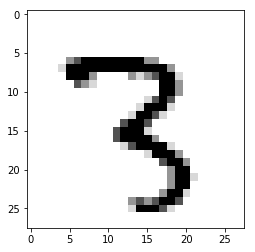

In [2]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

In [3]:
def discriminator(images, reuse=False):
    #if (reuse):
     #   tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # This finds 32 different 5 x 5 pixel features
    with tf.variable_scope(tf.get_variable_scope()) as scope:
        if (reuse):
            scope.reuse_variables()
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

    # d4 contains unscaled values
        return d4

In [4]:
def generator(z, batch_size, z_dim):
    with tf.variable_scope(tf.get_variable_scope()) as scope:
        g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g1 = tf.matmul(z, g_w1) + g_b1
        g1 = tf.reshape(g1, [-1, 56, 56, 1])
        g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
        g1 = tf.nn.relu(g1)

        # Generate 50 features
        g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
        g2 = g2 + g_b2
        g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
        g2 = tf.nn.relu(g2)
        g2 = tf.image.resize_images(g2, [56, 56])

        # Generate 25 features
        g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
        g3 = g3 + g_b3
        g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
        g3 = tf.nn.relu(g3)
        g3 = tf.image.resize_images(g3, [56, 56])

        # Final convolution with one output channel
        g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
        g4 = g4 + g_b4
        g4 = tf.sigmoid(g4)

        # Dimensions of g4: batch_size x 28 x 28 x 1
        return g4

In [5]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

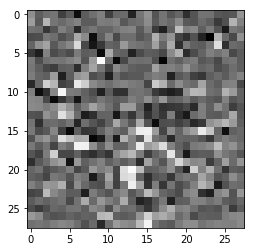

In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [7]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse=True)
# Dg will hold discriminator prediction probabilities for generated images


In [8]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [9]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [10]:

# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.693192 dLossFake: 0.716515
dLossReal: 0.0192699 dLossFake: 0.106179
dLossReal: 0.000953862 dLossFake: 0.00252402
Iteration: 0 at 2017-10-11 15:43:30.144760


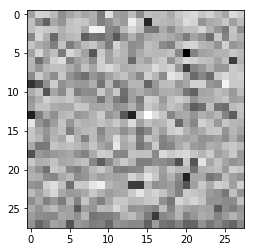

Estimate: [[-6.23184013]]
Iteration: 100 at 2017-10-11 15:46:04.975335


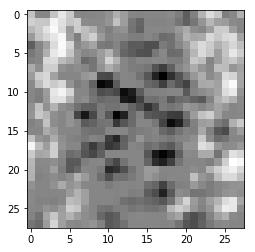

Estimate: [[-7.65404797]]
Iteration: 200 at 2017-10-11 15:48:37.611517


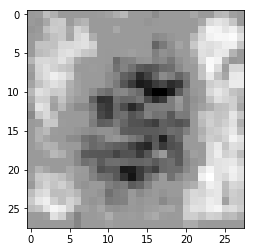

Estimate: [[-9.56848335]]
Iteration: 300 at 2017-10-11 15:51:09.717461


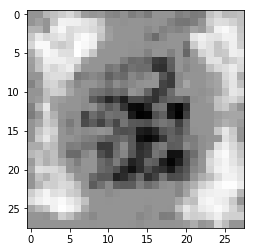

Estimate: [[-16.60027313]]
Iteration: 400 at 2017-10-11 15:53:41.308594


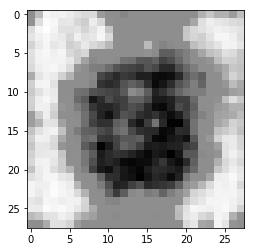

Estimate: [[-10.03457451]]
Iteration: 500 at 2017-10-11 15:56:12.695139


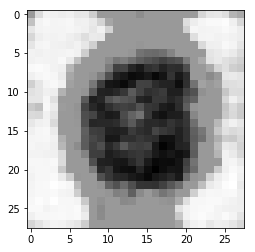

Estimate: [[-7.70196056]]
Iteration: 600 at 2017-10-11 15:58:47.257432


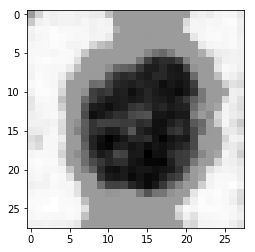

Estimate: [[-7.33148861]]
Iteration: 700 at 2017-10-11 16:01:22.033484


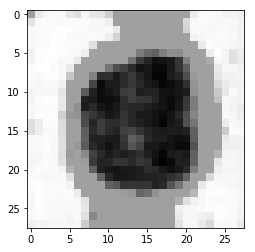

Estimate: [[-7.20655155]]
Iteration: 800 at 2017-10-11 16:03:53.982587


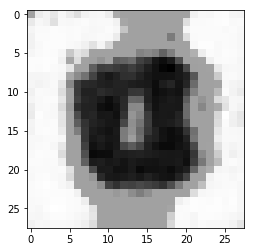

Estimate: [[-7.25012684]]
Iteration: 900 at 2017-10-11 16:06:26.131761


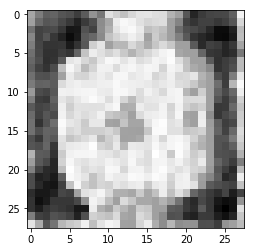

Estimate: [[-3.63397384]]
Iteration: 1000 at 2017-10-11 16:08:57.622759


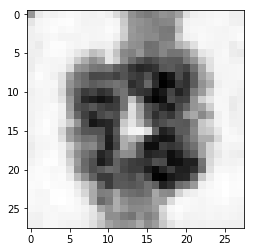

Estimate: [[-4.19830561]]
Iteration: 1100 at 2017-10-11 16:11:28.231628


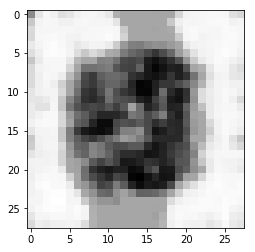

Estimate: [[-5.21669817]]
Iteration: 1200 at 2017-10-11 16:14:08.771670


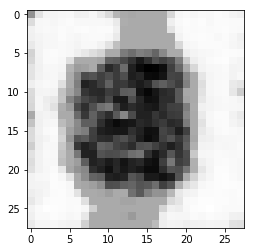

Estimate: [[-5.49475813]]
Iteration: 1300 at 2017-10-11 16:16:45.353340


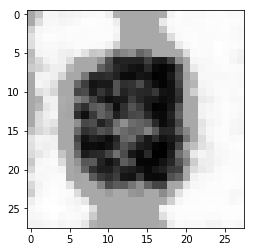

Estimate: [[-5.88941431]]
Iteration: 1400 at 2017-10-11 16:19:20.325528


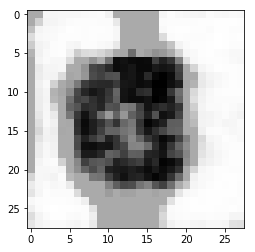

Estimate: [[-5.99217701]]
Iteration: 1500 at 2017-10-11 16:21:55.409346


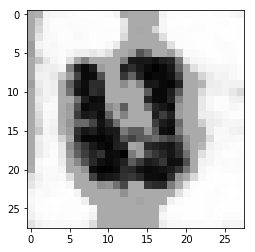

Estimate: [[-6.20667648]]
Iteration: 1600 at 2017-10-11 16:24:27.580198


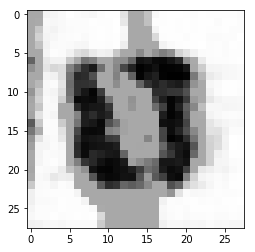

Estimate: [[-6.64565325]]
Iteration: 1700 at 2017-10-11 16:26:58.451092


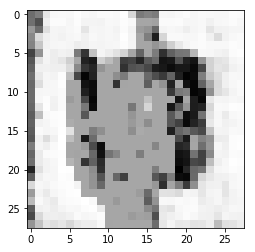

Estimate: [[-19.25939941]]
Iteration: 1800 at 2017-10-11 16:29:37.326835


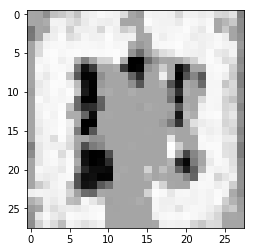

Estimate: [[-63.46330261]]
Iteration: 1900 at 2017-10-11 16:32:11.423297


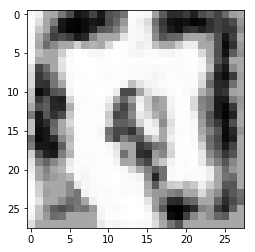

Estimate: [[-38.42726517]]
Iteration: 2000 at 2017-10-11 16:34:44.839541


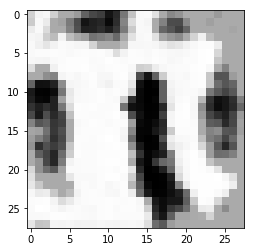

Estimate: [[-13.19399261]]
Iteration: 2100 at 2017-10-11 16:37:18.099112


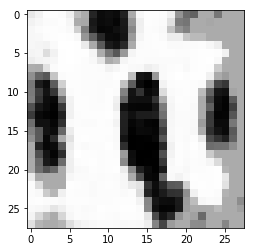

Estimate: [[-13.08770657]]
Iteration: 2200 at 2017-10-11 16:39:50.627365


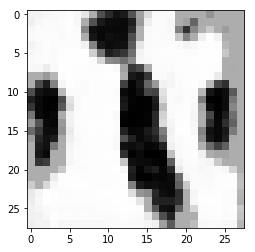

Estimate: [[-9.09703255]]
Iteration: 2300 at 2017-10-11 16:42:24.977164


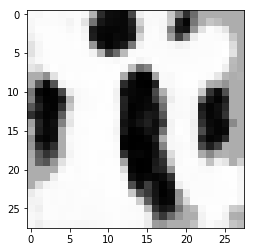

Estimate: [[-6.53261042]]
Iteration: 2400 at 2017-10-11 16:44:58.836494


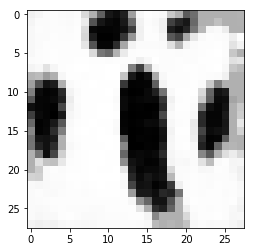

Estimate: [[-8.13849926]]
Iteration: 2500 at 2017-10-11 16:47:29.657356


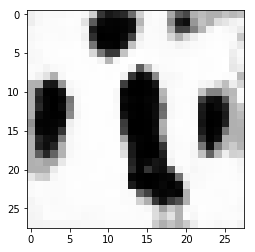

Estimate: [[-6.38985252]]
Iteration: 2600 at 2017-10-11 16:50:00.747127


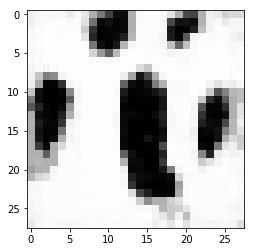

Estimate: [[-7.88628578]]
Iteration: 2700 at 2017-10-11 16:52:31.535293


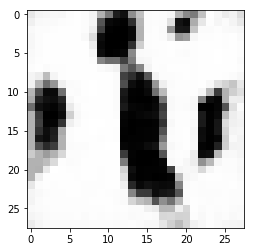

Estimate: [[-8.78537846]]
Iteration: 2800 at 2017-10-11 16:55:03.188567


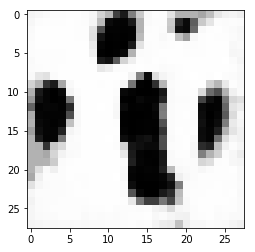

Estimate: [[-7.47428131]]
Iteration: 2900 at 2017-10-11 16:57:40.403022


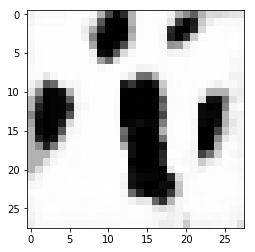

Estimate: [[-8.77463341]]
Iteration: 3000 at 2017-10-11 17:00:12.352138


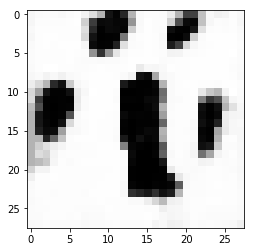

Estimate: [[-6.78550577]]
Iteration: 3100 at 2017-10-11 17:02:43.751853


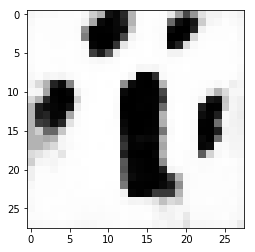

Estimate: [[-7.02238989]]
Iteration: 3200 at 2017-10-11 17:05:15.941163


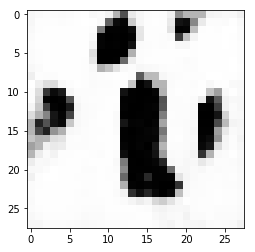

Estimate: [[-7.78497124]]
Iteration: 3300 at 2017-10-11 17:07:47.020840


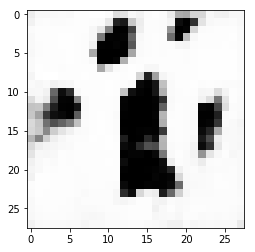

Estimate: [[-9.24842548]]
Iteration: 3400 at 2017-10-11 17:10:22.352300


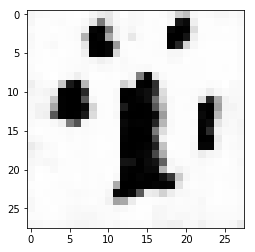

Estimate: [[-8.05829144]]
Iteration: 3500 at 2017-10-11 17:12:55.184860


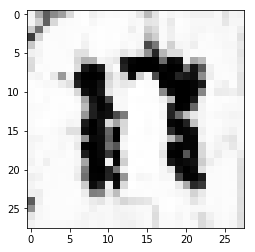

Estimate: [[-21.96295166]]
Iteration: 3600 at 2017-10-11 17:15:26.371414


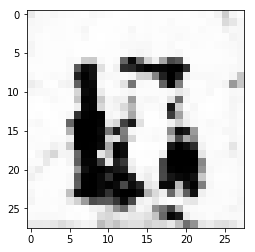

Estimate: [[-21.92839622]]
Iteration: 3700 at 2017-10-11 17:17:56.677025


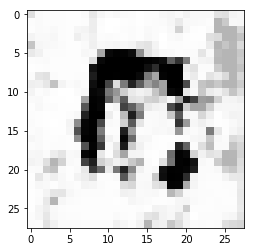

Estimate: [[-41.69386673]]
Iteration: 3800 at 2017-10-11 17:20:28.831888


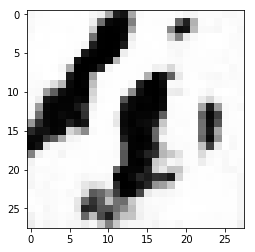

Estimate: [[-26.33042908]]
Iteration: 3900 at 2017-10-11 17:23:01.913854


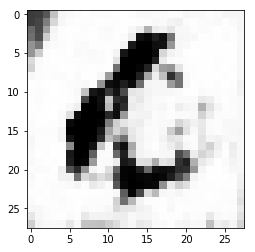

Estimate: [[-35.7482338]]
Iteration: 4000 at 2017-10-11 17:25:40.045876


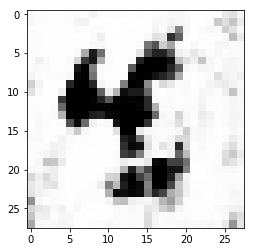

Estimate: [[-6.62717104]]
Iteration: 4100 at 2017-10-11 17:28:12.272587


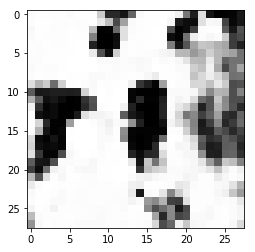

Estimate: [[-62.04233932]]
Iteration: 4200 at 2017-10-11 17:30:45.609873


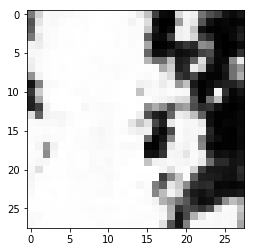

Estimate: [[-35.2340126]]
Iteration: 4300 at 2017-10-11 17:33:17.479477


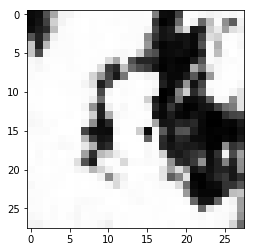

Estimate: [[-46.71482468]]
Iteration: 4400 at 2017-10-11 17:35:48.591728


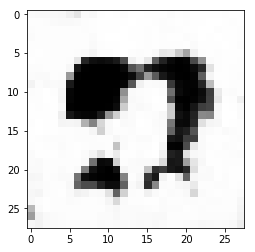

Estimate: [[-74.37342834]]
Iteration: 4500 at 2017-10-11 17:38:20.899596


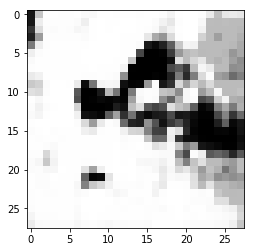

Estimate: [[-48.60752106]]
Iteration: 4600 at 2017-10-11 17:40:57.293493


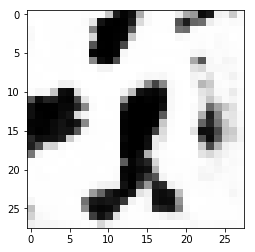

Estimate: [[-112.14244843]]
Iteration: 4700 at 2017-10-11 17:43:32.826611


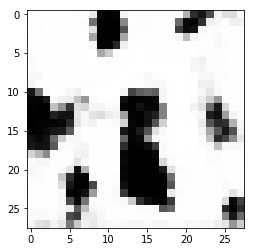

Estimate: [[-84.56536102]]
Iteration: 4800 at 2017-10-11 17:46:07.692003


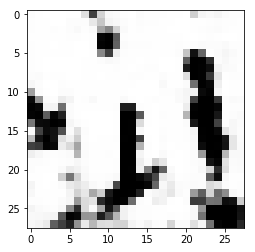

Estimate: [[-34.35323715]]
Iteration: 4900 at 2017-10-11 17:48:39.633452


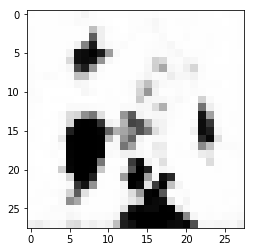

Estimate: [[-52.68165588]]
Iteration: 5000 at 2017-10-11 17:51:12.533010


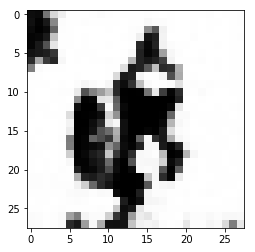

Estimate: [[-31.74328995]]
Iteration: 5100 at 2017-10-11 17:53:46.452337


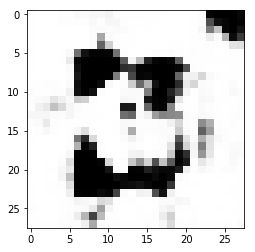

Estimate: [[-9.04994869]]
Iteration: 5200 at 2017-10-11 17:56:18.885775


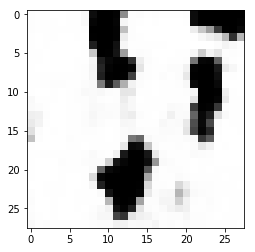

Estimate: [[-46.6552887]]
Iteration: 5300 at 2017-10-11 17:58:49.193982


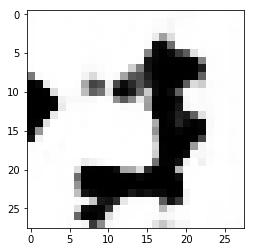

Estimate: [[-42.64077759]]
Iteration: 5400 at 2017-10-11 18:01:20.476509


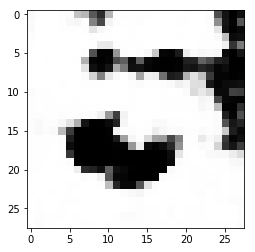

Estimate: [[-30.04084206]]
Iteration: 5500 at 2017-10-11 18:03:51.029862


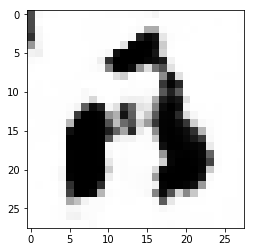

Estimate: [[-72.23934174]]
Iteration: 5600 at 2017-10-11 18:06:24.117678


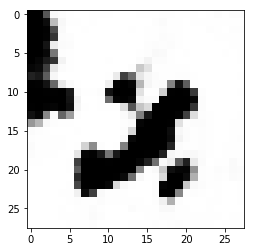

Estimate: [[-69.1317749]]
Iteration: 5700 at 2017-10-11 18:08:57.839113


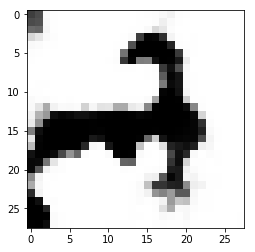

Estimate: [[-121.50901794]]
Iteration: 5800 at 2017-10-11 18:11:27.497821


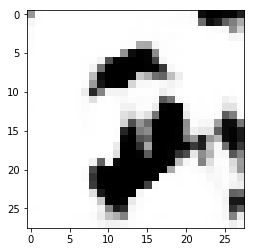

Estimate: [[-26.84944725]]
Iteration: 5900 at 2017-10-11 18:13:57.211382


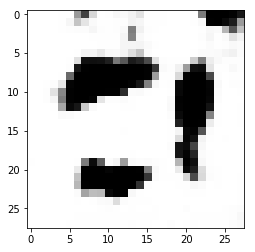

Estimate: [[-103.80552673]]
Iteration: 6000 at 2017-10-11 18:16:31.382671


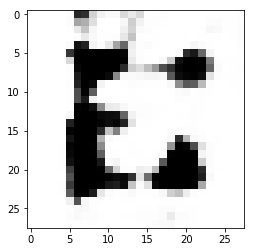

Estimate: [[-69.35051727]]
Iteration: 6100 at 2017-10-11 18:19:04.334970


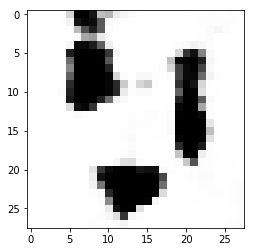

Estimate: [[-114.34728241]]
Iteration: 6200 at 2017-10-11 18:21:42.477794


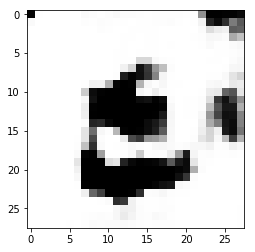

Estimate: [[-94.00112915]]
Iteration: 6300 at 2017-10-11 18:24:14.518347


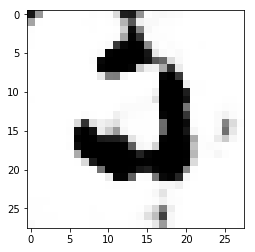

Estimate: [[-82.47880554]]
Iteration: 6400 at 2017-10-11 18:26:45.636785


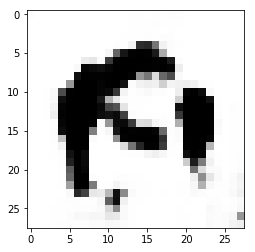

Estimate: [[-88.84393311]]
Iteration: 6500 at 2017-10-11 18:29:17.268263


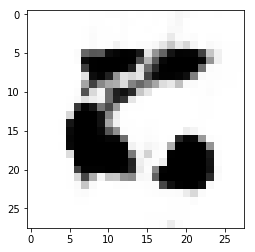

Estimate: [[-119.35176086]]
Iteration: 6600 at 2017-10-11 18:31:48.249489


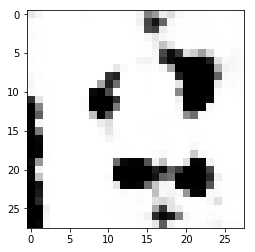

Estimate: [[-96.67889404]]
Iteration: 6700 at 2017-10-11 18:34:23.793766


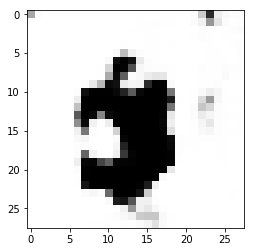

Estimate: [[-102.98452759]]
Iteration: 6800 at 2017-10-11 18:36:56.436262


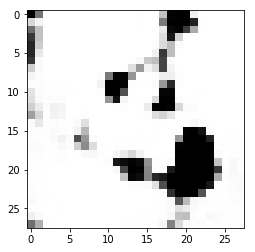

Estimate: [[-176.82408142]]
Iteration: 6900 at 2017-10-11 18:39:28.468103


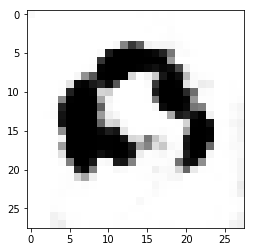

Estimate: [[-82.39554596]]
Iteration: 7000 at 2017-10-11 18:42:01.141579


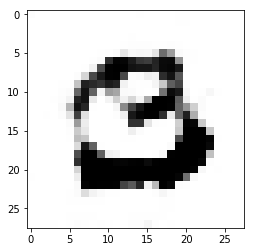

Estimate: [[-75.64400482]]
Iteration: 7100 at 2017-10-11 18:44:37.167175


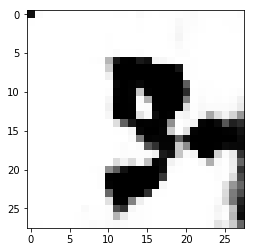

Estimate: [[-135.15617371]]
Iteration: 7200 at 2017-10-11 18:47:11.129941


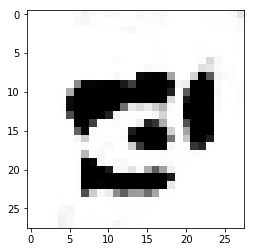

Estimate: [[-46.84832382]]
Iteration: 7300 at 2017-10-11 18:49:50.735735


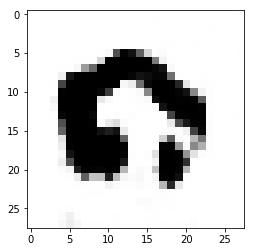

Estimate: [[-47.54025269]]
Iteration: 7400 at 2017-10-11 18:52:24.969370


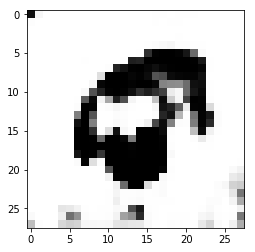

Estimate: [[-73.46630096]]
Iteration: 7500 at 2017-10-11 18:54:55.994275


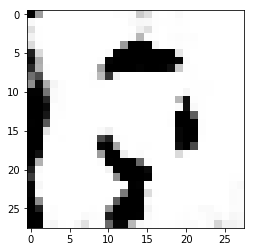

Estimate: [[-79.28373718]]
Iteration: 7600 at 2017-10-11 18:57:26.536525


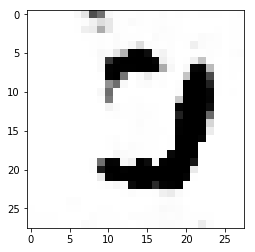

Estimate: [[-71.44198608]]
Iteration: 7700 at 2017-10-11 18:59:57.067746


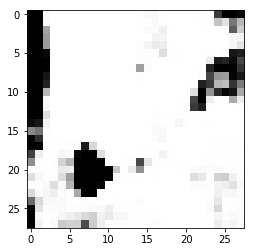

Estimate: [[-96.38625336]]
Iteration: 7800 at 2017-10-11 19:02:32.324845


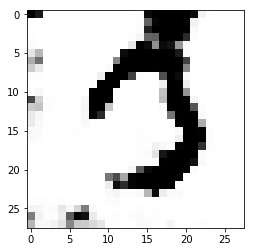

Estimate: [[-92.52401733]]
Iteration: 7900 at 2017-10-11 19:05:10.994124


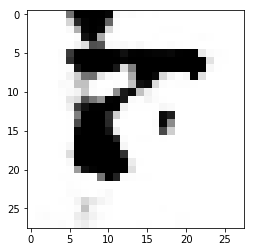

Estimate: [[-97.11309052]]
Iteration: 8000 at 2017-10-11 19:07:47.963629


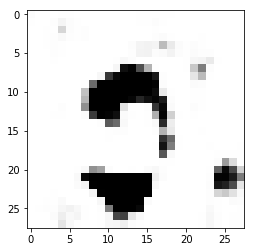

Estimate: [[-55.0303421]]
Iteration: 8100 at 2017-10-11 19:10:23.334120


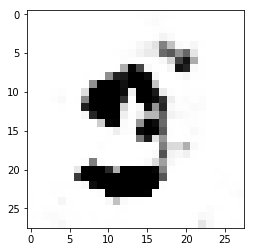

Estimate: [[-43.25611115]]
Iteration: 8200 at 2017-10-11 19:12:59.236401


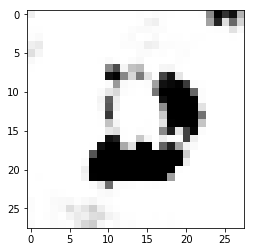

Estimate: [[-32.58530807]]
Iteration: 8300 at 2017-10-11 19:15:35.163307


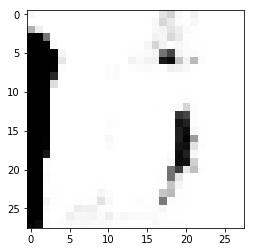

Estimate: [[-82.81651306]]
Iteration: 8400 at 2017-10-11 19:18:09.280583


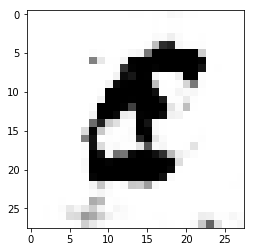

Estimate: [[-28.33572006]]
Iteration: 8500 at 2017-10-11 19:20:53.803359


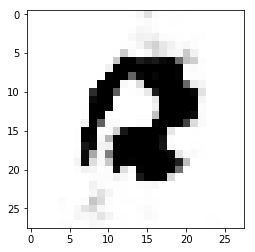

Estimate: [[-4.42838764]]
Iteration: 8600 at 2017-10-11 19:23:51.571260


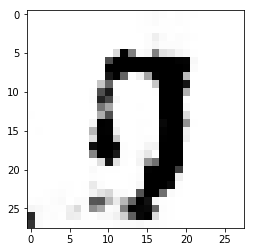

Estimate: [[-10.0796175]]
Iteration: 8700 at 2017-10-11 19:26:29.792772


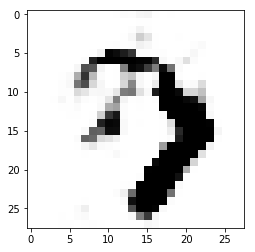

Estimate: [[ 11.4073391]]
Iteration: 8800 at 2017-10-11 19:29:06.307704


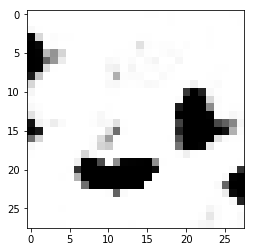

Estimate: [[-114.03417206]]
Iteration: 8900 at 2017-10-11 19:31:38.088566


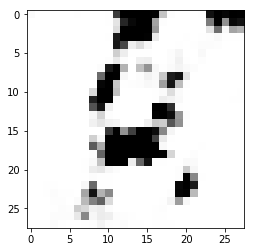

Estimate: [[-38.08950043]]
Iteration: 9000 at 2017-10-11 19:34:07.803619


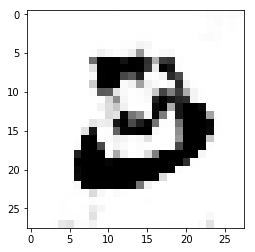

Estimate: [[ 7.26227474]]
Iteration: 9100 at 2017-10-11 19:36:40.988794


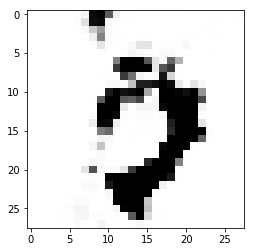

Estimate: [[-19.58222961]]
Iteration: 9200 at 2017-10-11 19:39:18.512863


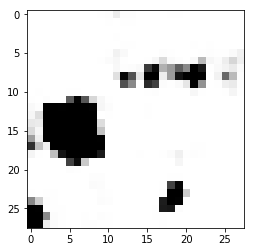

Estimate: [[-13.76428127]]
Iteration: 9300 at 2017-10-11 19:41:50.468980


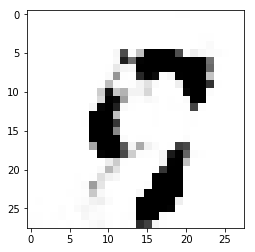

Estimate: [[-46.75018692]]
Iteration: 9400 at 2017-10-11 19:44:23.228513


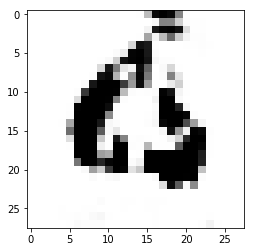

Estimate: [[-36.45310211]]
Iteration: 9500 at 2017-10-11 19:46:57.442344


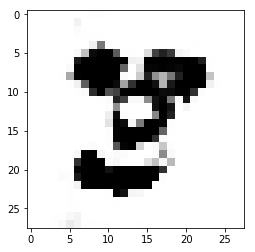

Estimate: [[-7.84959507]]
Iteration: 9600 at 2017-10-11 19:49:30.622390


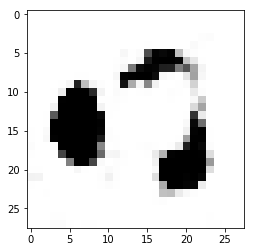

Estimate: [[-61.30405807]]
Iteration: 9700 at 2017-10-11 19:52:03.216058


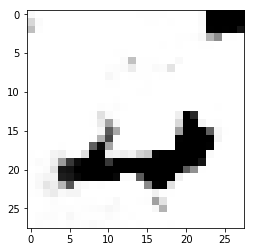

Estimate: [[ 6.78120422]]
Iteration: 9800 at 2017-10-11 19:54:30.212767


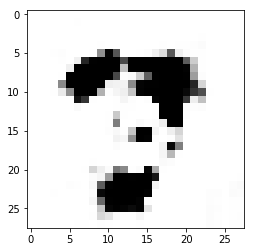

Estimate: [[-57.08092117]]
Iteration: 9900 at 2017-10-11 19:57:03.526514


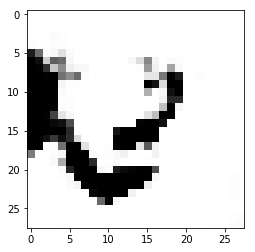

Estimate: [[ 36.04260254]]
Iteration: 10000 at 2017-10-11 19:59:38.165740


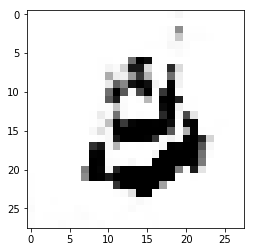

Estimate: [[ 24.56045723]]
Iteration: 10100 at 2017-10-11 20:02:12.513842


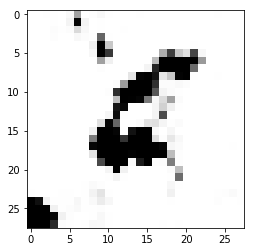

Estimate: [[-21.04489136]]
Iteration: 10200 at 2017-10-11 20:04:45.654485


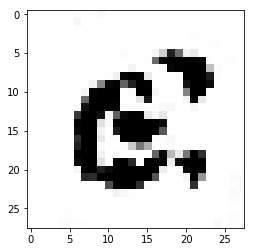

Estimate: [[-45.23482513]]
Iteration: 10300 at 2017-10-11 20:07:18.338763


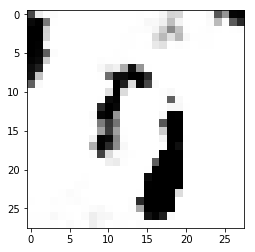

Estimate: [[ 1.98804104]]
Iteration: 10400 at 2017-10-11 20:09:50.841366


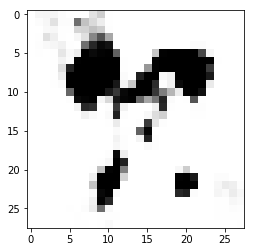

Estimate: [[-41.43355942]]
Iteration: 10500 at 2017-10-11 20:12:18.779396


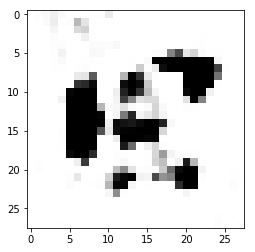

Estimate: [[-85.78644562]]
Iteration: 10600 at 2017-10-11 20:14:46.644375


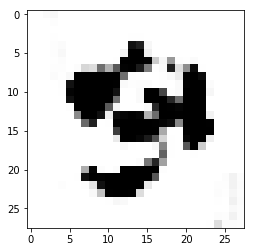

Estimate: [[-54.32655716]]
Iteration: 10700 at 2017-10-11 20:17:14.178688


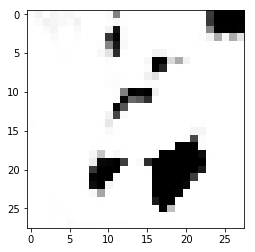

Estimate: [[-101.77185822]]
Iteration: 10800 at 2017-10-11 20:19:42.606372


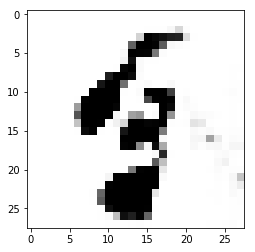

Estimate: [[-50.97515869]]
Iteration: 10900 at 2017-10-11 20:22:10.272468


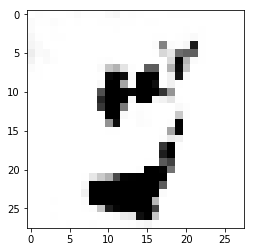

Estimate: [[-6.72889328]]
Iteration: 11000 at 2017-10-11 20:24:38.070375


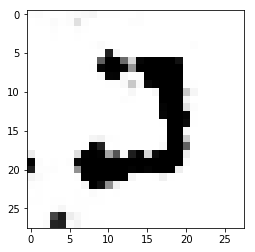

Estimate: [[ 12.43661308]]
Iteration: 11100 at 2017-10-11 20:27:05.130672


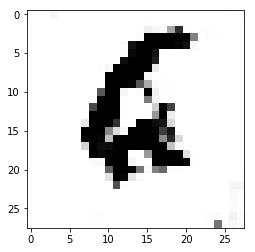

Estimate: [[-81.80525208]]
Iteration: 11200 at 2017-10-11 20:29:32.002865


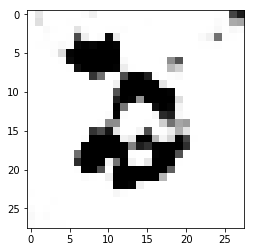

Estimate: [[ 47.54446793]]
Iteration: 11300 at 2017-10-11 20:32:00.183475


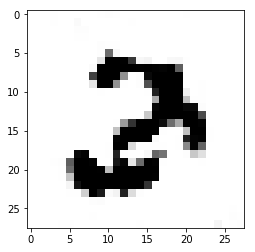

Estimate: [[-29.53354645]]
Iteration: 11400 at 2017-10-11 20:34:27.828718


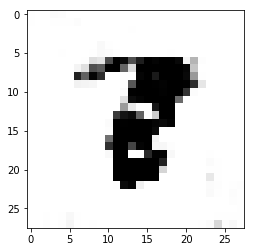

Estimate: [[-43.86816025]]
Iteration: 11500 at 2017-10-11 20:36:55.144398


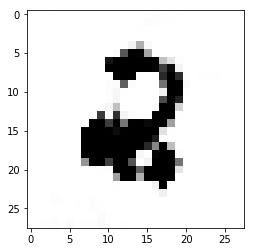

Estimate: [[-40.42095947]]
Iteration: 11600 at 2017-10-11 20:39:21.939170


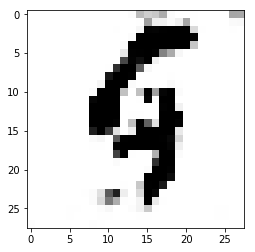

Estimate: [[-12.66570282]]
Iteration: 11700 at 2017-10-11 20:41:49.250386


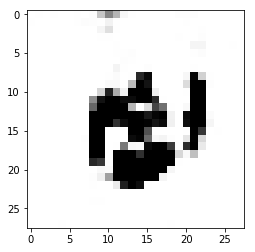

Estimate: [[-2.59897614]]
Iteration: 11800 at 2017-10-11 20:44:16.331112


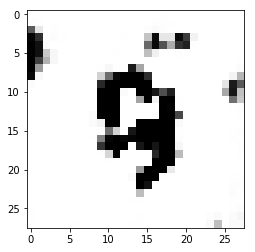

Estimate: [[-56.03603745]]
Iteration: 11900 at 2017-10-11 20:46:43.322904


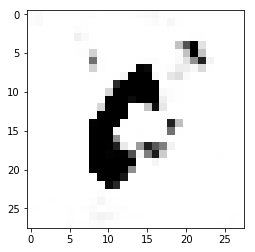

Estimate: [[-12.58148193]]
Iteration: 12000 at 2017-10-11 20:49:11.681242


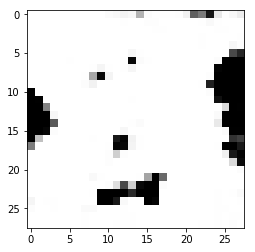

Estimate: [[ 16.50640678]]
Iteration: 12100 at 2017-10-11 20:51:40.013095


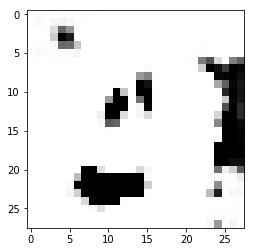

Estimate: [[ 33.16283798]]
Iteration: 12200 at 2017-10-11 20:54:08.122962


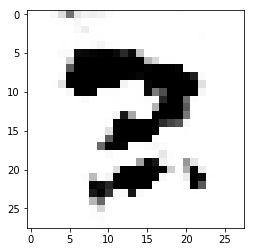

Estimate: [[ 14.352952]]
Iteration: 12300 at 2017-10-11 20:56:35.584880


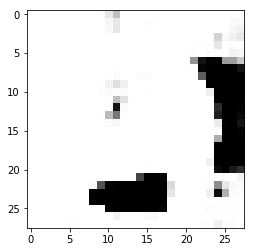

Estimate: [[ 102.04914093]]
Iteration: 12400 at 2017-10-11 20:59:03.012778


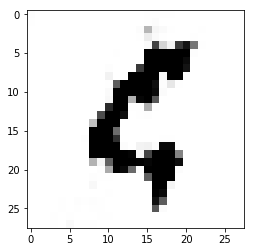

Estimate: [[-48.95811081]]
Iteration: 12500 at 2017-10-11 21:01:30.244284


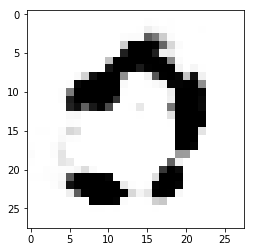

Estimate: [[ 5.00730324]]
Iteration: 12600 at 2017-10-11 21:04:00.108141


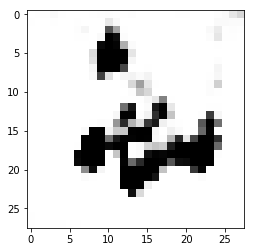

Estimate: [[ 57.20968628]]
Iteration: 12700 at 2017-10-11 21:06:30.059820


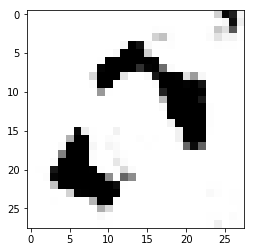

Estimate: [[ 10.98415375]]
Iteration: 12800 at 2017-10-11 21:08:59.983426


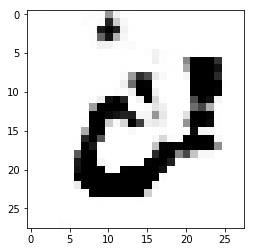

Estimate: [[-66.38117218]]
Iteration: 12900 at 2017-10-11 21:11:29.991255


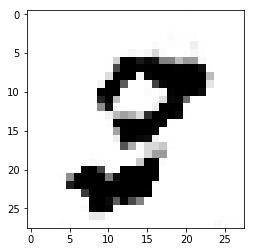

Estimate: [[-0.77504486]]
Iteration: 13000 at 2017-10-11 21:14:00.019138


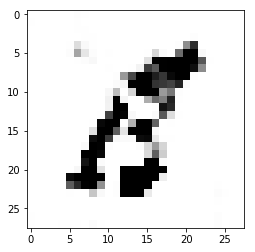

Estimate: [[-19.67615318]]
Iteration: 13100 at 2017-10-11 21:16:30.004909


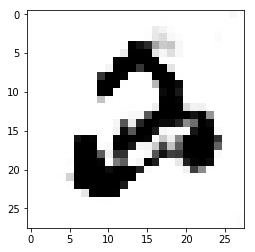

Estimate: [[-60.64176941]]
Iteration: 13200 at 2017-10-11 21:18:59.332731


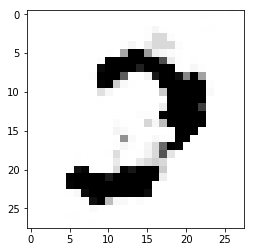

Estimate: [[ 37.98999023]]
Iteration: 13300 at 2017-10-11 21:21:26.375217


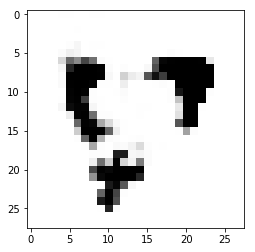

Estimate: [[-38.17708969]]
Iteration: 13400 at 2017-10-11 21:23:53.737404


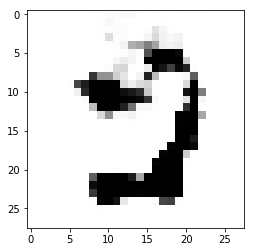

Estimate: [[-28.41314888]]
Iteration: 13500 at 2017-10-11 21:26:20.648790


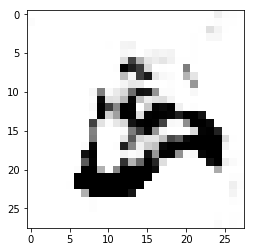

Estimate: [[ 89.99861908]]
Iteration: 13600 at 2017-10-11 21:28:47.674417


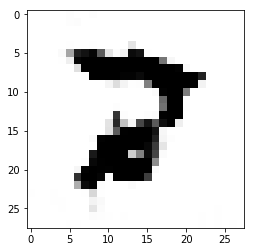

Estimate: [[ 32.76758957]]
Iteration: 13700 at 2017-10-11 21:31:16.147265


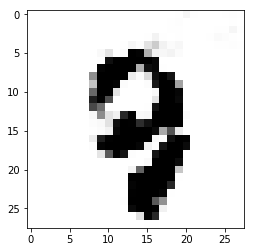

Estimate: [[-35.37960434]]
Iteration: 13800 at 2017-10-11 21:33:47.486254


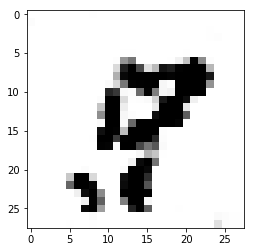

Estimate: [[ 13.58249569]]
Iteration: 13900 at 2017-10-11 21:36:17.747342


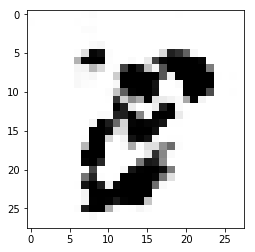

Estimate: [[-43.90649796]]
Iteration: 14000 at 2017-10-11 21:38:48.787246


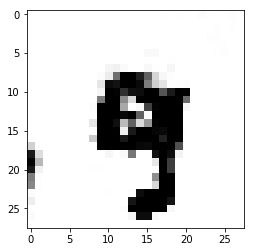

Estimate: [[-24.02818871]]
Iteration: 14100 at 2017-10-11 21:41:18.513138


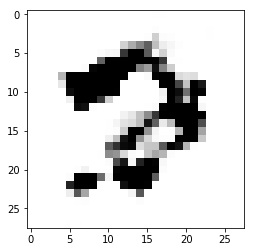

Estimate: [[-39.06597519]]
Iteration: 14200 at 2017-10-11 21:43:45.917607


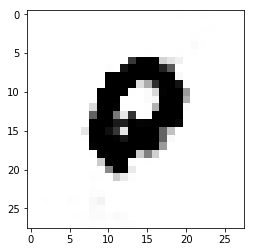

Estimate: [[-10.48532391]]
Iteration: 14300 at 2017-10-11 21:46:13.068419


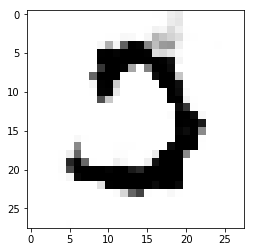

Estimate: [[ 15.55561256]]
Iteration: 14400 at 2017-10-11 21:48:39.828419


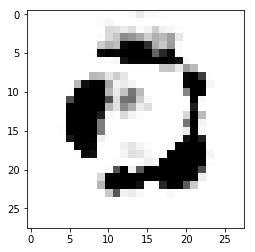

Estimate: [[-38.03076553]]
Iteration: 14500 at 2017-10-11 21:51:07.011245


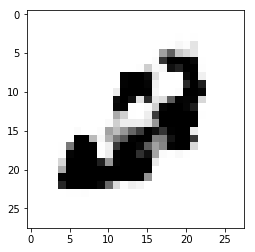

Estimate: [[ 7.23897934]]
Iteration: 14600 at 2017-10-11 21:53:33.871206


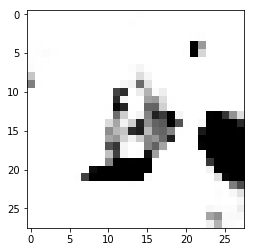

Estimate: [[ 110.52423859]]
Iteration: 14700 at 2017-10-11 21:56:00.976353


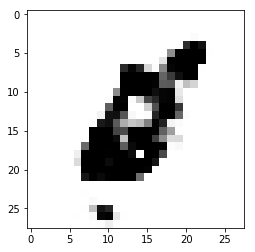

Estimate: [[-25.29078102]]
Iteration: 14800 at 2017-10-11 21:58:27.599193


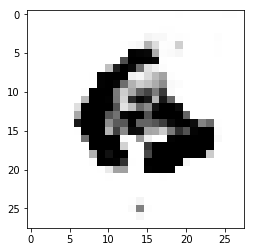

Estimate: [[-32.56193542]]
Iteration: 14900 at 2017-10-11 22:00:53.923048


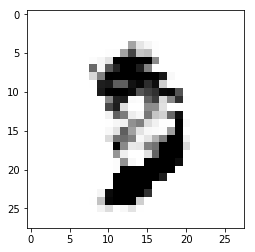

Estimate: [[-28.11811447]]
Iteration: 15000 at 2017-10-11 22:03:20.587084


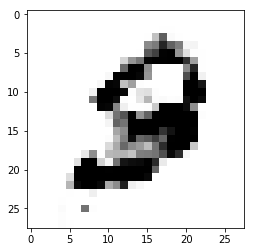

Estimate: [[-10.8622551]]
Iteration: 15100 at 2017-10-11 22:05:47.541090


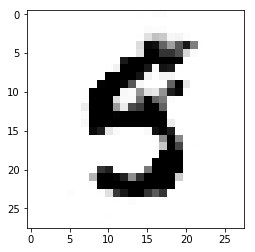

Estimate: [[ 4.12417126]]
Iteration: 15200 at 2017-10-11 22:08:14.100109


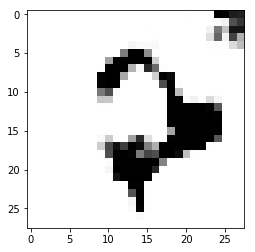

Estimate: [[ 19.04471779]]
Iteration: 15300 at 2017-10-11 22:10:41.008593


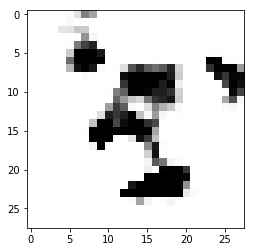

Estimate: [[-67.22832489]]
Iteration: 15400 at 2017-10-11 22:13:07.766188


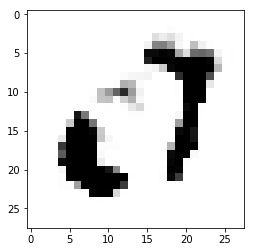

Estimate: [[-20.91675568]]
Iteration: 15500 at 2017-10-11 22:15:35.193375


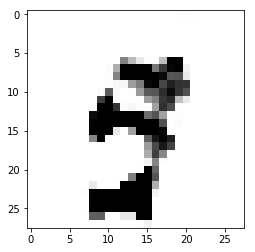

Estimate: [[-8.28571033]]
Iteration: 15600 at 2017-10-11 22:18:01.968392


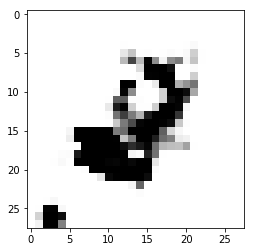

Estimate: [[-35.07217026]]
Iteration: 15700 at 2017-10-11 22:20:28.476681


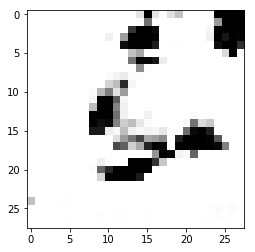

Estimate: [[-16.6348114]]
Iteration: 15800 at 2017-10-11 22:22:55.607978


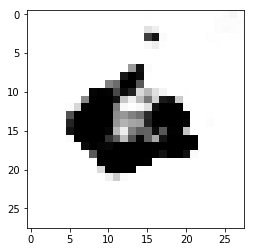

Estimate: [[ 4.49166059]]
Iteration: 15900 at 2017-10-11 22:25:22.554907


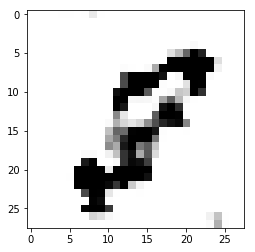

Estimate: [[ 8.16518784]]
Iteration: 16000 at 2017-10-11 22:27:49.675876


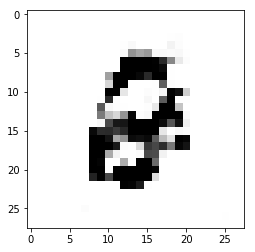

Estimate: [[-51.93175125]]
Iteration: 16100 at 2017-10-11 22:30:16.717998


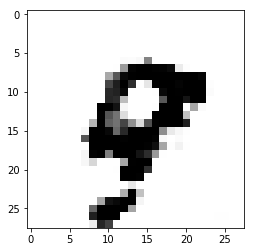

Estimate: [[-9.27069283]]
Iteration: 16200 at 2017-10-11 22:32:44.167244


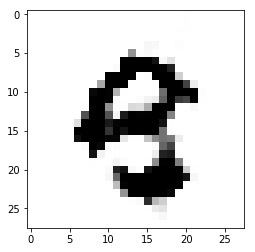

Estimate: [[-12.71535873]]
Iteration: 16300 at 2017-10-11 22:35:10.990775


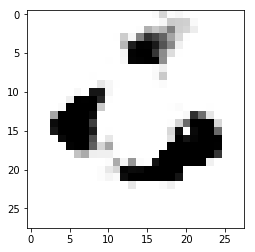

Estimate: [[-10.92662048]]
Iteration: 16400 at 2017-10-11 22:37:37.752601


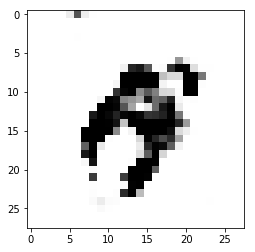

Estimate: [[-54.51112747]]
Iteration: 16500 at 2017-10-11 22:40:04.556647


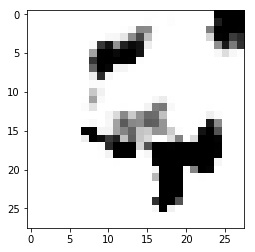

Estimate: [[-37.06678009]]
Iteration: 16600 at 2017-10-11 22:42:31.488024


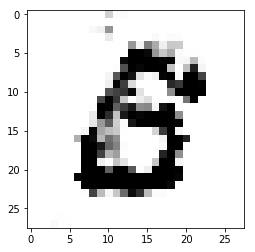

Estimate: [[-21.51675606]]
Iteration: 16700 at 2017-10-11 22:44:58.192634


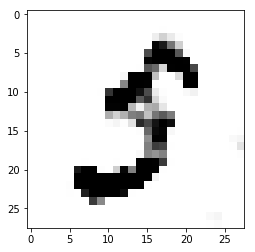

Estimate: [[-23.11457443]]
Iteration: 16800 at 2017-10-11 22:47:25.134397


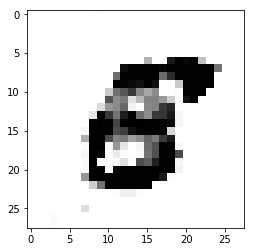

Estimate: [[-21.56532097]]
Iteration: 16900 at 2017-10-11 22:49:52.883750


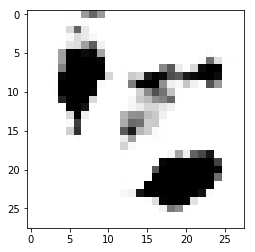

Estimate: [[-37.9691658]]
Iteration: 17000 at 2017-10-11 22:52:20.318814


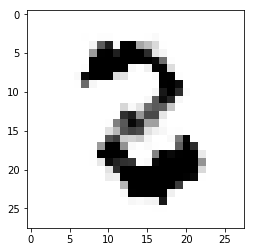

Estimate: [[ 6.32159615]]
Iteration: 17100 at 2017-10-11 22:54:47.400879


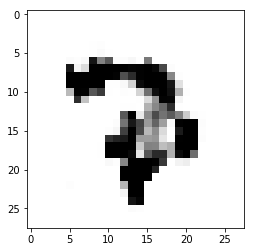

Estimate: [[-14.97960091]]
Iteration: 17200 at 2017-10-11 22:57:14.430401


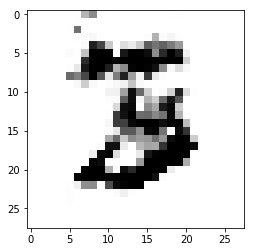

Estimate: [[-38.51559067]]
Iteration: 17300 at 2017-10-11 22:59:41.340341


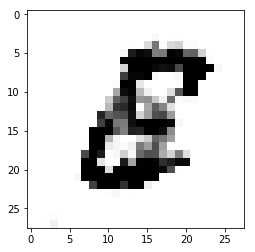

Estimate: [[-50.37676239]]
Iteration: 17400 at 2017-10-11 23:02:08.469722


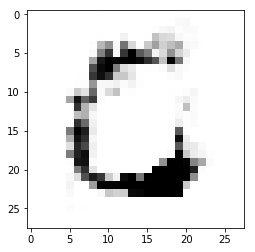

Estimate: [[-54.42197037]]
Iteration: 17500 at 2017-10-11 23:04:35.666741


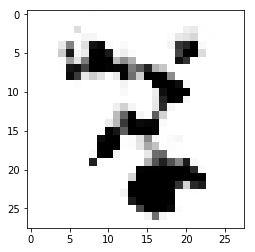

Estimate: [[ 7.07546043]]
Iteration: 17600 at 2017-10-11 23:07:02.547520


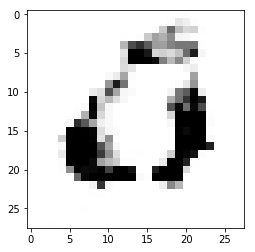

Estimate: [[-32.29831696]]
Iteration: 17700 at 2017-10-11 23:09:29.634327


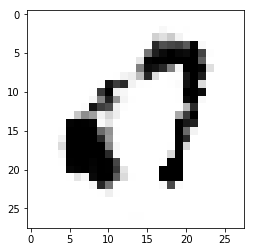

Estimate: [[-38.4122467]]
Iteration: 17800 at 2017-10-11 23:11:56.672330


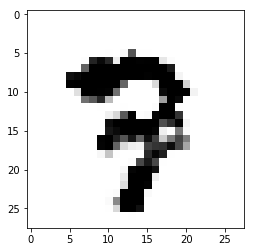

Estimate: [[-11.10188389]]
Iteration: 17900 at 2017-10-11 23:14:23.869252


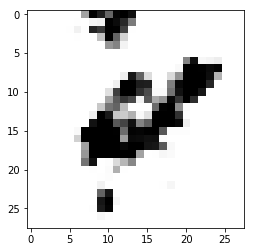

Estimate: [[-41.43070984]]
Iteration: 18000 at 2017-10-11 23:16:51.038640


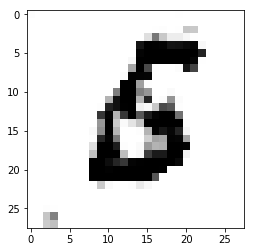

Estimate: [[ 26.01634598]]
Iteration: 18100 at 2017-10-11 23:19:18.164014


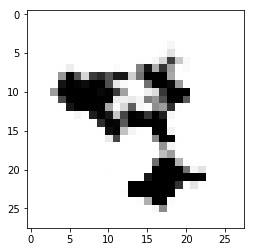

Estimate: [[-14.90299702]]
Iteration: 18200 at 2017-10-11 23:21:46.204867


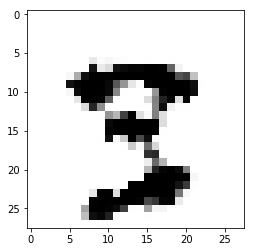

Estimate: [[-21.95277405]]
Iteration: 18300 at 2017-10-11 23:24:13.209197


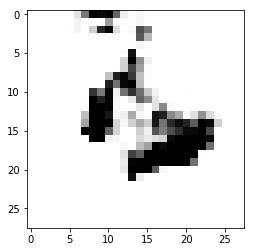

Estimate: [[-18.36383247]]
Iteration: 18400 at 2017-10-11 23:26:40.229960


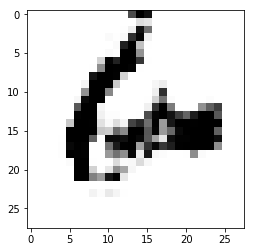

Estimate: [[ 3.96779442]]
Iteration: 18500 at 2017-10-11 23:29:07.479924


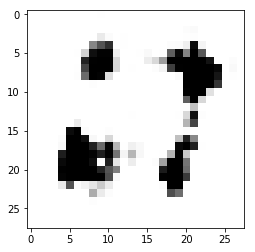

Estimate: [[-61.87267685]]
Iteration: 18600 at 2017-10-11 23:31:35.318306


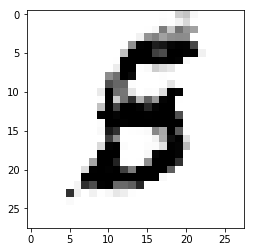

Estimate: [[-25.12387848]]
Iteration: 18700 at 2017-10-11 23:34:02.219376


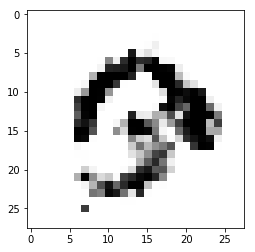

Estimate: [[-43.80826569]]
Iteration: 18800 at 2017-10-11 23:36:28.923758


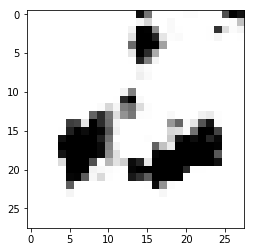

Estimate: [[-8.82209778]]
Iteration: 18900 at 2017-10-11 23:38:56.052387


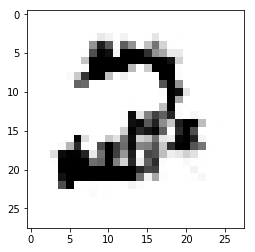

Estimate: [[-72.27526093]]
Iteration: 19000 at 2017-10-11 23:41:22.968773


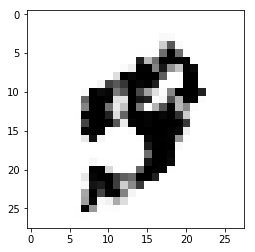

Estimate: [[-35.76926804]]
Iteration: 19100 at 2017-10-11 23:43:50.155339


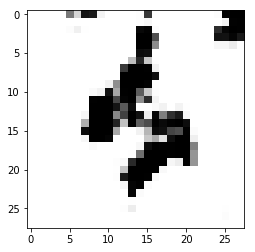

Estimate: [[-23.7136097]]
Iteration: 19200 at 2017-10-11 23:46:16.947003


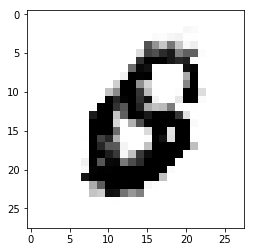

Estimate: [[-36.2846489]]
Iteration: 19300 at 2017-10-11 23:48:44.635279


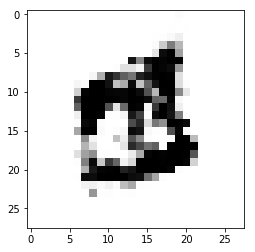

Estimate: [[-60.10929108]]
Iteration: 19400 at 2017-10-11 23:51:12.388407


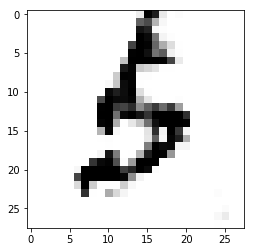

Estimate: [[-40.42263794]]
Iteration: 19500 at 2017-10-11 23:53:39.649429


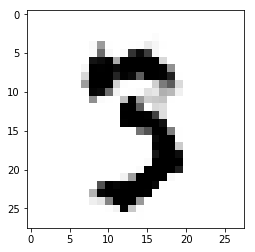

Estimate: [[-9.30632782]]
Iteration: 19600 at 2017-10-11 23:56:08.122531


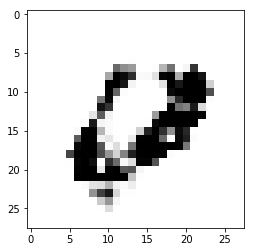

Estimate: [[-22.1713829]]
Iteration: 19700 at 2017-10-11 23:58:37.727520


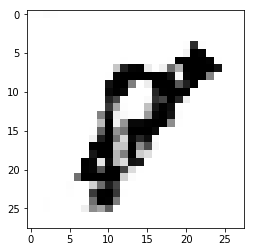

Estimate: [[ 28.82665825]]
Iteration: 19800 at 2017-10-12 00:01:04.711595


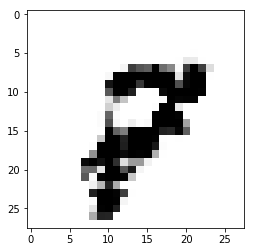

Estimate: [[ 33.18201065]]
Iteration: 19900 at 2017-10-12 00:03:31.676917


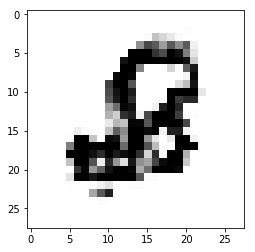

Estimate: [[-6.16330481]]
Iteration: 20000 at 2017-10-12 00:05:58.999291


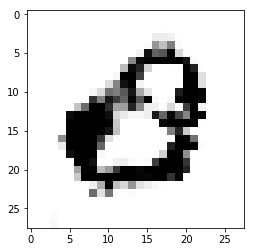

Estimate: [[-30.67605782]]
Iteration: 20100 at 2017-10-12 00:08:26.156088


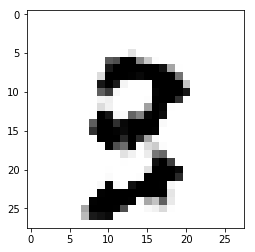

Estimate: [[ 22.02379036]]
Iteration: 20200 at 2017-10-12 00:10:54.610825


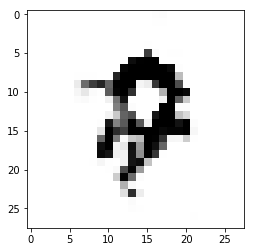

Estimate: [[-64.83570099]]
Iteration: 20300 at 2017-10-12 00:13:23.312902


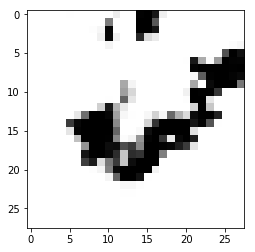

Estimate: [[-225.13369751]]
Iteration: 20400 at 2017-10-12 00:15:52.962612


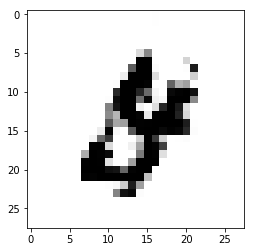

Estimate: [[-22.21628952]]
Iteration: 20500 at 2017-10-12 00:18:20.328312


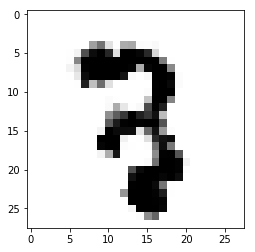

Estimate: [[-14.43591881]]
Iteration: 20600 at 2017-10-12 00:20:49.436569


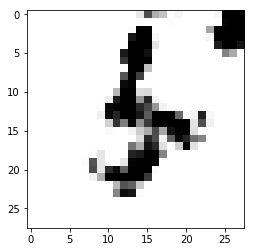

Estimate: [[-34.34342957]]
Iteration: 20700 at 2017-10-12 00:23:16.728816


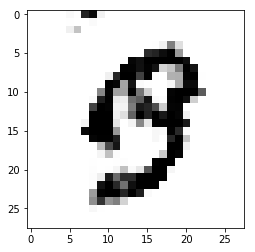

Estimate: [[-28.53249359]]
Iteration: 20800 at 2017-10-12 00:25:43.753983


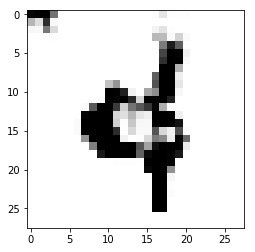

Estimate: [[-16.35030937]]
Iteration: 20900 at 2017-10-12 00:28:10.528944


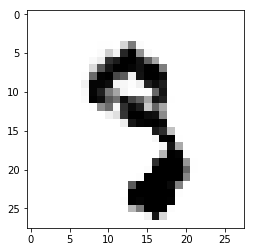

Estimate: [[-26.25748062]]
Iteration: 21000 at 2017-10-12 00:30:38.065395


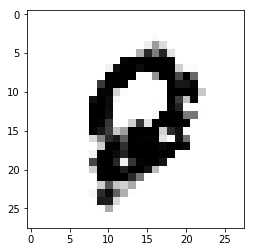

Estimate: [[-33.68178177]]
Iteration: 21100 at 2017-10-12 00:33:05.045525


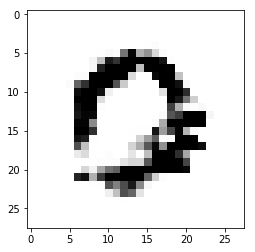

Estimate: [[-63.62459183]]
Iteration: 21200 at 2017-10-12 00:35:33.199729


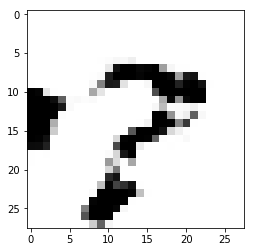

Estimate: [[ 142.83120728]]
Iteration: 21300 at 2017-10-12 00:38:00.030404


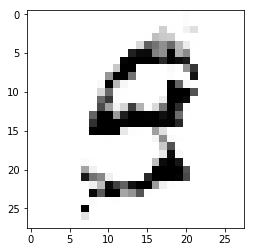

Estimate: [[-29.15654373]]
Iteration: 21400 at 2017-10-12 00:40:27.296958


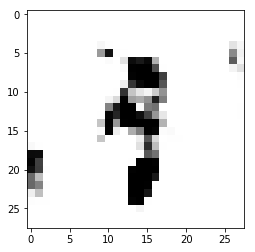

Estimate: [[-124.56684875]]
Iteration: 21500 at 2017-10-12 00:42:54.319936


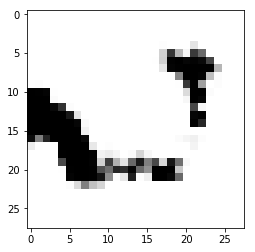

Estimate: [[ 24.56413078]]
Iteration: 21600 at 2017-10-12 00:45:21.468093


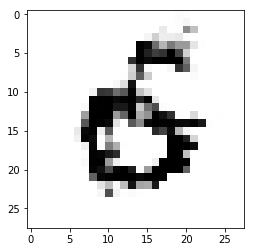

Estimate: [[-55.48493958]]
Iteration: 21700 at 2017-10-12 00:47:49.014203


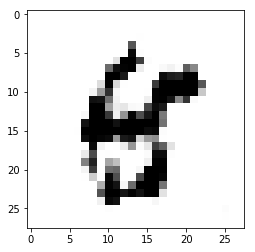

Estimate: [[-34.00109482]]
Iteration: 21800 at 2017-10-12 00:50:16.433560


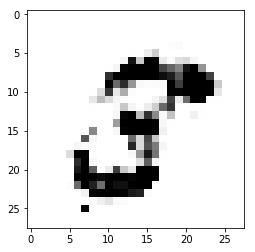

Estimate: [[-56.28544235]]
Iteration: 21900 at 2017-10-12 00:52:43.978534


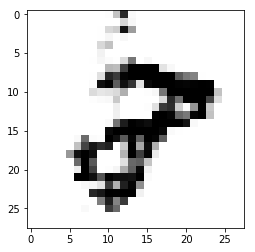

Estimate: [[-32.2882843]]
Iteration: 22000 at 2017-10-12 00:55:11.144685


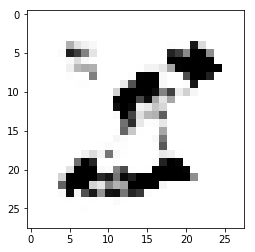

Estimate: [[-48.36298752]]
Iteration: 22100 at 2017-10-12 00:57:39.207844


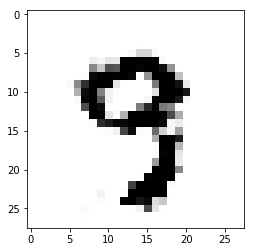

Estimate: [[-10.0928154]]
Iteration: 22200 at 2017-10-12 01:00:06.587402


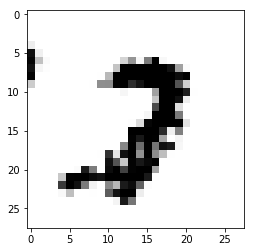

Estimate: [[-97.15619659]]
Iteration: 22300 at 2017-10-12 01:02:33.469928


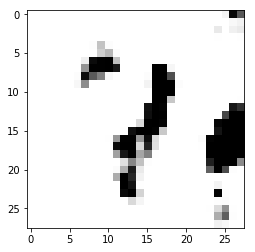

Estimate: [[ 16.55374908]]
Iteration: 22400 at 2017-10-12 01:05:01.027488


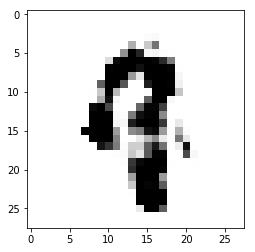

Estimate: [[-31.69976234]]
Iteration: 22500 at 2017-10-12 01:07:28.470617


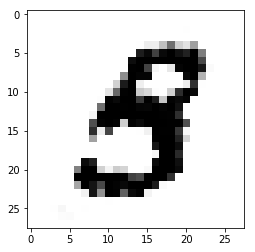

Estimate: [[-25.93424988]]
Iteration: 22600 at 2017-10-12 01:09:55.748845


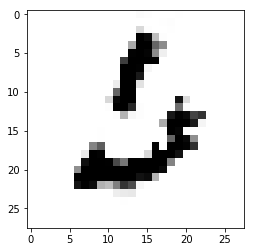

Estimate: [[-51.30878448]]
Iteration: 22700 at 2017-10-12 01:12:22.906232


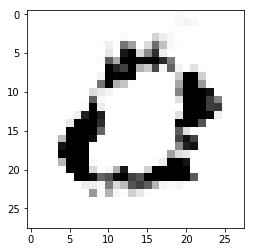

Estimate: [[-68.40486145]]
Iteration: 22800 at 2017-10-12 01:14:50.256841


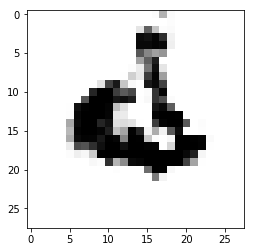

Estimate: [[-14.09095383]]
Iteration: 22900 at 2017-10-12 01:17:17.729379


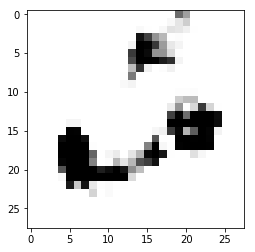

Estimate: [[-62.05184174]]
Iteration: 23000 at 2017-10-12 01:19:44.949065


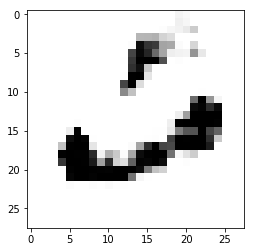

Estimate: [[-11.39752483]]
Iteration: 23100 at 2017-10-12 01:22:12.289094


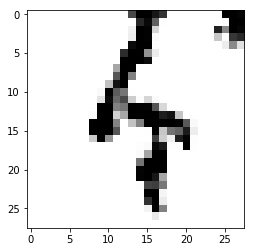

Estimate: [[-22.87553406]]
Iteration: 23200 at 2017-10-12 01:24:39.969309


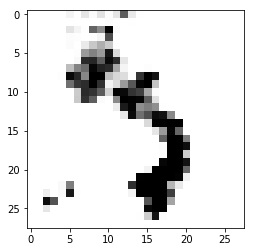

Estimate: [[-81.11141205]]
Iteration: 23300 at 2017-10-12 01:27:07.683761


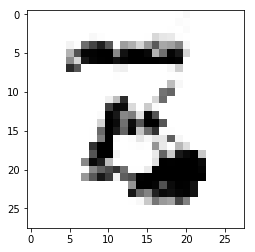

Estimate: [[-29.70007324]]
Iteration: 23400 at 2017-10-12 01:29:35.448589


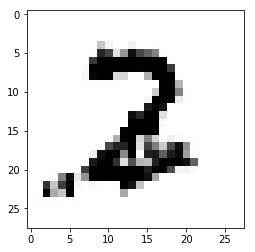

Estimate: [[-36.10668945]]
Iteration: 23500 at 2017-10-12 01:32:02.991805


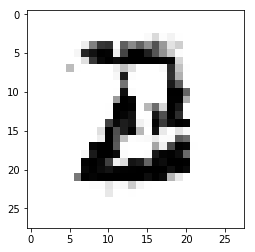

Estimate: [[-7.67334223]]
Iteration: 23600 at 2017-10-12 01:34:30.322428


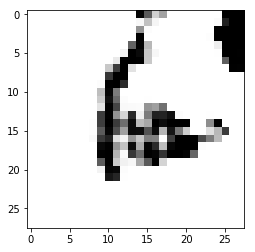

Estimate: [[-1.18086243]]
Iteration: 23700 at 2017-10-12 01:36:57.688172


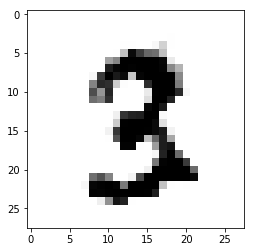

Estimate: [[-35.91165543]]
Iteration: 23800 at 2017-10-12 01:39:25.060399


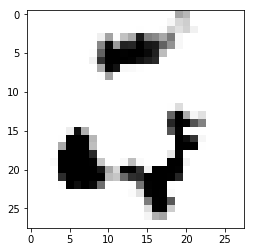

Estimate: [[-18.71929169]]
Iteration: 23900 at 2017-10-12 01:41:52.667528


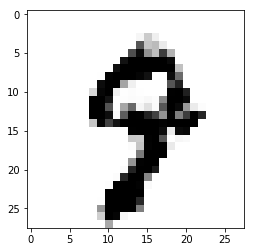

Estimate: [[-35.41418457]]
Iteration: 24000 at 2017-10-12 01:44:19.957611


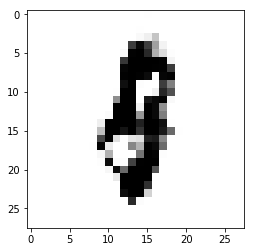

Estimate: [[-88.28451538]]
Iteration: 24100 at 2017-10-12 01:46:47.251524


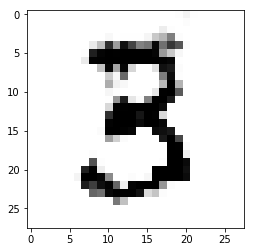

Estimate: [[ 2.34088063]]
Iteration: 24200 at 2017-10-12 01:49:14.731872


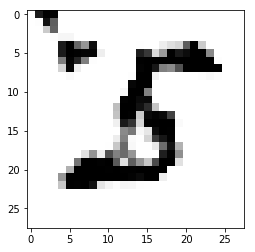

Estimate: [[-79.71736908]]
Iteration: 24300 at 2017-10-12 01:51:41.957617


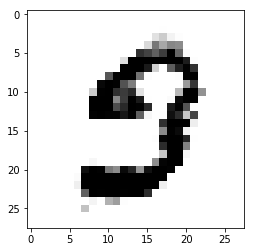

Estimate: [[-89.58396912]]
Iteration: 24400 at 2017-10-12 01:54:09.596988


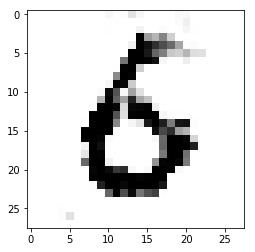

Estimate: [[ 55.46128845]]
Iteration: 24500 at 2017-10-12 01:56:37.080182


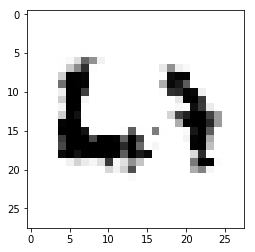

Estimate: [[ 49.66239166]]
Iteration: 24600 at 2017-10-12 01:59:04.556277


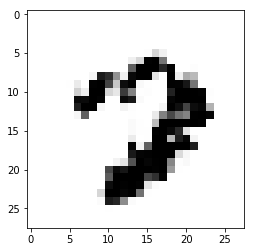

Estimate: [[-65.98506927]]
Iteration: 24700 at 2017-10-12 02:01:32.249989


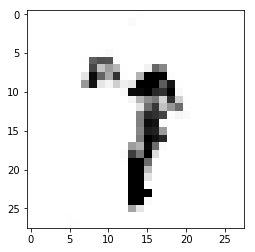

Estimate: [[-50.23815536]]
Iteration: 24800 at 2017-10-12 02:03:59.930630


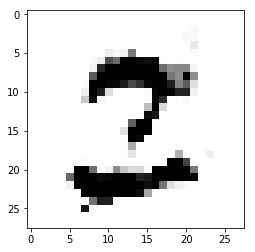

Estimate: [[-72.86206818]]
Iteration: 24900 at 2017-10-12 02:06:27.382874


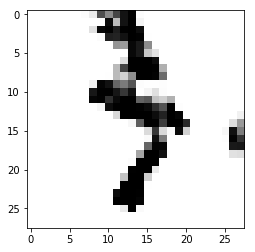

Estimate: [[-65.29216003]]
Iteration: 25000 at 2017-10-12 02:08:54.968316


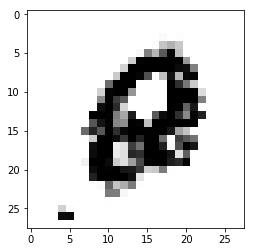

Estimate: [[-43.02431107]]
Iteration: 25100 at 2017-10-12 02:11:22.557538


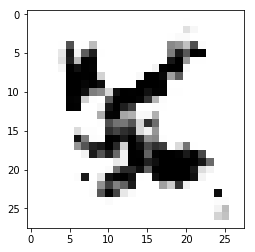

Estimate: [[ 50.03607178]]
Iteration: 25200 at 2017-10-12 02:13:50.201122


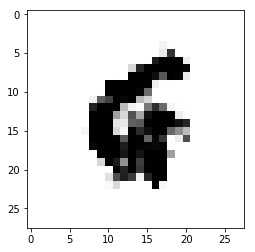

Estimate: [[-78.57332611]]
Iteration: 25300 at 2017-10-12 02:16:18.009159


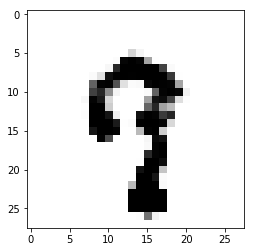

Estimate: [[-12.58541107]]
Iteration: 25400 at 2017-10-12 02:18:45.773145


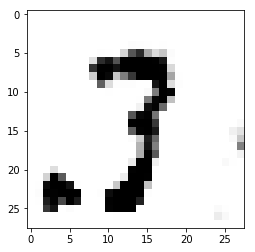

Estimate: [[ 9.39466572]]
Iteration: 25500 at 2017-10-12 02:21:13.425874


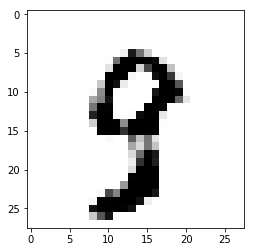

Estimate: [[-15.9994669]]
Iteration: 25600 at 2017-10-12 02:23:41.003944


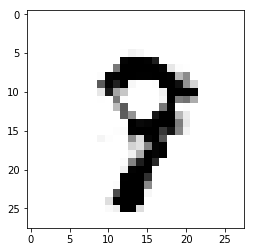

Estimate: [[-71.95423889]]
Iteration: 25700 at 2017-10-12 02:26:09.112350


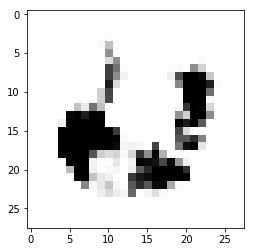

Estimate: [[ 7.15411186]]
Iteration: 25800 at 2017-10-12 02:28:36.687724


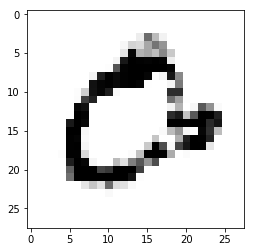

Estimate: [[ 13.42931366]]
Iteration: 25900 at 2017-10-12 02:31:04.400101


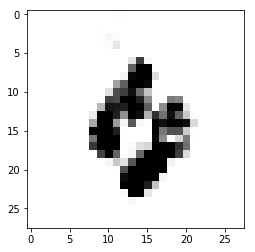

Estimate: [[-61.64161682]]
Iteration: 26000 at 2017-10-12 02:33:31.995311


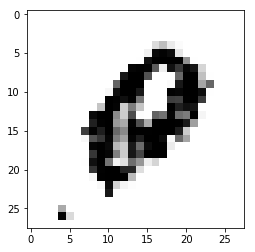

Estimate: [[-94.11723328]]
Iteration: 26100 at 2017-10-12 02:35:59.624709


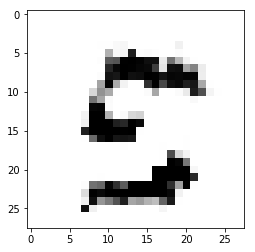

Estimate: [[-25.47165298]]
Iteration: 26200 at 2017-10-12 02:38:27.436186


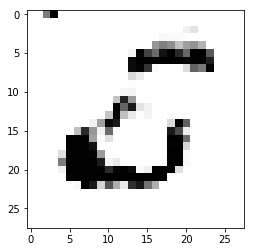

Estimate: [[-34.99912262]]
Iteration: 26300 at 2017-10-12 02:40:55.426447


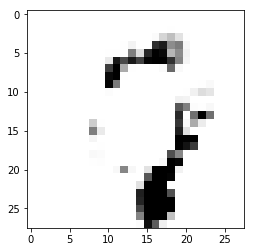

Estimate: [[-57.12485123]]
Iteration: 26400 at 2017-10-12 02:43:23.203598


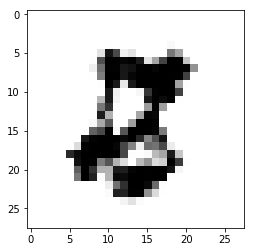

Estimate: [[-58.19882965]]
Iteration: 26500 at 2017-10-12 02:45:50.904921


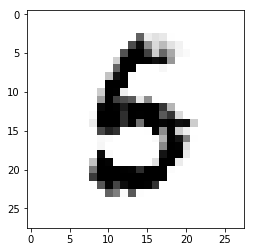

Estimate: [[-25.55522346]]
Iteration: 26600 at 2017-10-12 02:48:18.912387


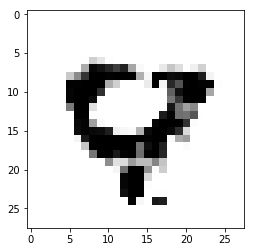

Estimate: [[ 27.87227249]]
Iteration: 26700 at 2017-10-12 02:50:46.423250


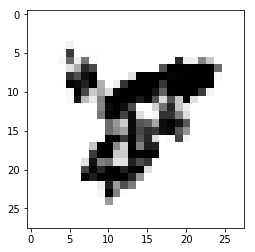

Estimate: [[-21.52522469]]
Iteration: 26800 at 2017-10-12 02:53:14.147995


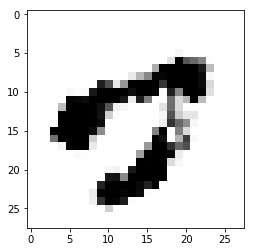

Estimate: [[-6.27416897]]
Iteration: 26900 at 2017-10-12 02:55:41.984893


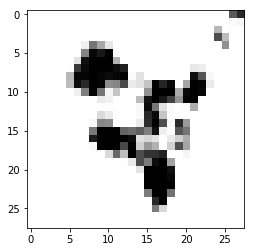

Estimate: [[-33.97940826]]
Iteration: 27000 at 2017-10-12 02:58:10.040696


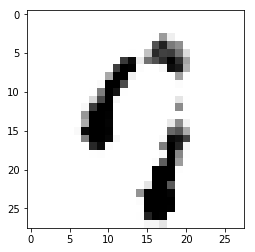

Estimate: [[-44.72846603]]
Iteration: 27100 at 2017-10-12 03:00:37.433008


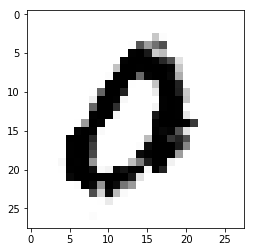

Estimate: [[-54.72051239]]
Iteration: 27200 at 2017-10-12 03:03:05.399744


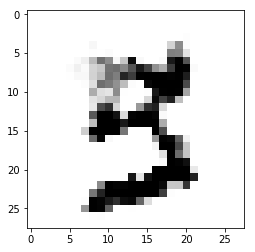

Estimate: [[-79.38583374]]
Iteration: 27300 at 2017-10-12 03:05:33.184330


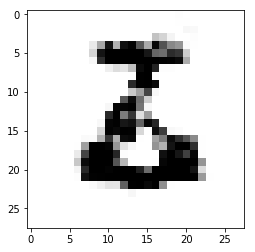

Estimate: [[-32.38420868]]
Iteration: 27400 at 2017-10-12 03:08:01.042812


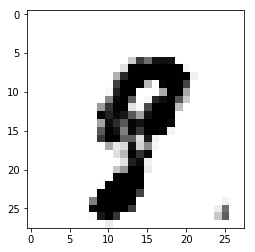

Estimate: [[-41.76101685]]
Iteration: 27500 at 2017-10-12 03:10:28.960993


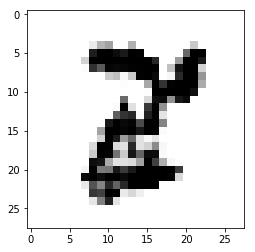

Estimate: [[-40.90638351]]
Iteration: 27600 at 2017-10-12 03:12:56.412345


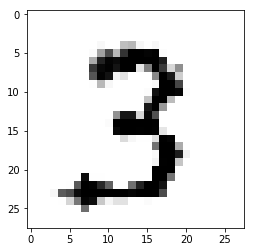

Estimate: [[-39.03033447]]
Iteration: 27700 at 2017-10-12 03:15:24.558367


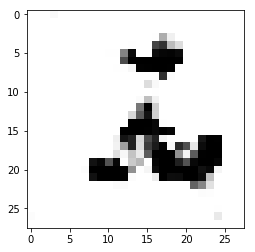

Estimate: [[-8.33113289]]
Iteration: 27800 at 2017-10-12 03:17:52.259244


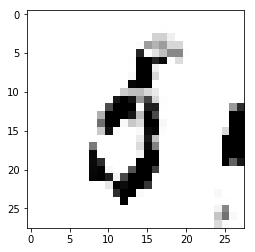

Estimate: [[ 17.69647408]]
Iteration: 27900 at 2017-10-12 03:20:19.792076


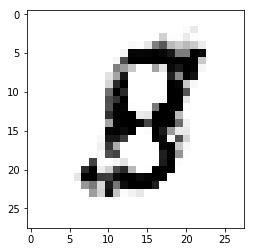

Estimate: [[-13.07167912]]
Iteration: 28000 at 2017-10-12 03:22:47.732667


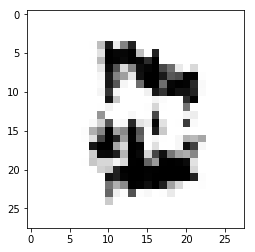

Estimate: [[-66.81015015]]
Iteration: 28100 at 2017-10-12 03:25:15.589502


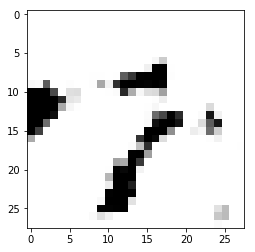

Estimate: [[ 11.02227592]]
Iteration: 28200 at 2017-10-12 03:27:43.161990


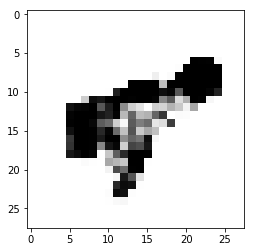

Estimate: [[-13.97942734]]
Iteration: 28300 at 2017-10-12 03:30:10.983225


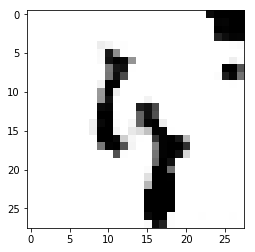

Estimate: [[ 35.4665451]]
Iteration: 28400 at 2017-10-12 03:32:38.836060


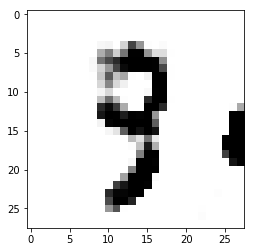

Estimate: [[-40.91666031]]
Iteration: 28500 at 2017-10-12 03:35:06.445178


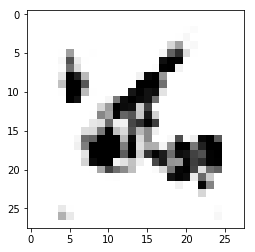

Estimate: [[ 9.4420557]]
Iteration: 28600 at 2017-10-12 03:37:34.517681


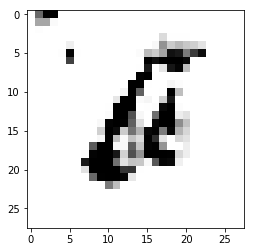

Estimate: [[-32.86256027]]
Iteration: 28700 at 2017-10-12 03:40:02.366769


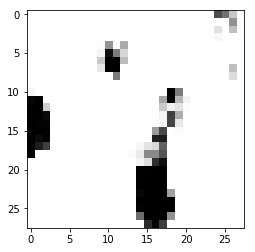

Estimate: [[ 138.3682251]]
Iteration: 28800 at 2017-10-12 03:42:30.559947


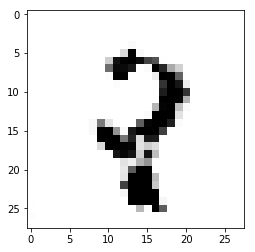

Estimate: [[-29.3157177]]
Iteration: 28900 at 2017-10-12 03:44:58.322954


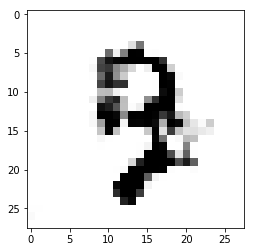

Estimate: [[-29.73272133]]
Iteration: 29000 at 2017-10-12 03:47:26.213337


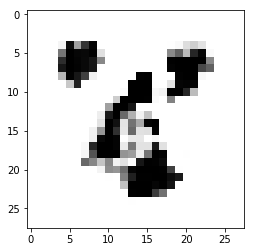

Estimate: [[-38.29636765]]
Iteration: 29100 at 2017-10-12 03:49:54.058883


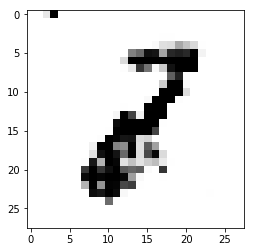

Estimate: [[-21.5857811]]
Iteration: 29200 at 2017-10-12 03:52:21.731403


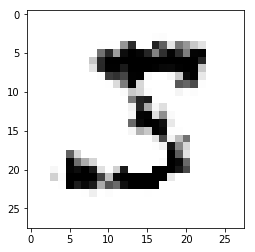

Estimate: [[-37.46996689]]
Iteration: 29300 at 2017-10-12 03:54:49.735756


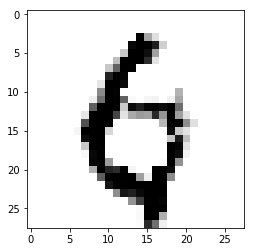

Estimate: [[-49.15332413]]
Iteration: 29400 at 2017-10-12 03:57:17.258851


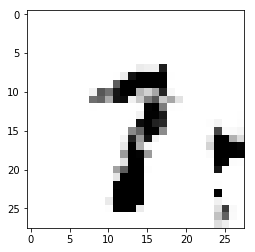

Estimate: [[ 17.49034691]]
Iteration: 29500 at 2017-10-12 03:59:45.736723


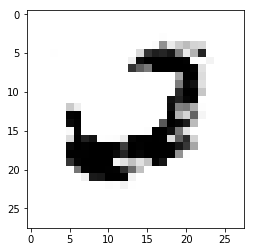

Estimate: [[-26.86322784]]
Iteration: 29600 at 2017-10-12 04:02:13.824363


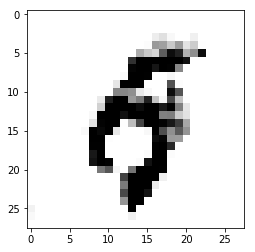

Estimate: [[ 33.07802582]]
Iteration: 29700 at 2017-10-12 04:04:41.519819


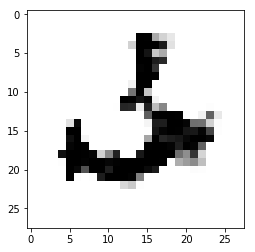

Estimate: [[-5.66352272]]
Iteration: 29800 at 2017-10-12 04:07:09.276258


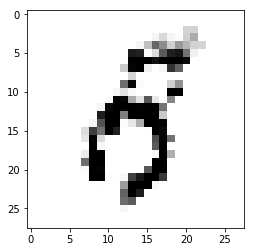

Estimate: [[-34.64190674]]
Iteration: 29900 at 2017-10-12 04:09:37.330151


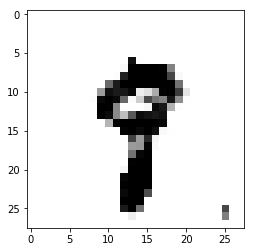

Estimate: [[-50.19817352]]
Iteration: 30000 at 2017-10-12 04:12:04.978875


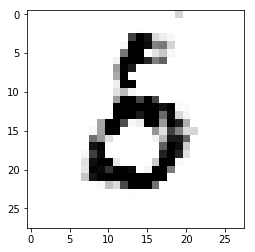

Estimate: [[-6.25162888]]
Iteration: 30100 at 2017-10-12 04:14:33.400835


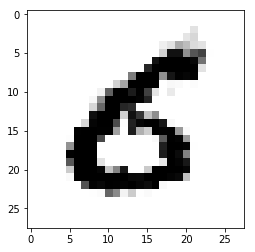

Estimate: [[-37.0251503]]
Iteration: 30200 at 2017-10-12 04:17:01.485744


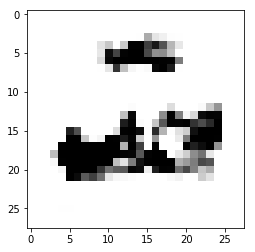

Estimate: [[ 49.81689835]]
Iteration: 30300 at 2017-10-12 04:19:29.416110


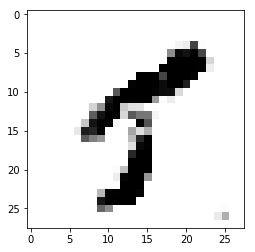

Estimate: [[-6.94819689]]
Iteration: 30400 at 2017-10-12 04:21:57.259439


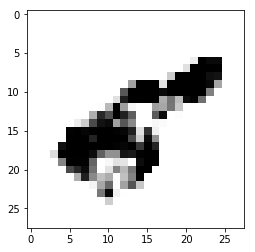

Estimate: [[ 40.6099205]]
Iteration: 30500 at 2017-10-12 04:24:25.284463


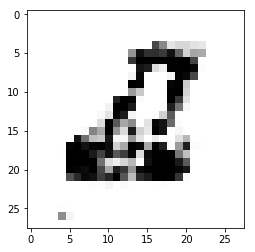

Estimate: [[-94.95195007]]
Iteration: 30600 at 2017-10-12 04:26:53.161872


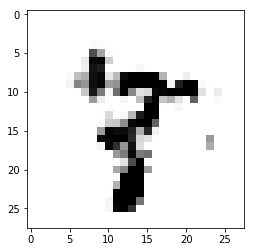

Estimate: [[-69.87941742]]
Iteration: 30700 at 2017-10-12 04:29:21.391076


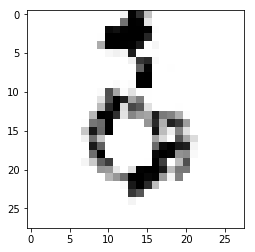

Estimate: [[-105.71141815]]
Iteration: 30800 at 2017-10-12 04:31:49.448552


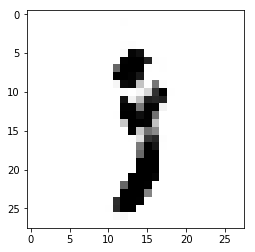

Estimate: [[-52.78614807]]
Iteration: 30900 at 2017-10-12 04:34:17.789891


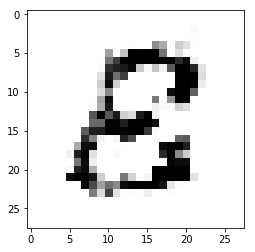

Estimate: [[-34.97275162]]
Iteration: 31000 at 2017-10-12 04:36:47.479893


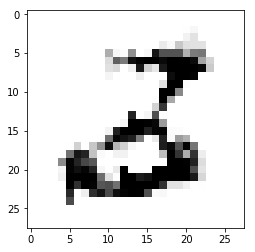

Estimate: [[-22.43028641]]
Iteration: 31100 at 2017-10-12 04:39:15.876731


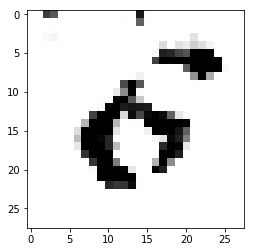

Estimate: [[-62.84151459]]
Iteration: 31200 at 2017-10-12 04:41:43.507691


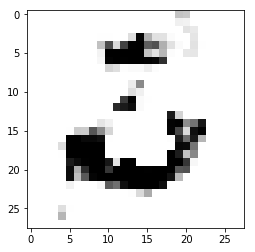

Estimate: [[ 5.32854271]]
Iteration: 31300 at 2017-10-12 04:44:11.289403


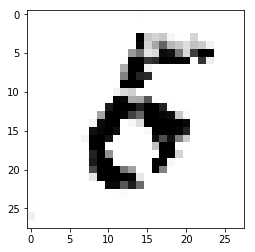

Estimate: [[ 15.574893]]
Iteration: 31400 at 2017-10-12 04:46:39.110180


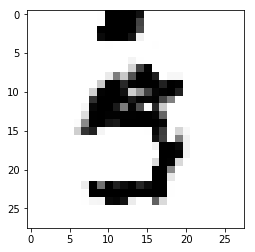

Estimate: [[-22.25616646]]
Iteration: 31500 at 2017-10-12 04:49:06.721108


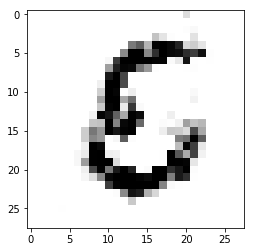

Estimate: [[-32.01486969]]
Iteration: 31600 at 2017-10-12 04:51:34.942126


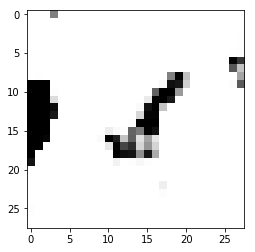

Estimate: [[ 186.00408936]]
Iteration: 31700 at 2017-10-12 04:54:02.823097


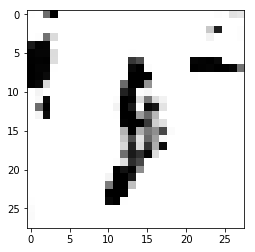

Estimate: [[-87.62763214]]
Iteration: 31800 at 2017-10-12 04:56:30.512994


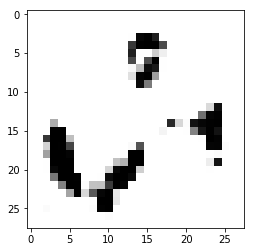

Estimate: [[ 37.44919205]]
Iteration: 31900 at 2017-10-12 04:58:58.610013


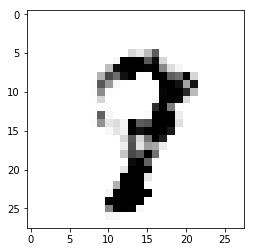

Estimate: [[-92.75386047]]
Iteration: 32000 at 2017-10-12 05:01:27.646376


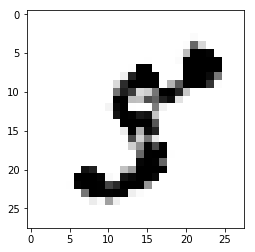

Estimate: [[ 30.31567574]]
Iteration: 32100 at 2017-10-12 05:03:55.842683


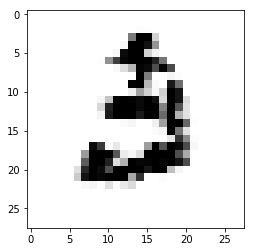

Estimate: [[-11.43284225]]
Iteration: 32200 at 2017-10-12 05:06:25.831427


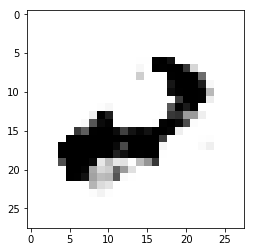

Estimate: [[-24.45592117]]
Iteration: 32300 at 2017-10-12 05:08:54.297934


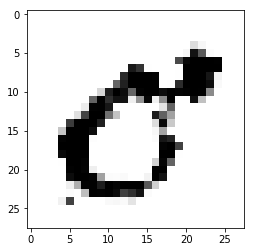

Estimate: [[ 48.75716019]]
Iteration: 32400 at 2017-10-12 05:11:24.421707


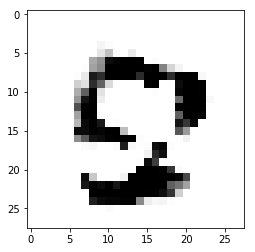

Estimate: [[-39.77656555]]
Iteration: 32500 at 2017-10-12 05:13:52.304404


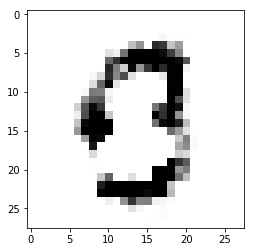

Estimate: [[-62.0078125]]
Iteration: 32600 at 2017-10-12 05:16:20.184753


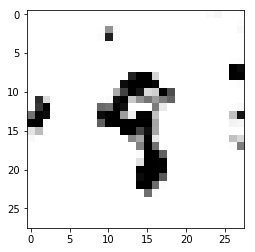

Estimate: [[-84.16684723]]
Iteration: 32700 at 2017-10-12 05:18:48.033285


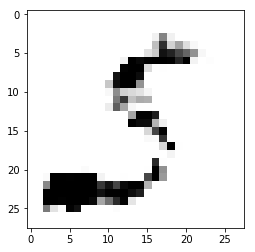

Estimate: [[-22.30689621]]
Iteration: 32800 at 2017-10-12 05:21:16.748246


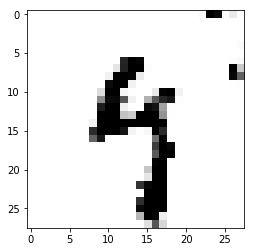

Estimate: [[-23.77112579]]
Iteration: 32900 at 2017-10-12 05:23:44.829400


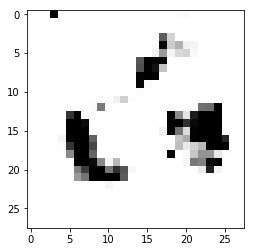

Estimate: [[ 20.84465027]]
Iteration: 33000 at 2017-10-12 05:26:12.839989


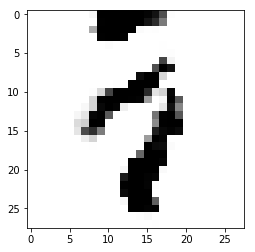

Estimate: [[ 55.49084091]]
Iteration: 33100 at 2017-10-12 05:28:40.657560


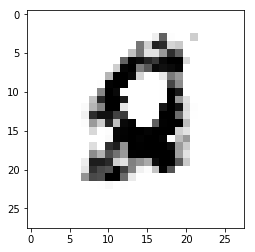

Estimate: [[-20.2728157]]
Iteration: 33200 at 2017-10-12 05:31:08.622366


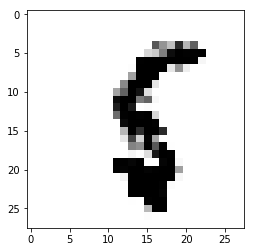

Estimate: [[-5.24706173]]
Iteration: 33300 at 2017-10-12 05:33:36.916024


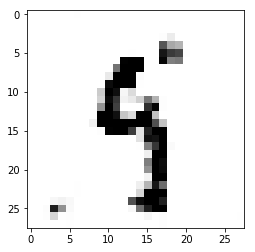

Estimate: [[-90.76189423]]
Iteration: 33400 at 2017-10-12 05:36:05.116684


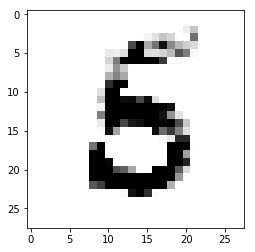

Estimate: [[ 4.49657869]]
Iteration: 33500 at 2017-10-12 05:38:33.227395


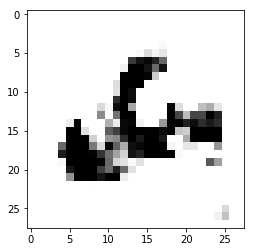

Estimate: [[-50.98009872]]
Iteration: 33600 at 2017-10-12 05:41:01.158493


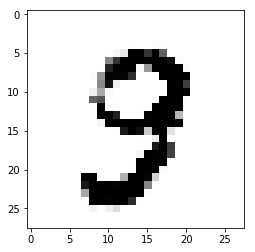

Estimate: [[-16.72906303]]
Iteration: 33700 at 2017-10-12 05:43:29.415101


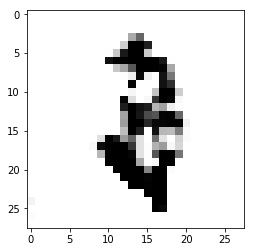

Estimate: [[-130.20996094]]
Iteration: 33800 at 2017-10-12 05:45:57.764099


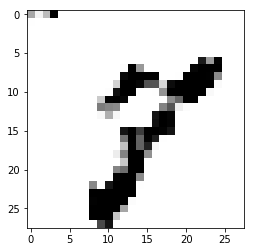

Estimate: [[ 7.24831676]]
Iteration: 33900 at 2017-10-12 05:48:25.816545


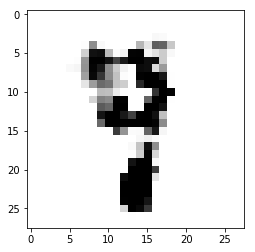

Estimate: [[-40.36279678]]
Iteration: 34000 at 2017-10-12 05:50:54.003606


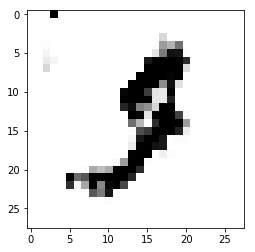

Estimate: [[-127.99025726]]
Iteration: 34100 at 2017-10-12 05:53:22.017196


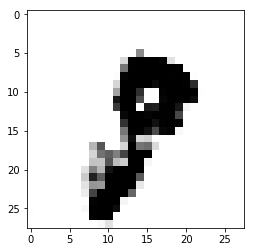

Estimate: [[-84.43274689]]
Iteration: 34200 at 2017-10-12 05:55:49.893036


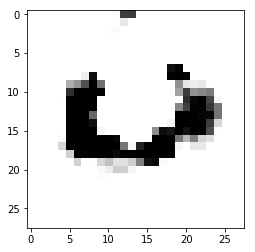

Estimate: [[-6.0085578]]
Iteration: 34300 at 2017-10-12 05:58:18.193297


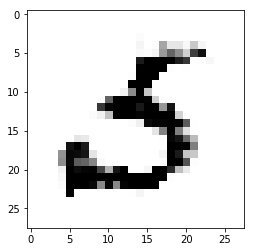

Estimate: [[-31.2666893]]
Iteration: 34400 at 2017-10-12 06:00:46.422958


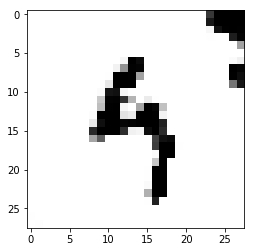

Estimate: [[-8.05247402]]
Iteration: 34500 at 2017-10-12 06:03:14.866634


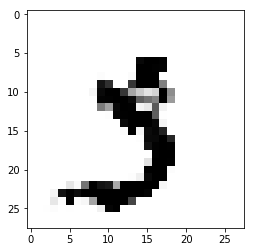

Estimate: [[-62.59719849]]
Iteration: 34600 at 2017-10-12 06:05:42.848826


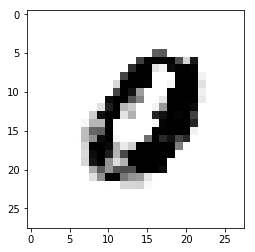

Estimate: [[-56.47356796]]
Iteration: 34700 at 2017-10-12 06:08:10.858294


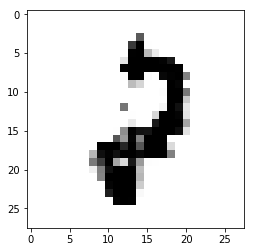

Estimate: [[-119.62688446]]
Iteration: 34800 at 2017-10-12 06:10:39.198978


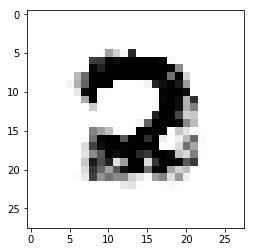

Estimate: [[-97.04598999]]
Iteration: 34900 at 2017-10-12 06:13:07.233428


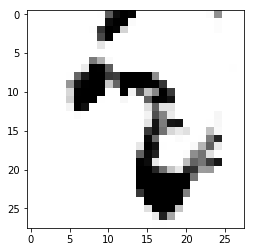

Estimate: [[-32.41484451]]
Iteration: 35000 at 2017-10-12 06:15:36.347310


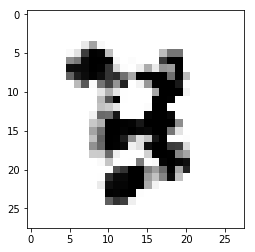

Estimate: [[-6.67789078]]
Iteration: 35100 at 2017-10-12 06:18:04.736597


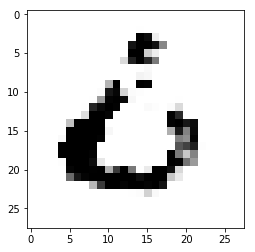

Estimate: [[-22.99907112]]
Iteration: 35200 at 2017-10-12 06:20:33.109086


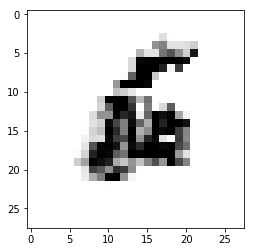

Estimate: [[ 6.22534609]]
Iteration: 35300 at 2017-10-12 06:23:01.726248


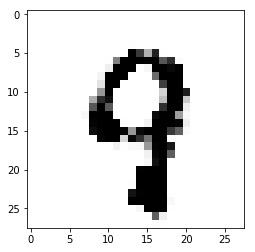

Estimate: [[-44.32532501]]
Iteration: 35400 at 2017-10-12 06:25:29.829906


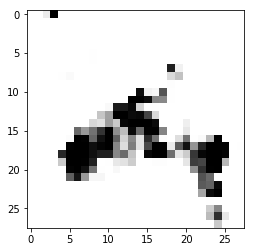

Estimate: [[-94.24649048]]
Iteration: 35500 at 2017-10-12 06:27:57.851054


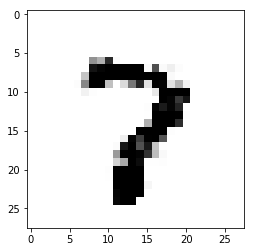

Estimate: [[-47.8499794]]
Iteration: 35600 at 2017-10-12 06:30:26.098657


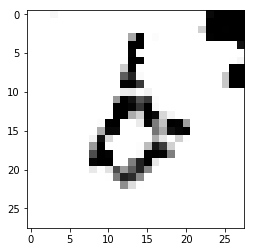

Estimate: [[ 27.59607887]]
Iteration: 35700 at 2017-10-12 06:32:54.439008


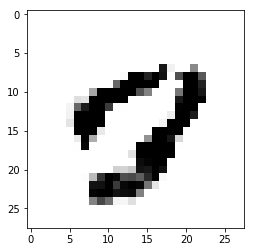

Estimate: [[ 13.87764645]]
Iteration: 35800 at 2017-10-12 06:35:23.519424


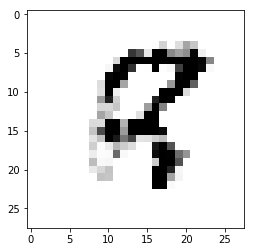

Estimate: [[ 42.13299179]]
Iteration: 35900 at 2017-10-12 06:37:51.621113


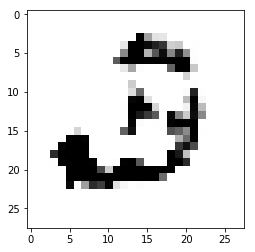

Estimate: [[-64.60488129]]
Iteration: 36000 at 2017-10-12 06:40:19.491909


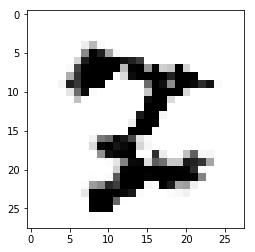

Estimate: [[-99.84153748]]
Iteration: 36100 at 2017-10-12 06:42:47.424635


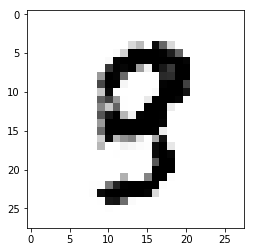

Estimate: [[-111.7688446]]
Iteration: 36200 at 2017-10-12 06:45:15.501746


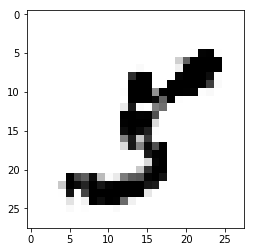

Estimate: [[-43.60565186]]
Iteration: 36300 at 2017-10-12 06:47:43.331987


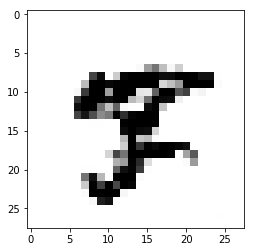

Estimate: [[-69.59925842]]
Iteration: 36400 at 2017-10-12 06:50:11.773149


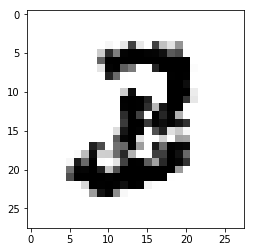

Estimate: [[-1.84721291]]
Iteration: 36500 at 2017-10-12 06:52:39.711825


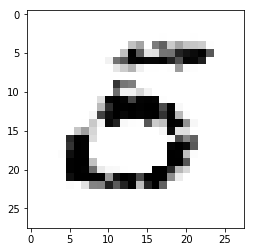

Estimate: [[-31.52036667]]
Iteration: 36600 at 2017-10-12 06:55:07.845809


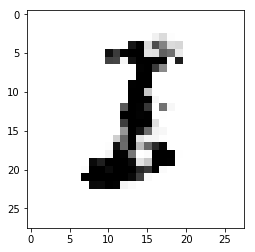

Estimate: [[-52.41649628]]
Iteration: 36700 at 2017-10-12 06:57:36.769475


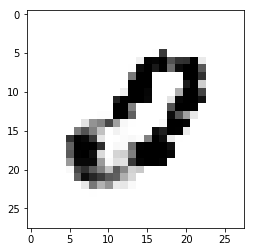

Estimate: [[-41.96446991]]
Iteration: 36800 at 2017-10-12 07:00:04.948742


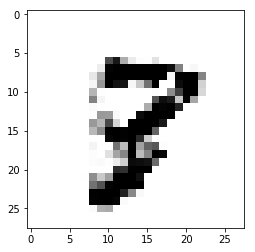

Estimate: [[-86.79290771]]
Iteration: 36900 at 2017-10-12 07:02:33.360472


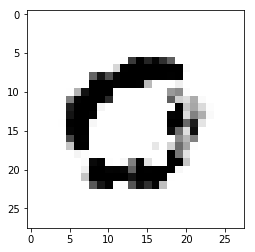

Estimate: [[-20.25083923]]
Iteration: 37000 at 2017-10-12 07:05:01.554465


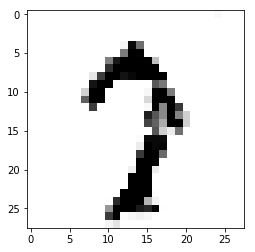

Estimate: [[-10.77701187]]
Iteration: 37100 at 2017-10-12 07:07:29.738029


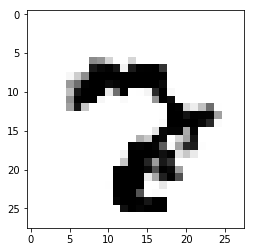

Estimate: [[ 19.87182808]]
Iteration: 37200 at 2017-10-12 07:09:58.075492


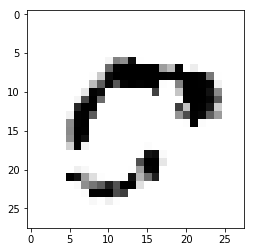

Estimate: [[-77.56226349]]
Iteration: 37300 at 2017-10-12 07:12:26.062200


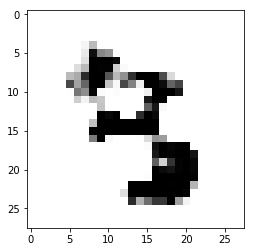

Estimate: [[-14.87047482]]
Iteration: 37400 at 2017-10-12 07:14:54.466370


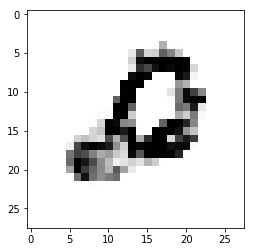

Estimate: [[ 10.84296703]]
Iteration: 37500 at 2017-10-12 07:17:23.122991


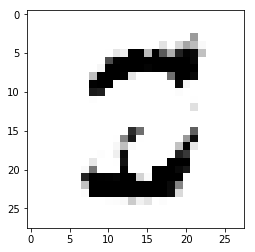

Estimate: [[-56.98227692]]
Iteration: 37600 at 2017-10-12 07:19:51.211682


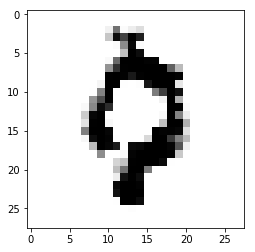

Estimate: [[-42.74816132]]
Iteration: 37700 at 2017-10-12 07:22:19.168917


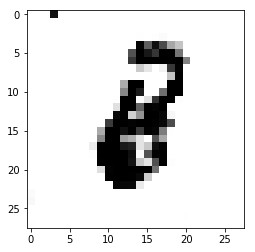

Estimate: [[-64.00154877]]
Iteration: 37800 at 2017-10-12 07:24:47.376442


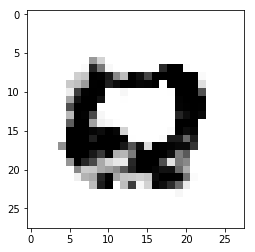

Estimate: [[-131.37019348]]
Iteration: 37900 at 2017-10-12 07:27:15.603183


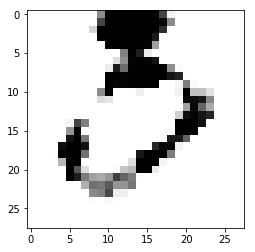

Estimate: [[-214.70698547]]
Iteration: 38000 at 2017-10-12 07:29:43.766519


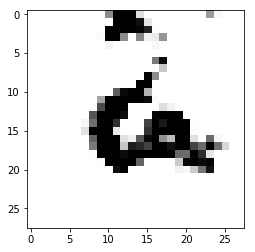

Estimate: [[-89.11693573]]
Iteration: 38100 at 2017-10-12 07:32:11.853675


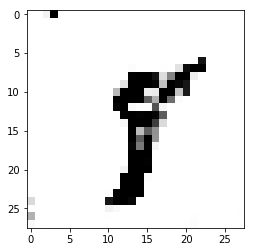

Estimate: [[-95.43335724]]
Iteration: 38200 at 2017-10-12 07:34:40.165727


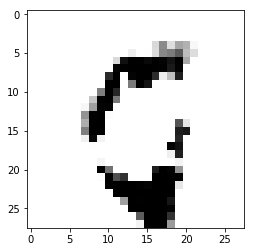

Estimate: [[ 59.02637482]]
Iteration: 38300 at 2017-10-12 07:37:08.076668


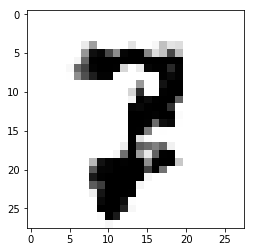

Estimate: [[-100.45050049]]
Iteration: 38400 at 2017-10-12 07:39:36.419544


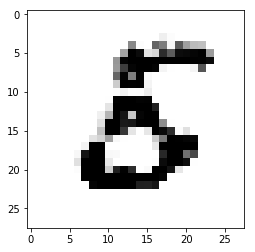

Estimate: [[-36.39536667]]
Iteration: 38500 at 2017-10-12 07:42:04.536828


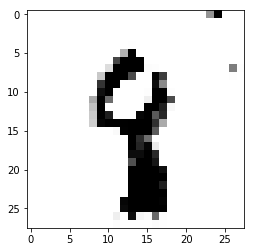

Estimate: [[-85.38170624]]
Iteration: 38600 at 2017-10-12 07:44:33.021685


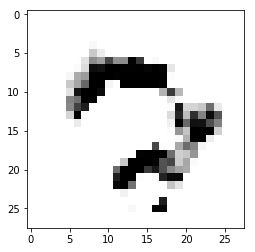

Estimate: [[-27.43311501]]
Iteration: 38700 at 2017-10-12 07:47:01.991576


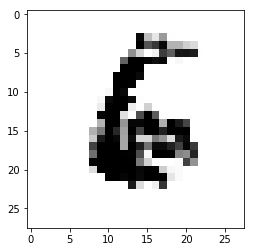

Estimate: [[ 22.12457466]]
Iteration: 38800 at 2017-10-12 07:49:30.138681


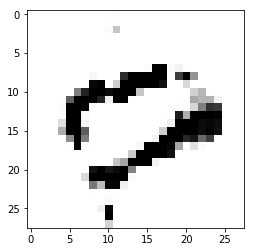

Estimate: [[-34.88912201]]
Iteration: 38900 at 2017-10-12 07:51:58.360319


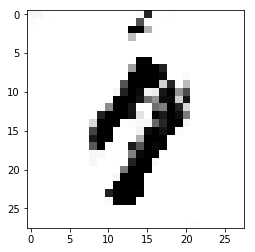

Estimate: [[-74.35009766]]
Iteration: 39000 at 2017-10-12 07:54:26.971860


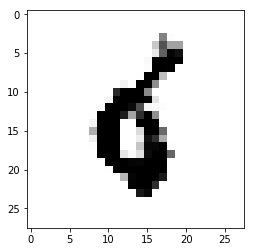

Estimate: [[-23.57287407]]
Iteration: 39100 at 2017-10-12 07:56:55.474862


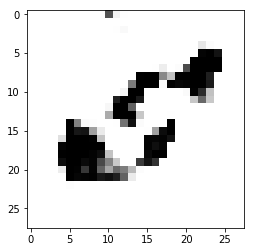

Estimate: [[-23.10466766]]
Iteration: 39200 at 2017-10-12 07:59:23.909815


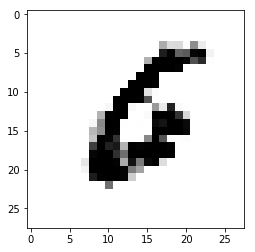

Estimate: [[-35.70103455]]
Iteration: 39300 at 2017-10-12 08:01:52.665017


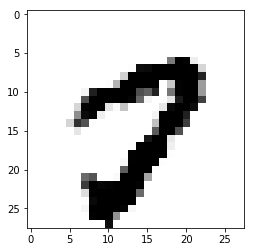

Estimate: [[-94.17643738]]
Iteration: 39400 at 2017-10-12 08:04:20.927483


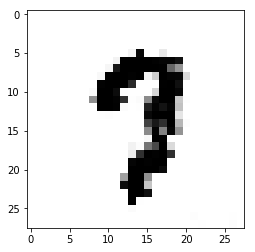

Estimate: [[-89.57981873]]
Iteration: 39500 at 2017-10-12 08:06:49.425327


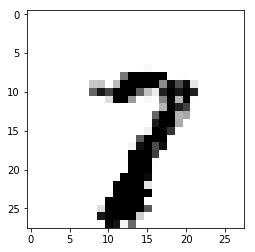

Estimate: [[ 33.32844543]]
Iteration: 39600 at 2017-10-12 08:09:17.850365


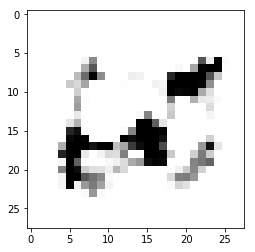

Estimate: [[-91.10974121]]
Iteration: 39700 at 2017-10-12 08:11:46.957212


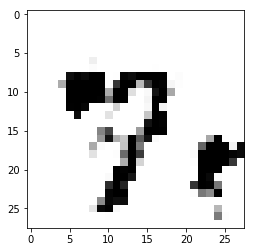

Estimate: [[ 54.6631279]]
Iteration: 39800 at 2017-10-12 08:14:15.650790


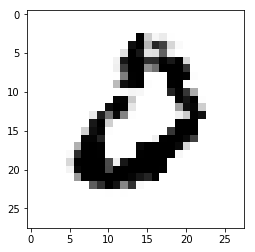

Estimate: [[-86.1607132]]
Iteration: 39900 at 2017-10-12 08:16:44.357379


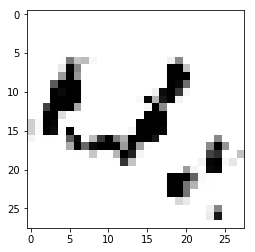

Estimate: [[-135.61108398]]
Iteration: 40000 at 2017-10-12 08:19:12.648077


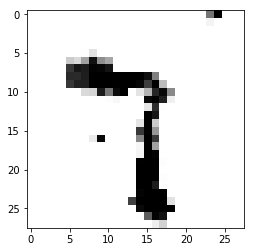

Estimate: [[-6.74902678]]
Iteration: 40100 at 2017-10-12 08:21:41.167414


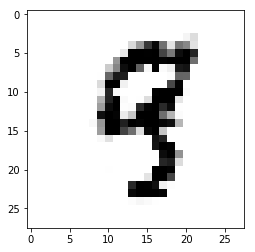

Estimate: [[-9.42538643]]
Iteration: 40200 at 2017-10-12 08:24:09.822850


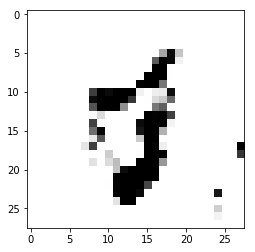

Estimate: [[-33.62056351]]
Iteration: 40300 at 2017-10-12 08:26:37.940270


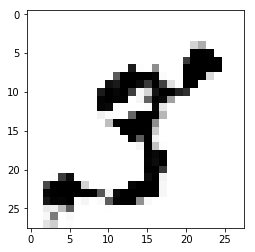

Estimate: [[-92.00757599]]
Iteration: 40400 at 2017-10-12 08:29:06.185590


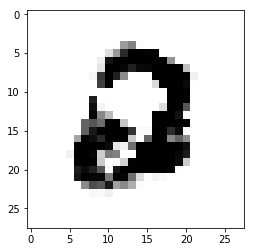

Estimate: [[-61.63877106]]
Iteration: 40500 at 2017-10-12 08:31:34.744002


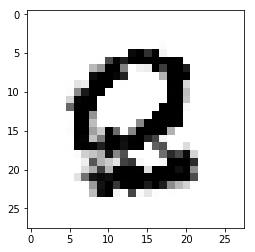

Estimate: [[-18.26576424]]
Iteration: 40600 at 2017-10-12 08:34:03.278752


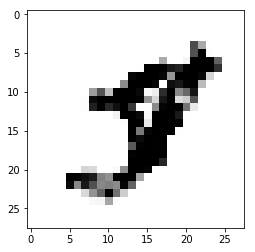

Estimate: [[ 63.46872711]]
Iteration: 40700 at 2017-10-12 08:36:31.463381


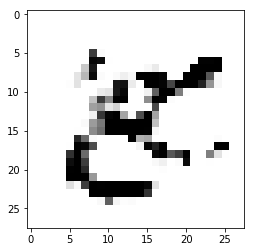

Estimate: [[-54.30496597]]
Iteration: 40800 at 2017-10-12 08:39:00.085555


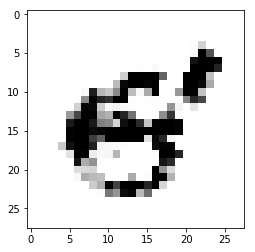

Estimate: [[ 5.13021374]]
Iteration: 40900 at 2017-10-12 08:41:28.523498


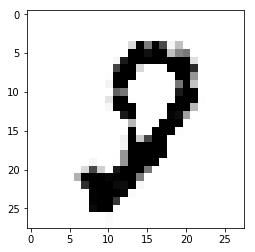

Estimate: [[ 17.32389641]]
Iteration: 41000 at 2017-10-12 08:43:57.049132


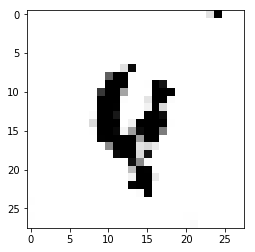

Estimate: [[-9.85969543]]
Iteration: 41100 at 2017-10-12 08:46:25.498647


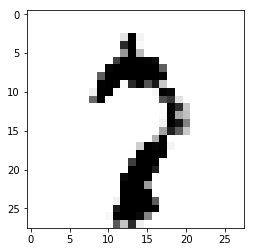

Estimate: [[-10.53619766]]
Iteration: 41200 at 2017-10-12 08:48:54.016106


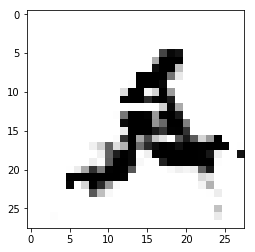

Estimate: [[-51.00998306]]
Iteration: 41300 at 2017-10-12 08:51:22.662712


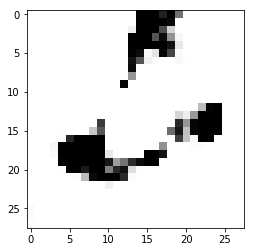

Estimate: [[-94.98583221]]
Iteration: 41400 at 2017-10-12 08:53:50.952940


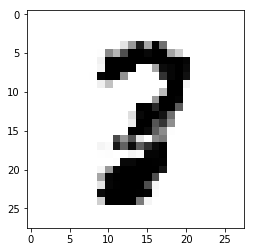

Estimate: [[-22.0757103]]
Iteration: 41500 at 2017-10-12 08:56:19.669576


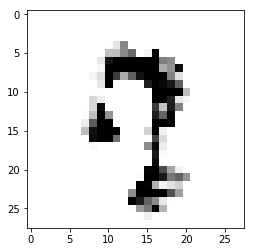

Estimate: [[-50.37251663]]
Iteration: 41600 at 2017-10-12 08:58:47.727844


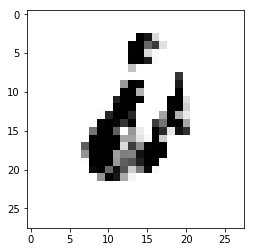

Estimate: [[-37.86751938]]
Iteration: 41700 at 2017-10-12 09:01:16.192715


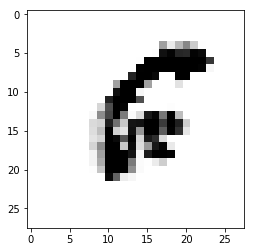

Estimate: [[ 4.57535744]]
Iteration: 41800 at 2017-10-12 09:03:44.847528


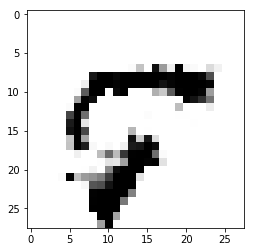

Estimate: [[-64.94369507]]
Iteration: 41900 at 2017-10-12 09:06:13.662833


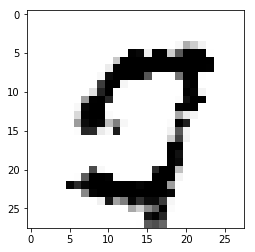

Estimate: [[-124.07647705]]
Iteration: 42000 at 2017-10-12 09:08:42.061778


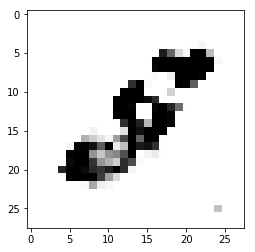

Estimate: [[-54.40262222]]
Iteration: 42100 at 2017-10-12 09:11:10.365840


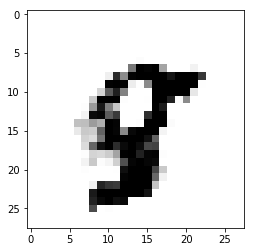

Estimate: [[-49.09721756]]
Iteration: 42200 at 2017-10-12 09:13:38.973559


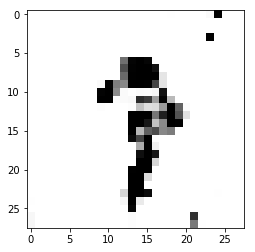

Estimate: [[-76.6591568]]
Iteration: 42300 at 2017-10-12 09:16:07.456433


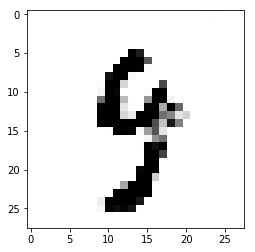

Estimate: [[ 6.37505722]]
Iteration: 42400 at 2017-10-12 09:18:35.995401


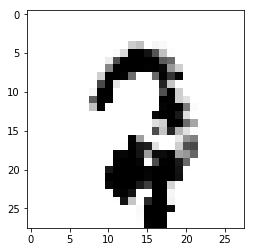

Estimate: [[-219.31332397]]
Iteration: 42500 at 2017-10-12 09:21:04.302572


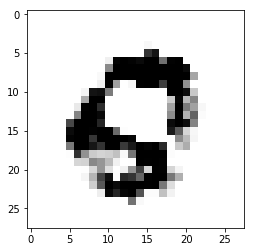

Estimate: [[-55.48101044]]
Iteration: 42600 at 2017-10-12 09:23:32.914568


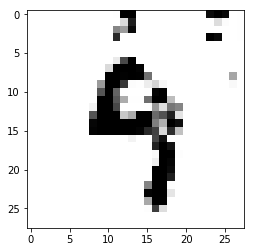

Estimate: [[-43.39879608]]
Iteration: 42700 at 2017-10-12 09:26:01.490386


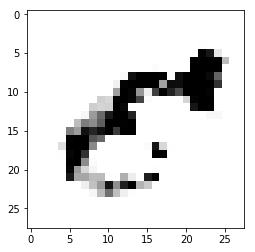

Estimate: [[ 23.87985039]]
Iteration: 42800 at 2017-10-12 09:28:30.243335


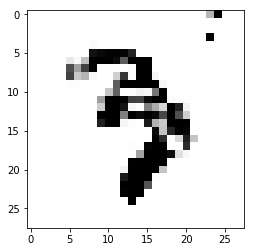

Estimate: [[-67.07023621]]
Iteration: 42900 at 2017-10-12 09:30:58.610606


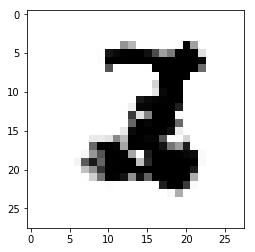

Estimate: [[-137.16235352]]
Iteration: 43000 at 2017-10-12 09:33:27.368309


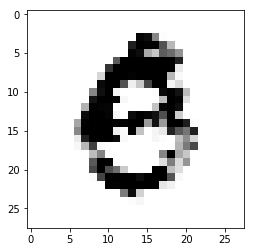

Estimate: [[-133.01332092]]
Iteration: 43100 at 2017-10-12 09:35:55.941779


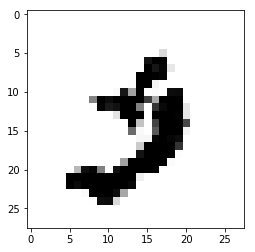

Estimate: [[-11.88086987]]
Iteration: 43200 at 2017-10-12 09:38:24.549150


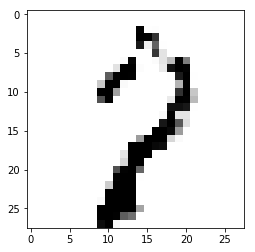

Estimate: [[-58.02342224]]
Iteration: 43300 at 2017-10-12 09:40:52.801097


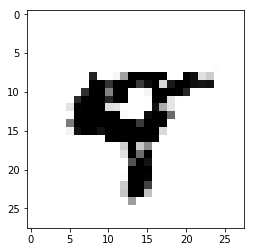

Estimate: [[-13.16799068]]
Iteration: 43400 at 2017-10-12 09:43:21.503276


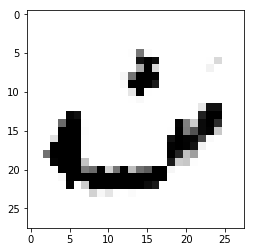

Estimate: [[-72.83035278]]
Iteration: 43500 at 2017-10-12 09:45:50.111679


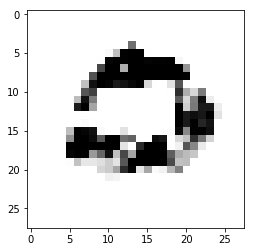

Estimate: [[-91.66608429]]
Iteration: 43600 at 2017-10-12 09:48:19.038826


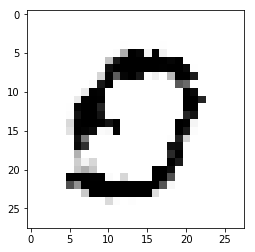

Estimate: [[-64.05860901]]
Iteration: 43700 at 2017-10-12 09:50:47.894769


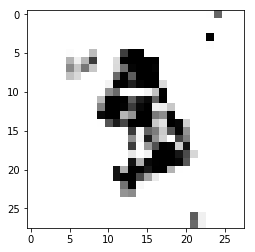

Estimate: [[-86.56529999]]
Iteration: 43800 at 2017-10-12 09:53:16.370272


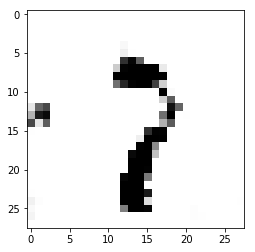

Estimate: [[-95.52919769]]
Iteration: 43900 at 2017-10-12 09:55:44.931305


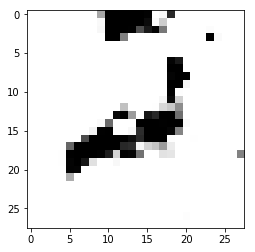

Estimate: [[ 70.03552246]]
Iteration: 44000 at 2017-10-12 09:58:14.503106


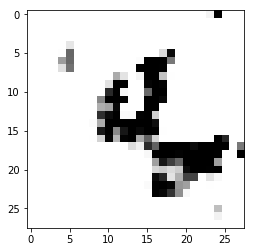

Estimate: [[-48.63386917]]
Iteration: 44100 at 2017-10-12 10:00:43.301534


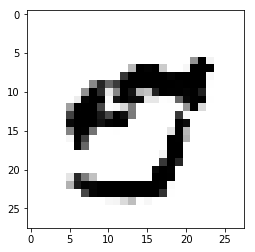

Estimate: [[-23.7010498]]
Iteration: 44200 at 2017-10-12 10:03:12.048921


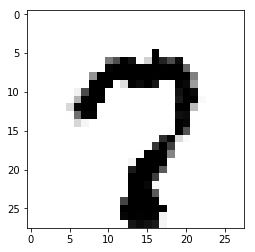

Estimate: [[ 16.40940857]]
Iteration: 44300 at 2017-10-12 10:05:40.852459


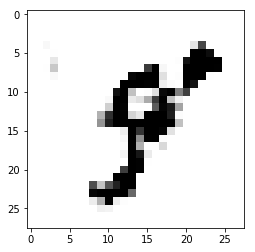

Estimate: [[-30.59342003]]
Iteration: 44400 at 2017-10-12 10:08:09.575045


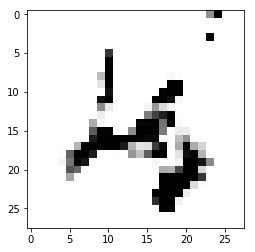

Estimate: [[ 26.26326561]]
Iteration: 44500 at 2017-10-12 10:10:38.609328


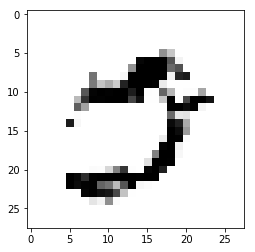

Estimate: [[-63.45911026]]
Iteration: 44600 at 2017-10-12 10:13:07.210775


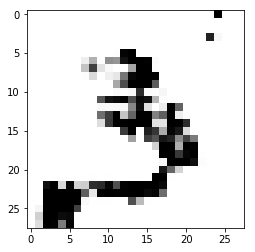

Estimate: [[-54.34061813]]
Iteration: 44700 at 2017-10-12 10:15:38.718016


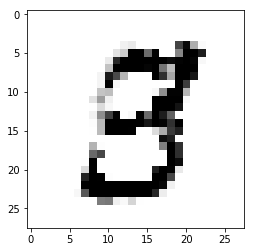

Estimate: [[-17.04261398]]
Iteration: 44800 at 2017-10-12 10:18:07.603314


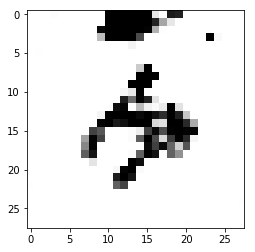

Estimate: [[ 10.23808479]]
Iteration: 44900 at 2017-10-12 10:20:36.301421


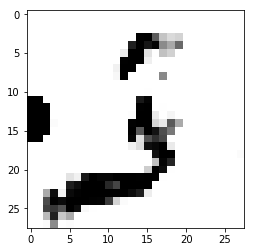

Estimate: [[-17.15432739]]
Iteration: 45000 at 2017-10-12 10:23:05.144476


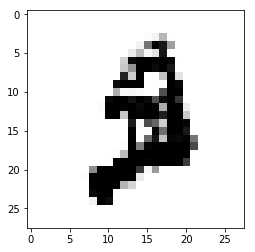

Estimate: [[-38.50081635]]
Iteration: 45100 at 2017-10-12 10:25:34.041723


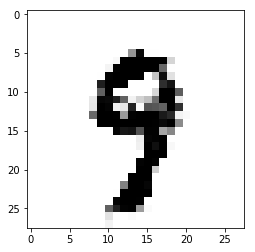

Estimate: [[-64.98551941]]
Iteration: 45200 at 2017-10-12 10:28:02.635159


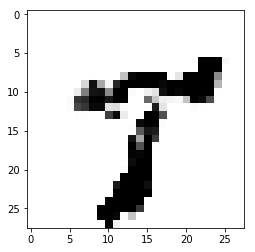

Estimate: [[-24.91670418]]
Iteration: 45300 at 2017-10-12 10:30:31.416320


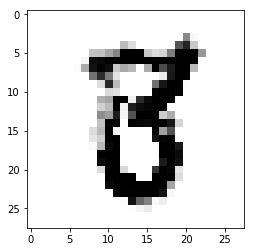

Estimate: [[-45.39645767]]
Iteration: 45400 at 2017-10-12 10:33:00.029462


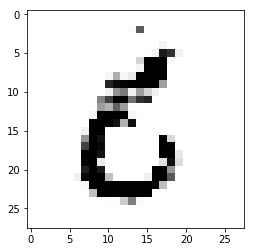

Estimate: [[ 19.90431976]]
Iteration: 45500 at 2017-10-12 10:35:29.467159


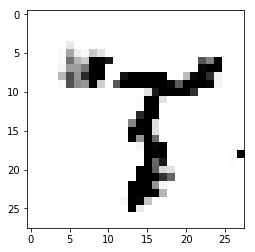

Estimate: [[ 15.22136784]]
Iteration: 45600 at 2017-10-12 10:37:58.347102


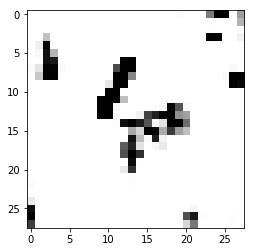

Estimate: [[-122.71705627]]
Iteration: 45700 at 2017-10-12 10:40:27.119315


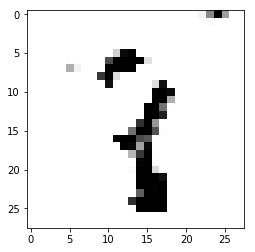

Estimate: [[-75.5484848]]
Iteration: 45800 at 2017-10-12 10:42:56.072458


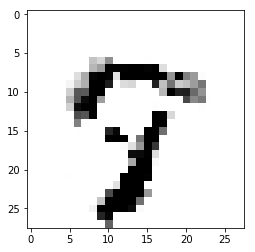

Estimate: [[-102.17144012]]
Iteration: 45900 at 2017-10-12 10:45:26.093761


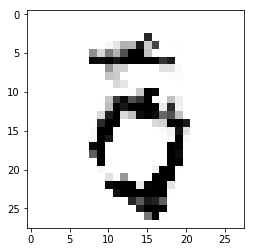

Estimate: [[-51.00449371]]
Iteration: 46000 at 2017-10-12 10:47:59.843232


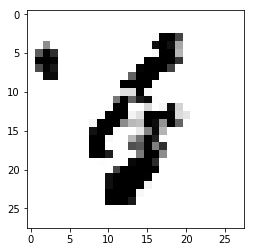

Estimate: [[-67.23455811]]
Iteration: 46100 at 2017-10-12 10:50:33.120618


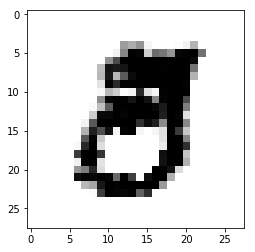

Estimate: [[-72.69495392]]
Iteration: 46200 at 2017-10-12 10:53:05.900843


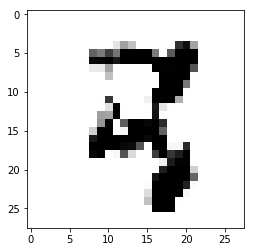

Estimate: [[-20.82294655]]
Iteration: 46300 at 2017-10-12 10:55:45.419411


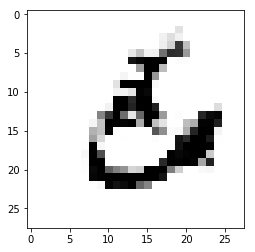

Estimate: [[-95.49234772]]
Iteration: 46400 at 2017-10-12 10:58:24.550942


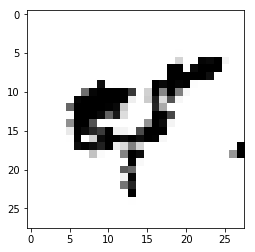

Estimate: [[-95.24219513]]
Iteration: 46500 at 2017-10-12 11:01:00.840986


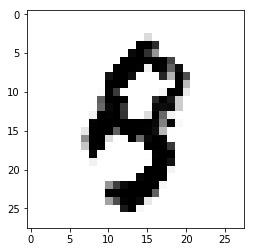

Estimate: [[-36.20689392]]
Iteration: 46600 at 2017-10-12 11:03:37.569508


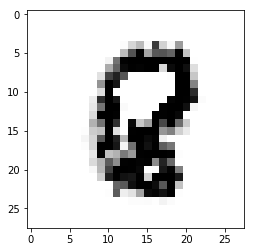

Estimate: [[-61.20841599]]
Iteration: 46700 at 2017-10-12 11:06:10.559746


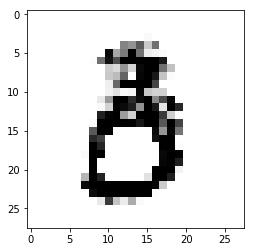

Estimate: [[-132.33860779]]
Iteration: 46800 at 2017-10-12 11:08:44.746487


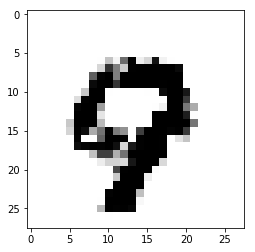

Estimate: [[-70.03325653]]
Iteration: 46900 at 2017-10-12 11:11:23.207412


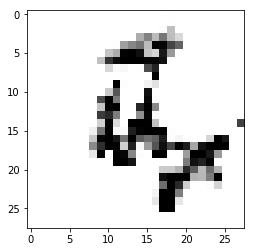

Estimate: [[-65.35211945]]
Iteration: 47000 at 2017-10-12 11:13:58.427210


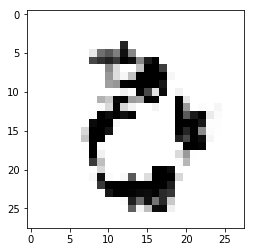

Estimate: [[ 5.22020483]]
Iteration: 47100 at 2017-10-12 11:16:32.717156


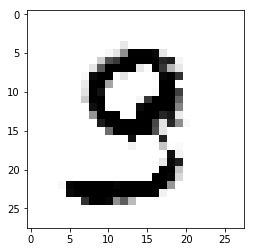

Estimate: [[-49.24907303]]
Iteration: 47200 at 2017-10-12 11:19:06.226147


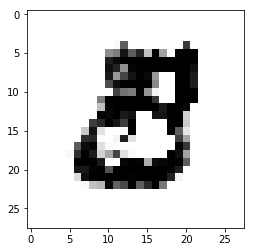

Estimate: [[-186.81178284]]
Iteration: 47300 at 2017-10-12 11:21:38.618727


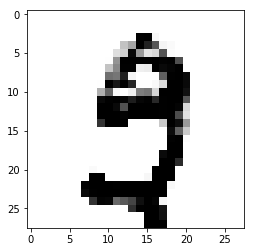

Estimate: [[ 61.58850098]]
Iteration: 47400 at 2017-10-12 11:24:20.053334


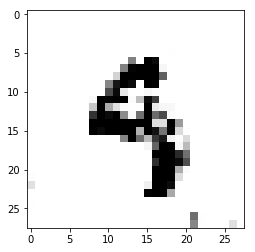

Estimate: [[-17.86310577]]
Iteration: 47500 at 2017-10-12 11:26:59.023855


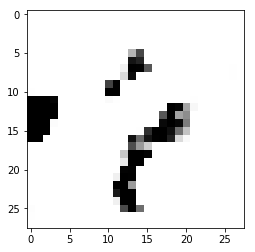

Estimate: [[ 76.79629517]]
Iteration: 47600 at 2017-10-12 11:29:33.397348


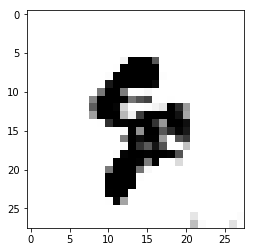

Estimate: [[-181.00798035]]
Iteration: 47700 at 2017-10-12 11:32:07.834863


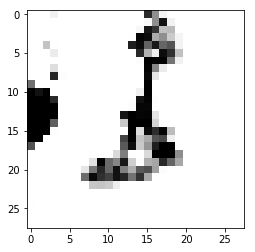

Estimate: [[-54.09404373]]
Iteration: 47800 at 2017-10-12 11:34:41.957717


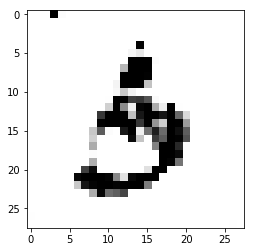

Estimate: [[ 7.73665571]]
Iteration: 47900 at 2017-10-12 11:37:20.528070


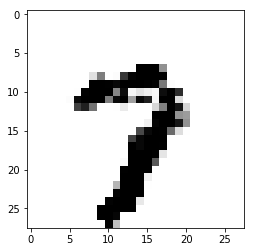

Estimate: [[-21.92321587]]
Iteration: 48000 at 2017-10-12 11:39:52.785297


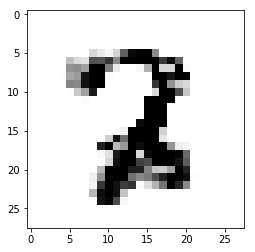

Estimate: [[-19.51702309]]
Iteration: 48100 at 2017-10-12 11:42:31.727056


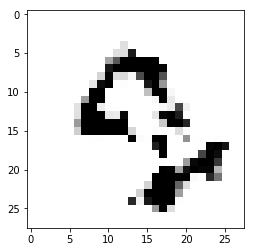

Estimate: [[-75.42475891]]
Iteration: 48200 at 2017-10-12 11:45:05.517559


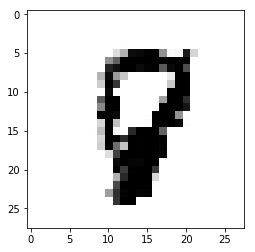

Estimate: [[-71.48673248]]
Iteration: 48300 at 2017-10-12 11:47:42.180465


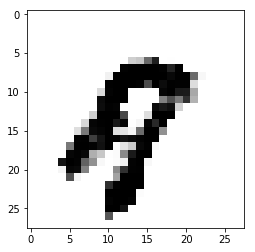

Estimate: [[-75.53940582]]
Iteration: 48400 at 2017-10-12 11:50:20.762355


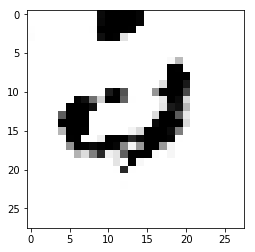

Estimate: [[-55.26675034]]
Iteration: 48500 at 2017-10-12 11:52:54.484142


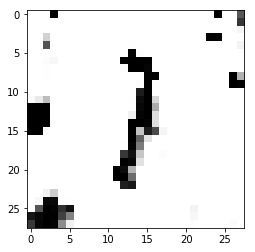

Estimate: [[-104.22311401]]
Iteration: 48600 at 2017-10-12 11:55:30.141863


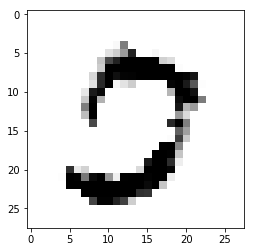

Estimate: [[-50.68001556]]
Iteration: 48700 at 2017-10-12 11:58:04.881768


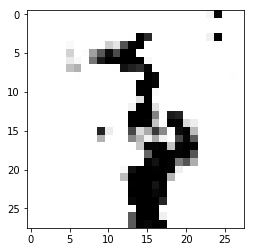

Estimate: [[-147.21476746]]
Iteration: 48800 at 2017-10-12 12:00:39.316554


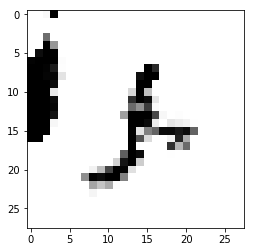

Estimate: [[ 54.74480057]]
Iteration: 48900 at 2017-10-12 12:03:16.313417


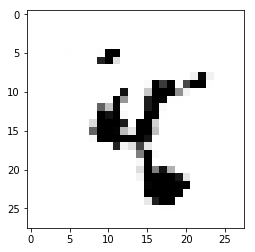

Estimate: [[-61.20372009]]
Iteration: 49000 at 2017-10-12 12:05:49.973303


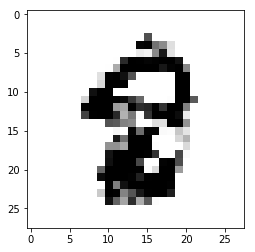

Estimate: [[ 8.50481606]]
Iteration: 49100 at 2017-10-12 12:08:24.100956


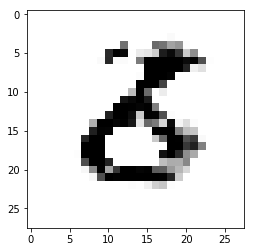

Estimate: [[-66.7844162]]
Iteration: 49200 at 2017-10-12 12:10:58.773277


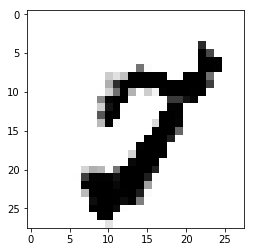

Estimate: [[-17.67681694]]
Iteration: 49300 at 2017-10-12 12:13:34.453043


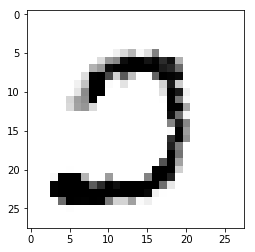

Estimate: [[ 30.288311]]
Iteration: 49400 at 2017-10-12 12:16:15.548830


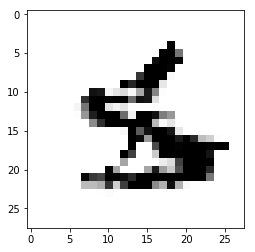

Estimate: [[ 45.61238098]]
Iteration: 49500 at 2017-10-12 12:18:49.729415


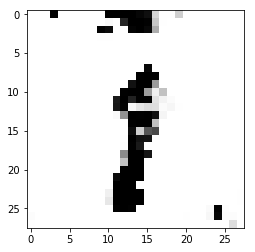

Estimate: [[-60.02872467]]
Iteration: 49600 at 2017-10-12 12:21:24.628575


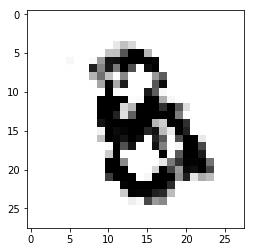

Estimate: [[-50.80810547]]
Iteration: 49700 at 2017-10-12 12:23:58.313312


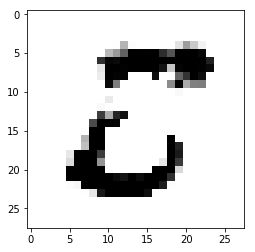

Estimate: [[-44.66297913]]
Iteration: 49800 at 2017-10-12 12:26:32.118432


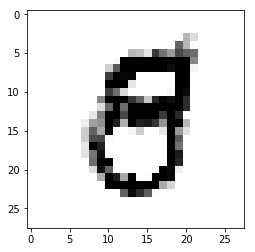

Estimate: [[ 17.90258408]]
Iteration: 49900 at 2017-10-12 12:29:08.980950


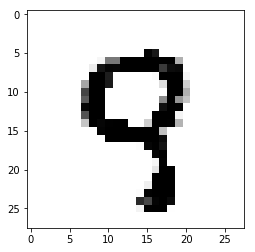

Estimate: [[-83.83172607]]
Iteration: 50000 at 2017-10-12 12:31:42.304978


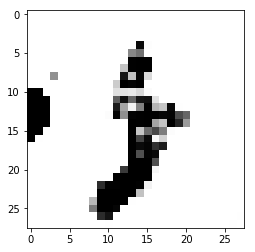

Estimate: [[-58.69923401]]
Iteration: 50100 at 2017-10-12 12:34:14.957452


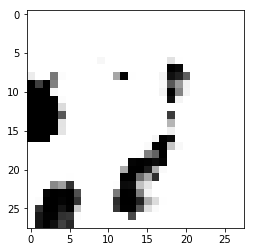

Estimate: [[-144.24720764]]
Iteration: 50200 at 2017-10-12 12:36:47.963098


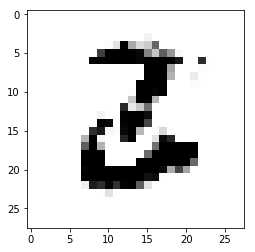

Estimate: [[-18.98119545]]
Iteration: 50300 at 2017-10-12 12:39:25.754793


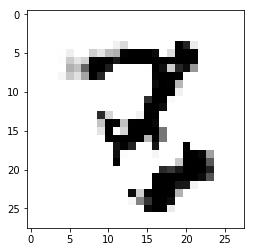

Estimate: [[-173.49127197]]
Iteration: 50400 at 2017-10-12 12:42:00.166455


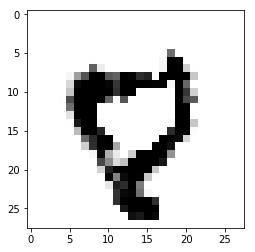

Estimate: [[-22.63641548]]
Iteration: 50500 at 2017-10-12 12:44:33.277818


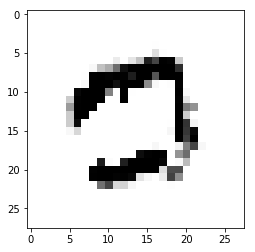

Estimate: [[-55.78552628]]
Iteration: 50600 at 2017-10-12 12:47:06.074291


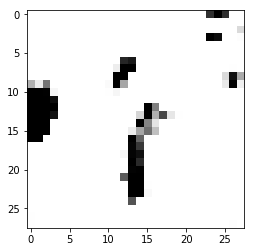

Estimate: [[-17.36353683]]
Iteration: 50700 at 2017-10-12 12:49:39.189331


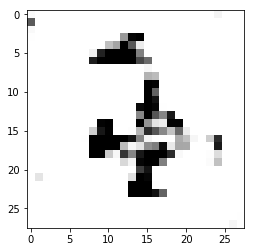

Estimate: [[-175.9672699]]
Iteration: 50800 at 2017-10-12 12:52:17.255470


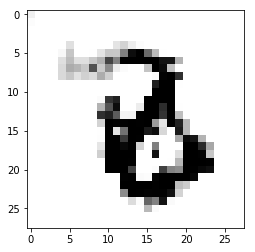

Estimate: [[-86.34669495]]
Iteration: 50900 at 2017-10-12 12:54:50.600626


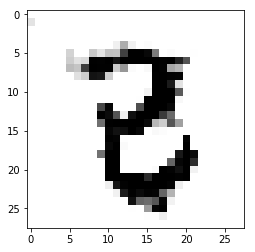

Estimate: [[-24.89113045]]
Iteration: 51000 at 2017-10-12 12:57:26.256728


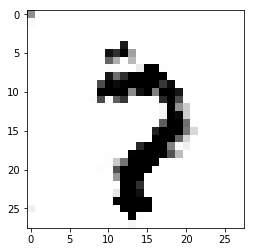

Estimate: [[-86.19937897]]
Iteration: 51100 at 2017-10-12 12:59:59.322742


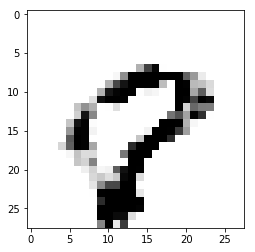

Estimate: [[-92.27146912]]
Iteration: 51200 at 2017-10-12 13:02:33.959242


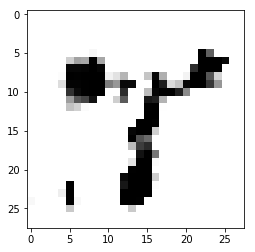

Estimate: [[-1.78887165]]
Iteration: 51300 at 2017-10-12 13:05:09.679577


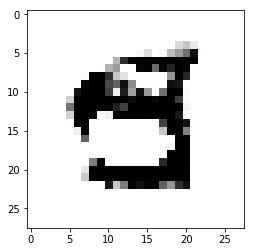

Estimate: [[-44.60215759]]
Iteration: 51400 at 2017-10-12 13:07:42.631622


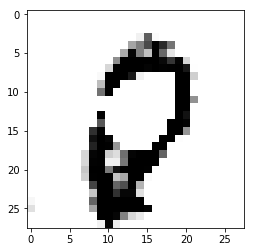

Estimate: [[-17.31409645]]
Iteration: 51500 at 2017-10-12 13:10:14.559465


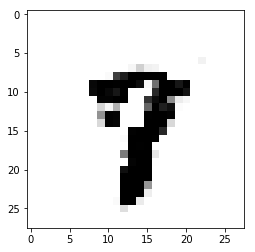

Estimate: [[-31.24463654]]
Iteration: 51600 at 2017-10-12 13:12:46.678991


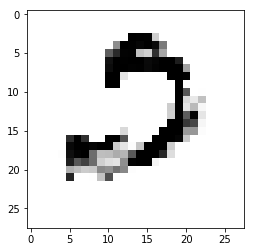

Estimate: [[ 82.55325317]]
Iteration: 51700 at 2017-10-12 13:15:23.985926


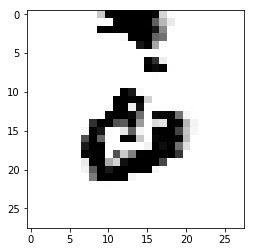

Estimate: [[-19.35789108]]
Iteration: 51800 at 2017-10-12 13:17:56.360950


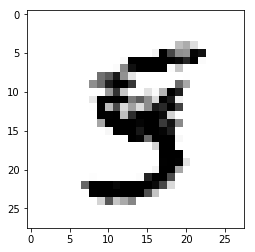

Estimate: [[-21.90291214]]
Iteration: 51900 at 2017-10-12 13:20:28.331673


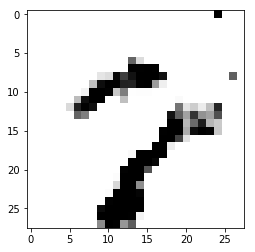

Estimate: [[ 9.21163082]]
Iteration: 52000 at 2017-10-12 13:23:00.439207


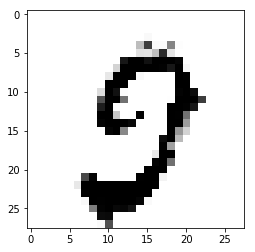

Estimate: [[-44.06322098]]
Iteration: 52100 at 2017-10-12 13:25:32.893052


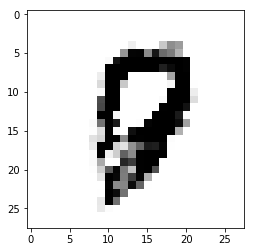

Estimate: [[-14.72366714]]
Iteration: 52200 at 2017-10-12 13:28:09.467992


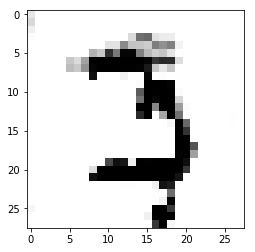

Estimate: [[-14.35762596]]
Iteration: 52300 at 2017-10-12 13:30:41.733509


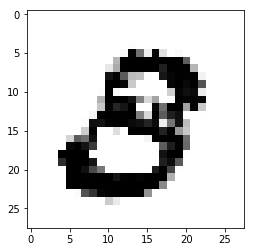

Estimate: [[-21.95158005]]
Iteration: 52400 at 2017-10-12 13:33:15.127302


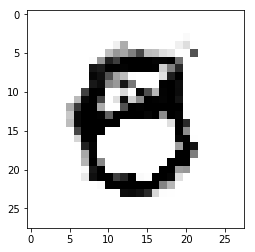

Estimate: [[-31.53981209]]
Iteration: 52500 at 2017-10-12 13:35:50.565411


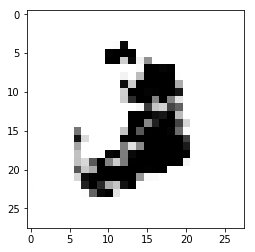

Estimate: [[-92.17597198]]
Iteration: 52600 at 2017-10-12 13:38:26.926835


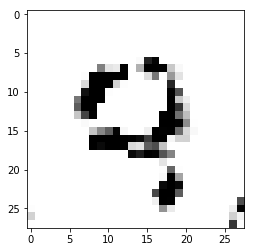

Estimate: [[-1.03337228]]
Iteration: 52700 at 2017-10-12 13:41:02.580720


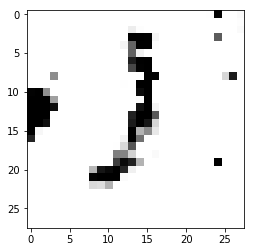

Estimate: [[-21.66975403]]
Iteration: 52800 at 2017-10-12 13:43:37.246230


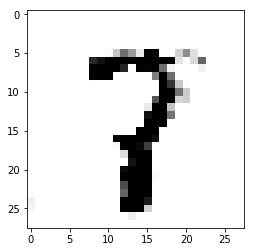

Estimate: [[-50.14941025]]
Iteration: 52900 at 2017-10-12 13:46:10.783050


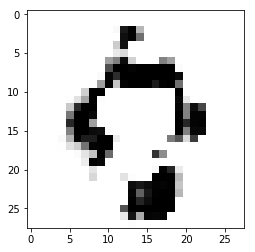

Estimate: [[-87.36475372]]
Iteration: 53000 at 2017-10-12 13:48:44.060798


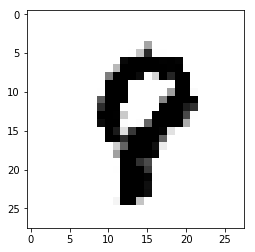

Estimate: [[-24.31068611]]
Iteration: 53100 at 2017-10-12 13:51:22.069673


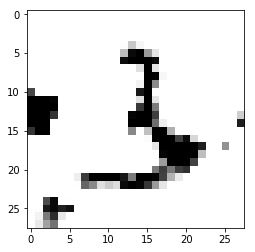

Estimate: [[-124.9278183]]
Iteration: 53200 at 2017-10-12 13:53:56.895912


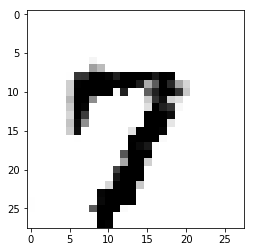

Estimate: [[ 3.49479532]]
Iteration: 53300 at 2017-10-12 13:56:30.847898


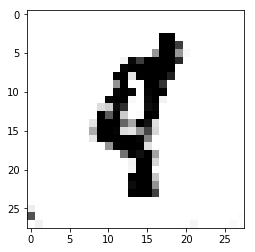

Estimate: [[-46.93888092]]
Iteration: 53400 at 2017-10-12 13:59:07.359801


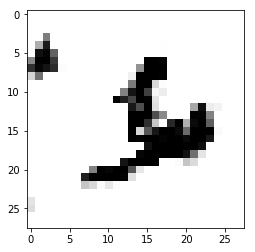

Estimate: [[ 9.18365669]]
Iteration: 53500 at 2017-10-12 14:01:41.205879


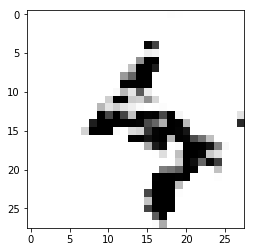

Estimate: [[ 19.59225845]]
Iteration: 53600 at 2017-10-12 14:04:21.048116


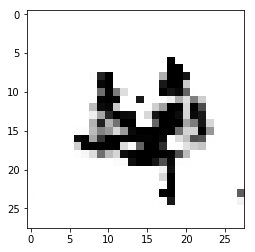

Estimate: [[-79.5635376]]
Iteration: 53700 at 2017-10-12 14:06:57.558375


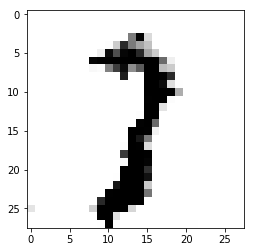

Estimate: [[-54.76711273]]
Iteration: 53800 at 2017-10-12 14:09:32.086014


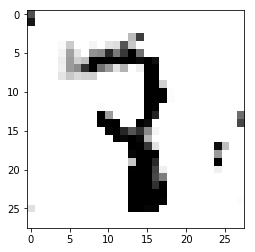

Estimate: [[-78.78810883]]
Iteration: 53900 at 2017-10-12 14:12:06.400232


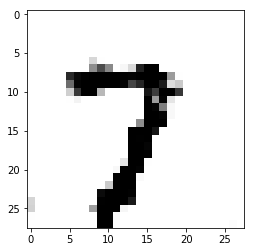

Estimate: [[-21.08375168]]
Iteration: 54000 at 2017-10-12 14:14:40.794444


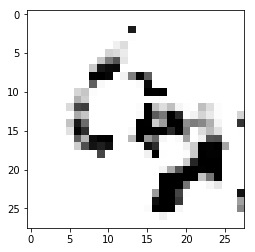

Estimate: [[-27.69623947]]
Iteration: 54100 at 2017-10-12 14:17:22.058584


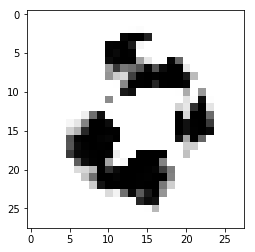

Estimate: [[-123.5401001]]
Iteration: 54200 at 2017-10-12 14:19:57.433447


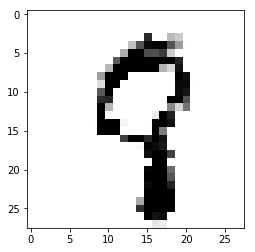

Estimate: [[-89.76004028]]
Iteration: 54300 at 2017-10-12 14:22:31.896311


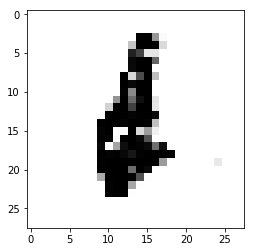

Estimate: [[-50.63676453]]
Iteration: 54400 at 2017-10-12 14:25:09.865518


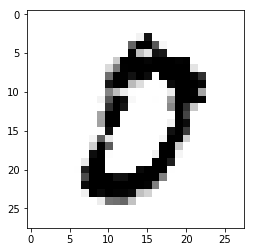

Estimate: [[-55.98019791]]
Iteration: 54500 at 2017-10-12 14:27:46.282070


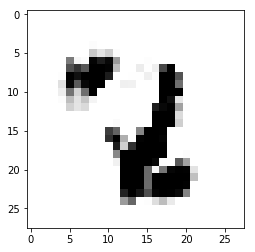

Estimate: [[-38.75281906]]
Iteration: 54600 at 2017-10-12 14:30:27.418662


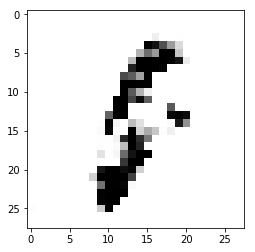

Estimate: [[-66.72924042]]
Iteration: 54700 at 2017-10-12 14:33:03.766100


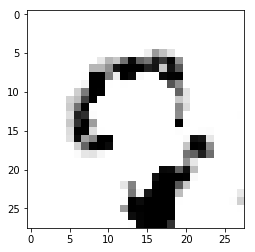

Estimate: [[ 105.28716278]]
Iteration: 54800 at 2017-10-12 14:35:38.704738


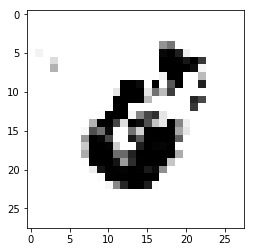

Estimate: [[-118.36978149]]
Iteration: 54900 at 2017-10-12 14:38:13.876224


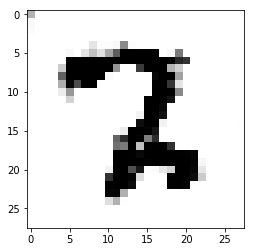

Estimate: [[-53.31213379]]
Iteration: 55000 at 2017-10-12 14:40:53.786720


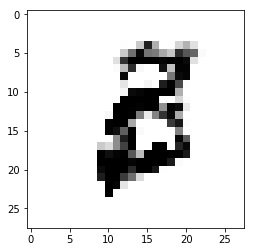

Estimate: [[-77.04893494]]
Iteration: 55100 at 2017-10-12 14:43:33.501667


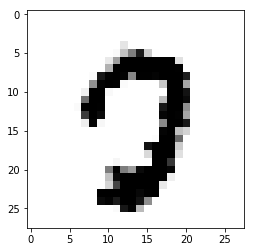

Estimate: [[-143.15710449]]
Iteration: 55200 at 2017-10-12 14:46:12.432655


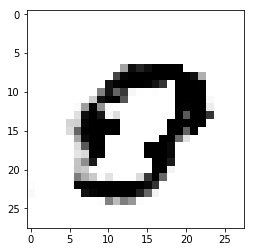

Estimate: [[-98.07954407]]
Iteration: 55300 at 2017-10-12 14:48:48.859733


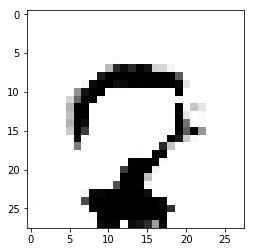

Estimate: [[-193.05419922]]
Iteration: 55400 at 2017-10-12 14:51:25.014552


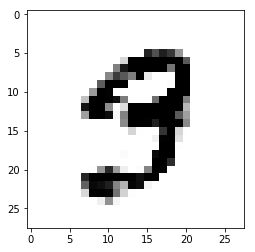

Estimate: [[-80.61672211]]
Iteration: 55500 at 2017-10-12 14:53:59.704003


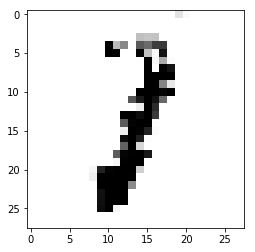

Estimate: [[-54.36466599]]
Iteration: 55600 at 2017-10-12 14:56:35.678260


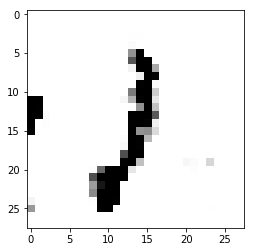

Estimate: [[-162.06741333]]
Iteration: 55700 at 2017-10-12 14:59:13.052512


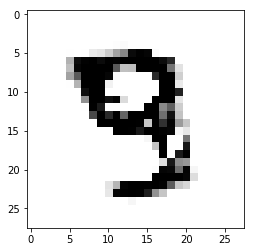

Estimate: [[-169.15307617]]
Iteration: 55800 at 2017-10-12 15:01:47.517902


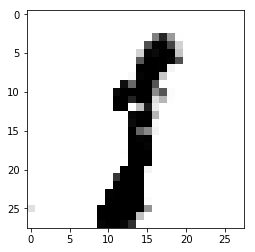

Estimate: [[-32.95663452]]
Iteration: 55900 at 2017-10-12 15:04:19.909084


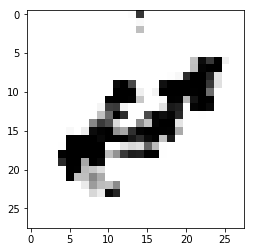

Estimate: [[-74.71530151]]
Iteration: 56000 at 2017-10-12 15:06:53.340024


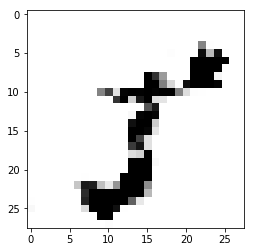

Estimate: [[-39.65980911]]
Iteration: 56100 at 2017-10-12 15:09:31.928106


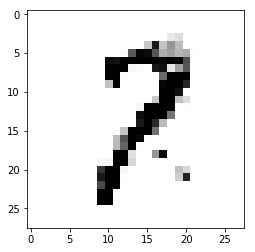

Estimate: [[ 39.37057114]]
Iteration: 56200 at 2017-10-12 15:12:06.609230


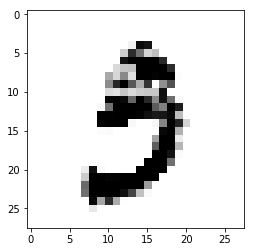

Estimate: [[-72.14281464]]
Iteration: 56300 at 2017-10-12 15:14:41.546481


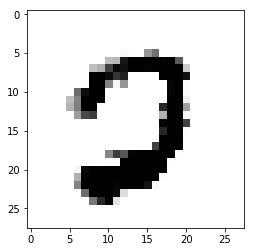

Estimate: [[-82.86076355]]
Iteration: 56400 at 2017-10-12 15:17:23.207314


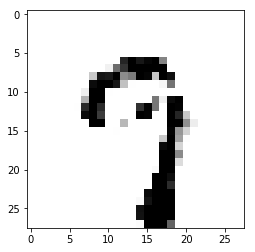

Estimate: [[-82.84914398]]
Iteration: 56500 at 2017-10-12 15:20:02.140349


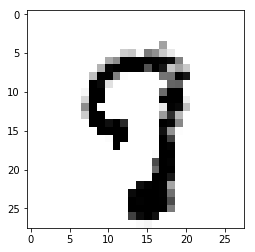

Estimate: [[-30.24262238]]
Iteration: 56600 at 2017-10-12 15:22:41.242571


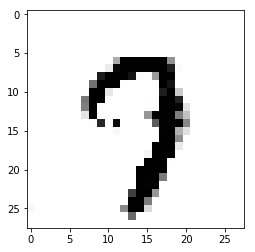

Estimate: [[-64.53035736]]
Iteration: 56700 at 2017-10-12 15:25:16.140587


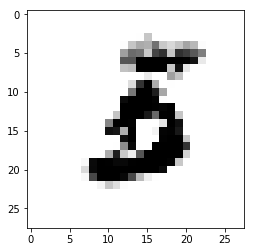

Estimate: [[-84.33205414]]
Iteration: 56800 at 2017-10-12 15:27:51.654656


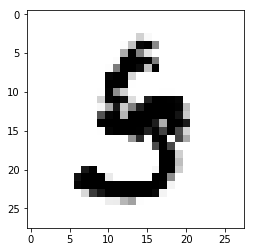

Estimate: [[-80.60597992]]
Iteration: 56900 at 2017-10-12 15:30:25.881854


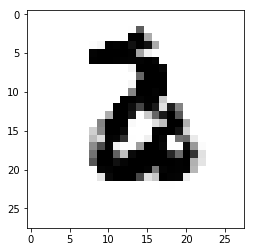

Estimate: [[-12.92628574]]
Iteration: 57000 at 2017-10-12 15:33:00.240455


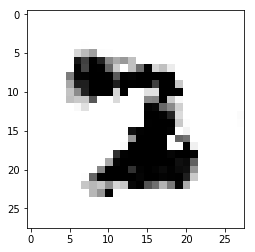

Estimate: [[-8.86931992]]
Iteration: 57100 at 2017-10-12 15:35:38.873814


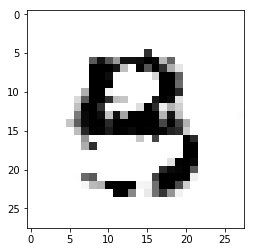

Estimate: [[-103.34519958]]
Iteration: 57200 at 2017-10-12 15:38:11.371261


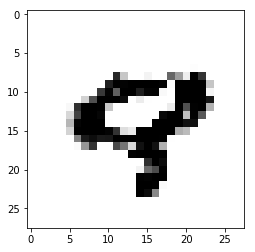

Estimate: [[-46.91753387]]
Iteration: 57300 at 2017-10-12 15:40:44.926613


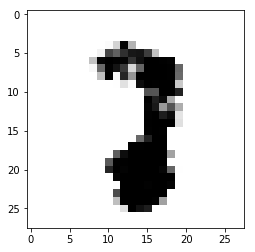

Estimate: [[-120.68447113]]
Iteration: 57400 at 2017-10-12 15:43:18.578138


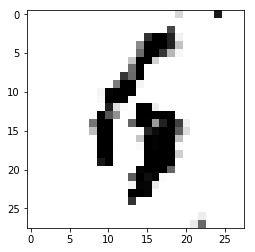

Estimate: [[-42.86137009]]
Iteration: 57500 at 2017-10-12 15:45:53.005597


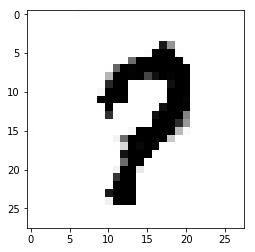

Estimate: [[-45.53869247]]
Iteration: 57600 at 2017-10-12 15:48:32.930825


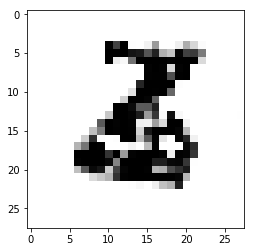

Estimate: [[ 42.28719711]]
Iteration: 57700 at 2017-10-12 15:51:09.715090


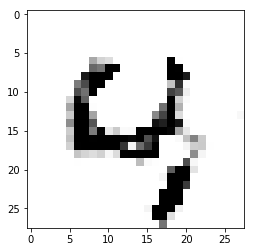

Estimate: [[-110.40621948]]
Iteration: 57800 at 2017-10-12 15:53:43.684764


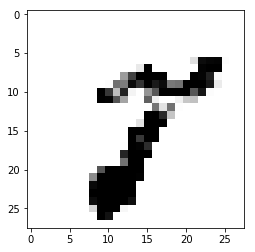

Estimate: [[-54.25465012]]
Iteration: 57900 at 2017-10-12 15:56:20.074673


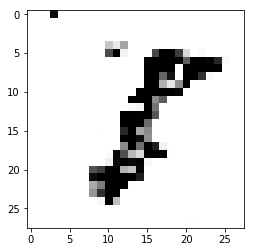

Estimate: [[-132.52952576]]
Iteration: 58000 at 2017-10-12 15:58:57.058464


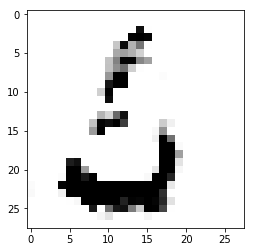

Estimate: [[-93.39594269]]
Iteration: 58100 at 2017-10-12 16:01:38.031462


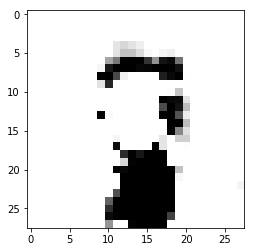

Estimate: [[-81.59409332]]
Iteration: 58200 at 2017-10-12 16:04:12.878500


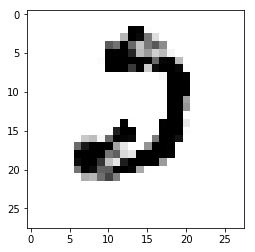

Estimate: [[ 50.42230225]]
Iteration: 58300 at 2017-10-12 16:06:46.426443


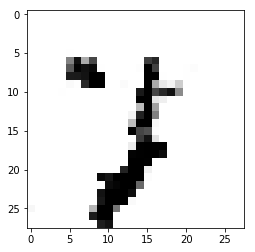

Estimate: [[-85.38167572]]
Iteration: 58400 at 2017-10-12 16:09:19.491891


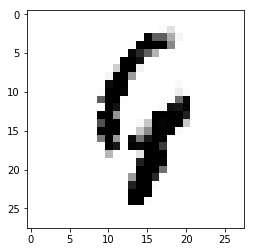

Estimate: [[-9.36302853]]
Iteration: 58500 at 2017-10-12 16:11:53.879036


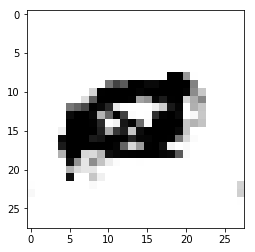

Estimate: [[-43.01140976]]
Iteration: 58600 at 2017-10-12 16:14:33.453793


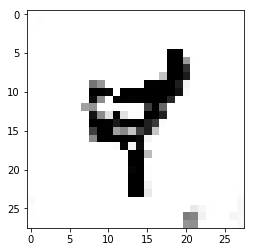

Estimate: [[-92.786026]]
Iteration: 58700 at 2017-10-12 16:17:06.051363


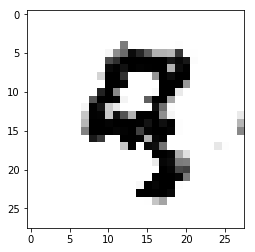

Estimate: [[ 14.9784174]]
Iteration: 58800 at 2017-10-12 16:19:39.228708


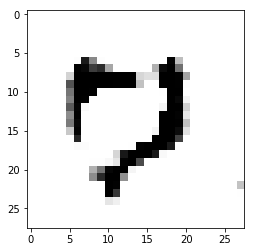

Estimate: [[-68.09661102]]
Iteration: 58900 at 2017-10-12 16:22:13.244247


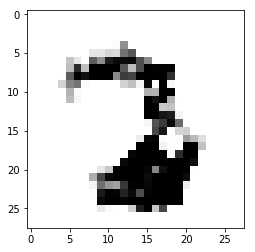

Estimate: [[-12.16016865]]
Iteration: 59000 at 2017-10-12 16:24:50.495467


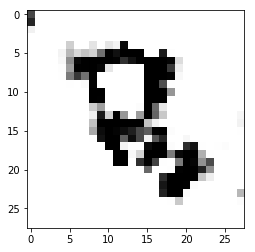

Estimate: [[-87.02153015]]
Iteration: 59100 at 2017-10-12 16:27:26.160985


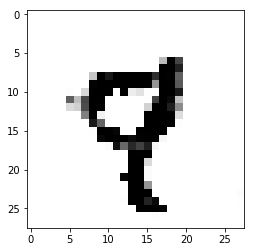

Estimate: [[-117.84824371]]
Iteration: 59200 at 2017-10-12 16:30:00.144793


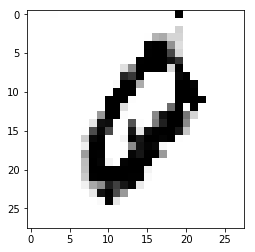

Estimate: [[-33.05635452]]
Iteration: 59300 at 2017-10-12 16:32:32.518429


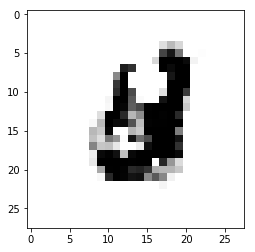

Estimate: [[-66.35163879]]
Iteration: 59400 at 2017-10-12 16:35:05.010912


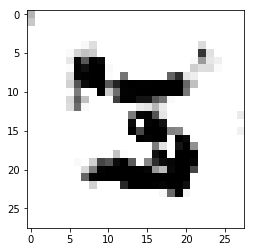

Estimate: [[ 5.63175344]]
Iteration: 59500 at 2017-10-12 16:37:42.854272


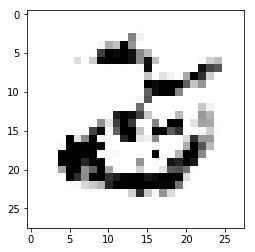

Estimate: [[-135.8482666]]
Iteration: 59600 at 2017-10-12 16:40:15.636139


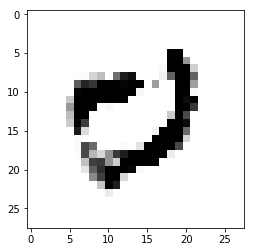

Estimate: [[-49.72418976]]
Iteration: 59700 at 2017-10-12 16:42:48.638202


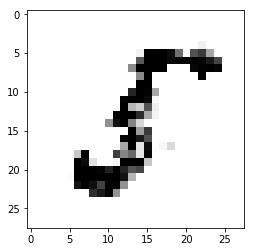

Estimate: [[-84.16461945]]
Iteration: 59800 at 2017-10-12 16:45:21.843915


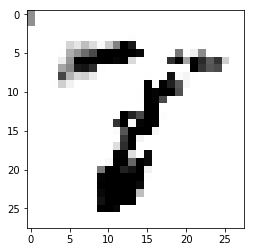

Estimate: [[ 6.25030804]]
Iteration: 59900 at 2017-10-12 16:47:55.055320


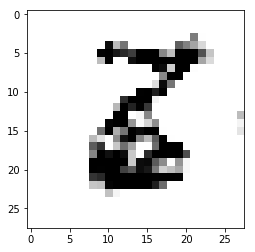

Estimate: [[-118.88493347]]
Iteration: 60000 at 2017-10-12 16:50:32.022651


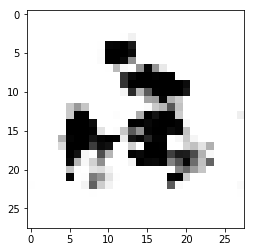

Estimate: [[-19.38695908]]
Iteration: 60100 at 2017-10-12 16:53:04.335513


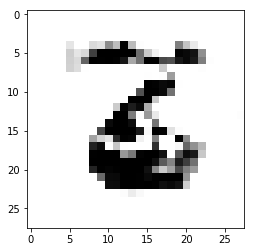

Estimate: [[-4.34717655]]
Iteration: 60200 at 2017-10-12 16:55:37.348008


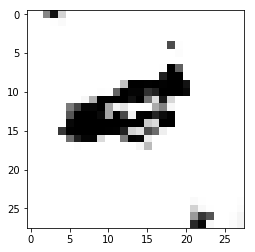

Estimate: [[-26.41019249]]
Iteration: 60300 at 2017-10-12 16:58:09.535579


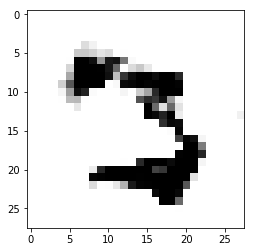

Estimate: [[ 4.7875948]]
Iteration: 60400 at 2017-10-12 17:00:46.147148


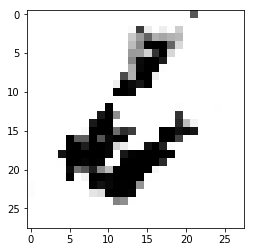

Estimate: [[-147.98765564]]
Iteration: 60500 at 2017-10-12 17:03:19.854631


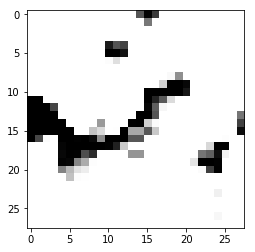

Estimate: [[-299.25631714]]
Iteration: 60600 at 2017-10-12 17:05:52.617384


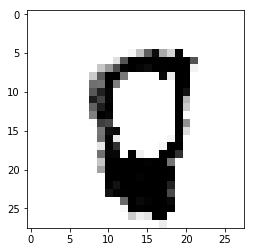

Estimate: [[ 44.2650795]]
Iteration: 60700 at 2017-10-12 17:08:24.967281


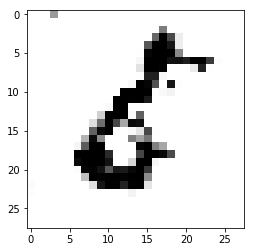

Estimate: [[-46.85146332]]
Iteration: 60800 at 2017-10-12 17:10:56.678362


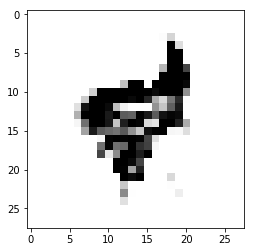

Estimate: [[-106.16529846]]
Iteration: 60900 at 2017-10-12 17:13:33.970394


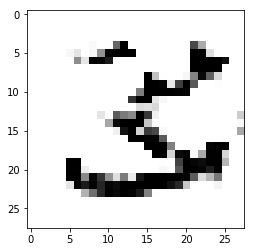

Estimate: [[-77.56495667]]
Iteration: 61000 at 2017-10-12 17:16:06.304566


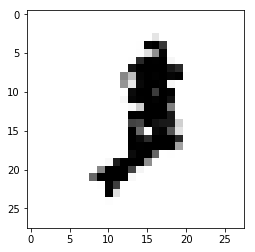

Estimate: [[-19.67416954]]
Iteration: 61100 at 2017-10-12 17:18:38.542715


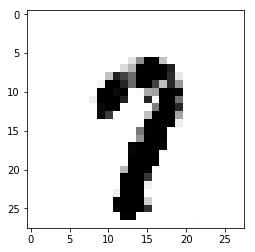

Estimate: [[-40.15498734]]
Iteration: 61200 at 2017-10-12 17:21:10.550167


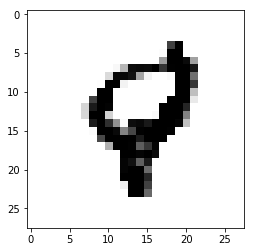

Estimate: [[-46.21279907]]
Iteration: 61300 at 2017-10-12 17:23:45.466103


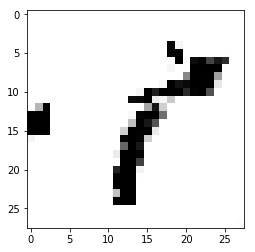

Estimate: [[-39.21684265]]
Iteration: 61400 at 2017-10-12 17:26:21.025553


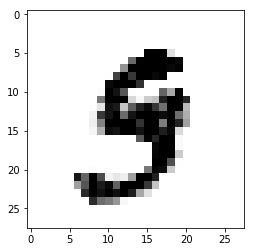

Estimate: [[-24.75662613]]
Iteration: 61500 at 2017-10-12 17:28:53.055643


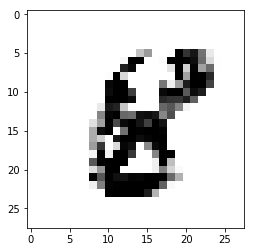

Estimate: [[-95.41965485]]
Iteration: 61600 at 2017-10-12 17:31:24.815075


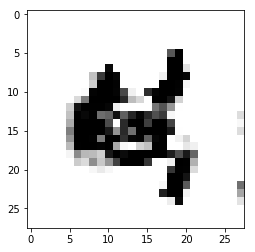

Estimate: [[-151.43968201]]
Iteration: 61700 at 2017-10-12 17:33:56.256408


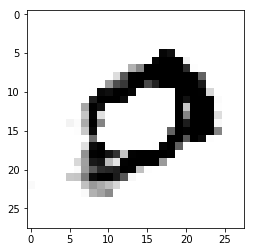

Estimate: [[-105.14429474]]
Iteration: 61800 at 2017-10-12 17:36:32.667756


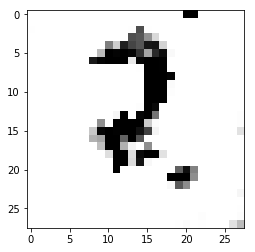

Estimate: [[-163.46461487]]
Iteration: 61900 at 2017-10-12 17:39:05.506288


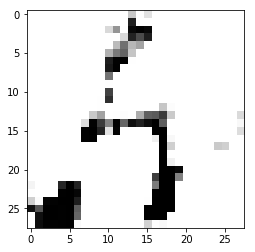

Estimate: [[-51.49977493]]
Iteration: 62000 at 2017-10-12 17:41:37.708583


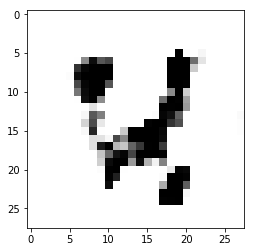

Estimate: [[-38.52461624]]
Iteration: 62100 at 2017-10-12 17:44:13.700401


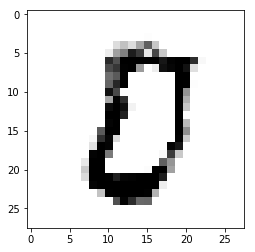

Estimate: [[-70.31047058]]
Iteration: 62200 at 2017-10-12 17:46:47.477104


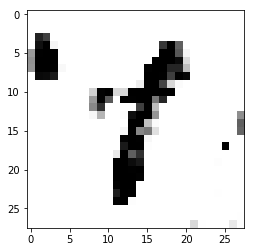

Estimate: [[-38.71261597]]
Iteration: 62300 at 2017-10-12 17:49:26.875413


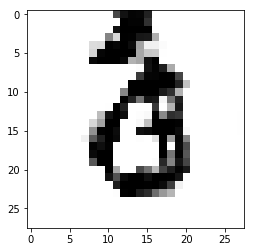

Estimate: [[-3.26044893]]
Iteration: 62400 at 2017-10-12 17:52:01.280160


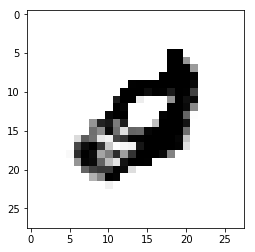

Estimate: [[ 15.07589436]]
Iteration: 62500 at 2017-10-12 17:54:35.891983


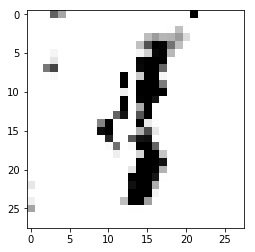

Estimate: [[-158.64273071]]
Iteration: 62600 at 2017-10-12 17:57:14.143920


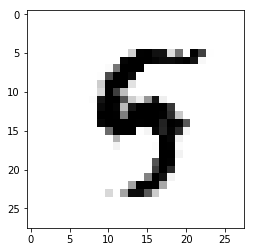

Estimate: [[-88.56425476]]
Iteration: 62700 at 2017-10-12 17:59:50.128523


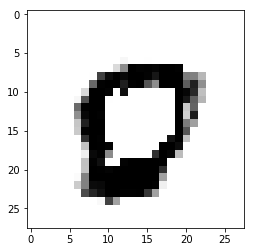

Estimate: [[ 31.79803276]]
Iteration: 62800 at 2017-10-12 18:02:28.926887


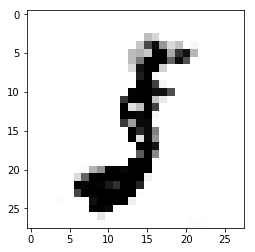

Estimate: [[-84.53176117]]
Iteration: 62900 at 2017-10-12 18:05:02.162337


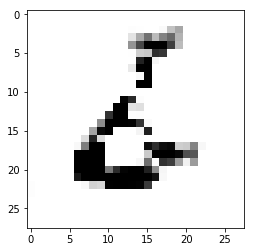

Estimate: [[-68.12432861]]
Iteration: 63000 at 2017-10-12 18:07:35.315520


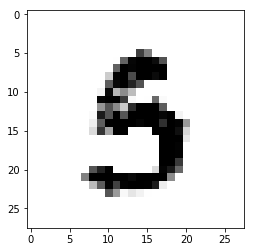

Estimate: [[-40.92556]]
Iteration: 63100 at 2017-10-12 18:10:08.454456


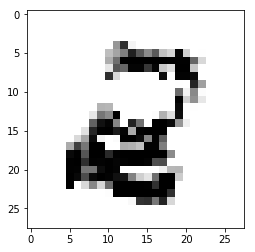

Estimate: [[-30.73437691]]
Iteration: 63200 at 2017-10-12 18:12:45.238351


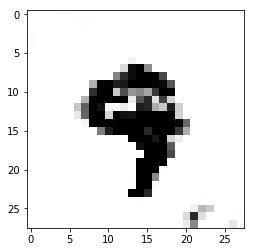

Estimate: [[-140.27536011]]
Iteration: 63300 at 2017-10-12 18:15:20.096815


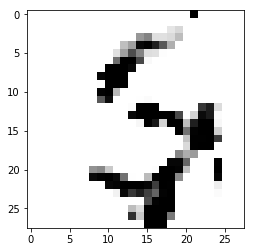

Estimate: [[-80.98905182]]
Iteration: 63400 at 2017-10-12 18:17:53.149090


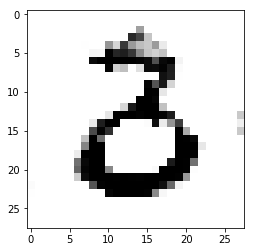

Estimate: [[-83.10643005]]
Iteration: 63500 at 2017-10-12 18:20:25.844725


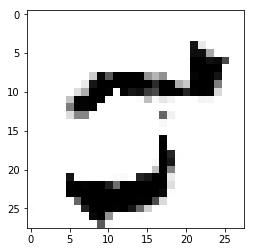

Estimate: [[-48.03336716]]
Iteration: 63600 at 2017-10-12 18:22:58.134185


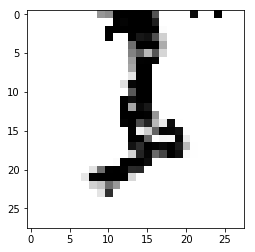

Estimate: [[-10.28707123]]
Iteration: 63700 at 2017-10-12 18:25:35.748033


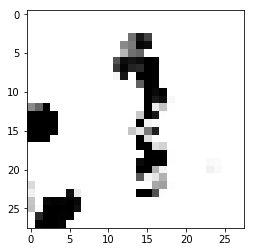

Estimate: [[-117.64916992]]
Iteration: 63800 at 2017-10-12 18:28:09.063814


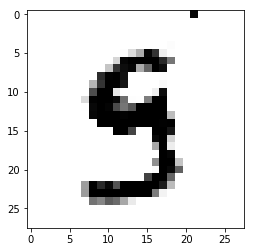

Estimate: [[-39.84968948]]
Iteration: 63900 at 2017-10-12 18:30:42.105916


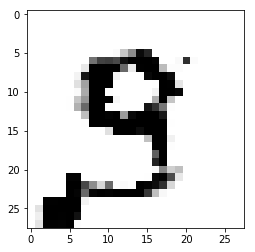

Estimate: [[-56.76362991]]
Iteration: 64000 at 2017-10-12 18:33:13.993628


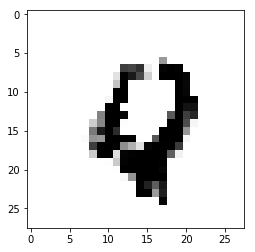

Estimate: [[-22.62434006]]
Iteration: 64100 at 2017-10-12 18:35:48.134676


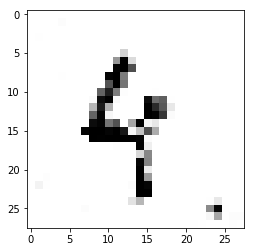

Estimate: [[-112.29232788]]
Iteration: 64200 at 2017-10-12 18:38:23.973532


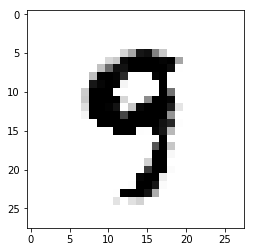

Estimate: [[-100.33036041]]
Iteration: 64300 at 2017-10-12 18:40:56.001821


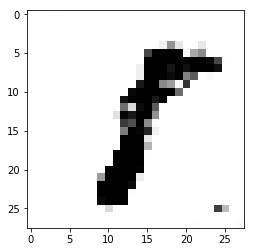

Estimate: [[-71.53378296]]
Iteration: 64400 at 2017-10-12 18:43:28.454086


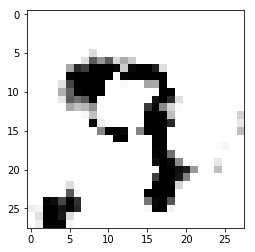

Estimate: [[-20.14066315]]
Iteration: 64500 at 2017-10-12 18:46:01.011789


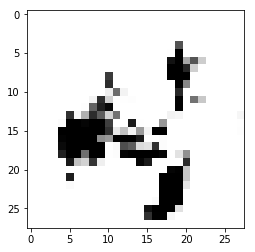

Estimate: [[-238.59819031]]
Iteration: 64600 at 2017-10-12 18:48:38.619508


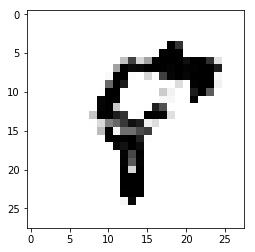

Estimate: [[-118.07014465]]
Iteration: 64700 at 2017-10-12 18:51:11.173291


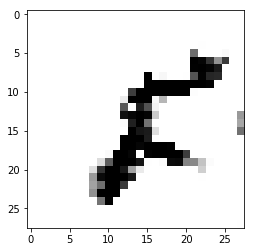

Estimate: [[-59.38770294]]
Iteration: 64800 at 2017-10-12 18:53:43.625460


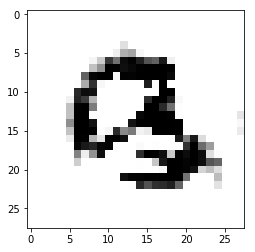

Estimate: [[-84.6690979]]
Iteration: 64900 at 2017-10-12 18:56:15.897644


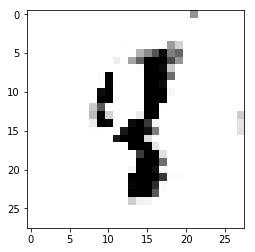

Estimate: [[-121.5688858]]
Iteration: 65000 at 2017-10-12 18:58:48.910185


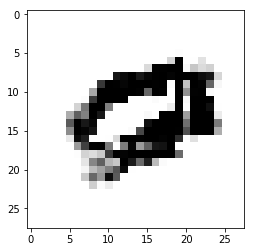

Estimate: [[-54.71973419]]
Iteration: 65100 at 2017-10-12 19:01:26.317144


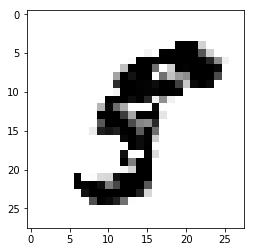

Estimate: [[-36.68328857]]
Iteration: 65200 at 2017-10-12 19:03:58.582741


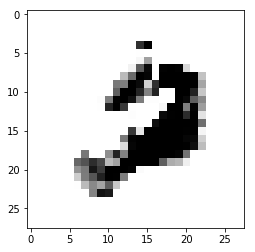

Estimate: [[-21.94783974]]
Iteration: 65300 at 2017-10-12 19:06:30.801869


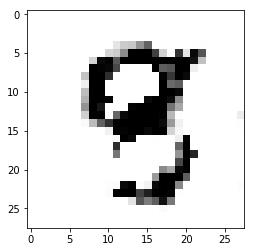

Estimate: [[-142.38238525]]
Iteration: 65400 at 2017-10-12 19:09:03.069211


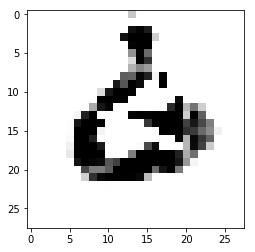

Estimate: [[-203.78715515]]
Iteration: 65500 at 2017-10-12 19:11:39.197044


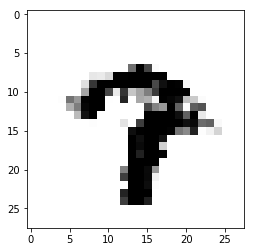

Estimate: [[-151.82017517]]
Iteration: 65600 at 2017-10-12 19:14:12.752625


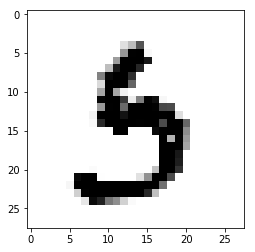

Estimate: [[-20.30281258]]
Iteration: 65700 at 2017-10-12 19:16:44.936097


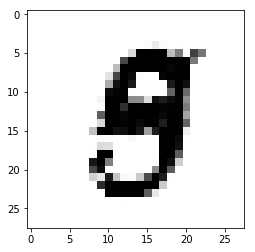

Estimate: [[-81.52013397]]
Iteration: 65800 at 2017-10-12 19:19:17.286112


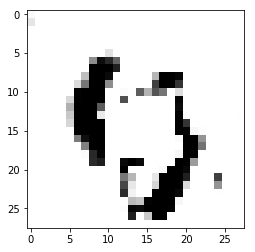

Estimate: [[-119.99777985]]
Iteration: 65900 at 2017-10-12 19:21:49.692051


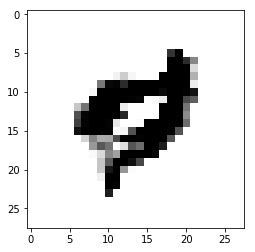

Estimate: [[-33.60175705]]
Iteration: 66000 at 2017-10-12 19:24:28.367239


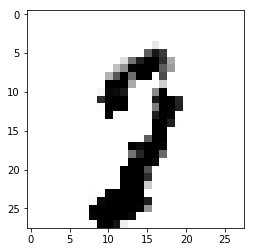

Estimate: [[-50.47745895]]
Iteration: 66100 at 2017-10-12 19:27:00.913849


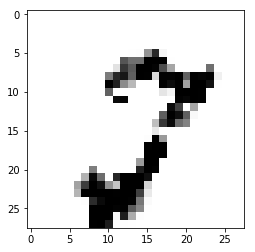

Estimate: [[-175.63398743]]
Iteration: 66200 at 2017-10-12 19:29:31.235188


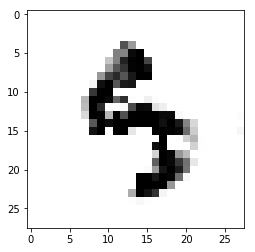

Estimate: [[-90.80760193]]
Iteration: 66300 at 2017-10-12 19:32:05.008800


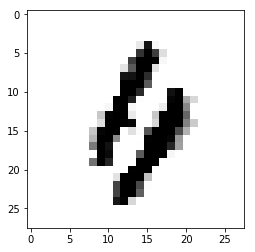

Estimate: [[-62.5572052]]
Iteration: 66400 at 2017-10-12 19:34:39.092706


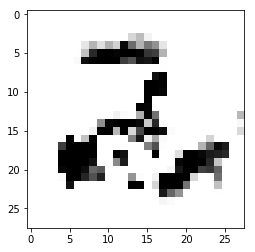

Estimate: [[-186.5292511]]
Iteration: 66500 at 2017-10-12 19:37:10.497770


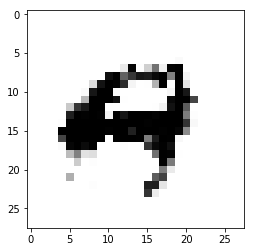

Estimate: [[ 21.016922]]
Iteration: 66600 at 2017-10-12 19:39:41.531849


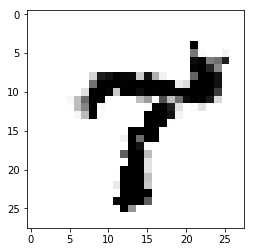

Estimate: [[-87.94655609]]
Iteration: 66700 at 2017-10-12 19:42:12.426331


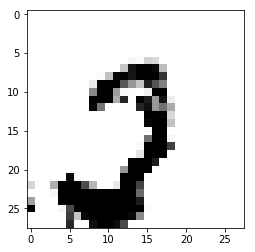

Estimate: [[ 57.75986862]]
Iteration: 66800 at 2017-10-12 19:44:43.487688


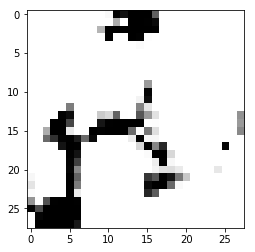

Estimate: [[-199.72676086]]
Iteration: 66900 at 2017-10-12 19:47:14.485626


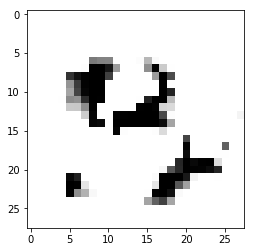

Estimate: [[ 14.98654652]]
Iteration: 67000 at 2017-10-12 19:49:45.615678


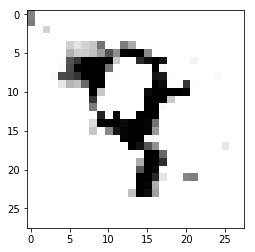

Estimate: [[-64.0514679]]
Iteration: 67100 at 2017-10-12 19:52:16.550908


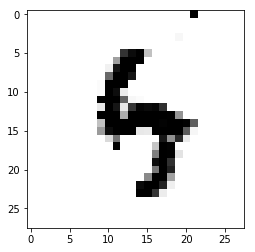

Estimate: [[-65.637146]]
Iteration: 67200 at 2017-10-12 19:54:47.097924


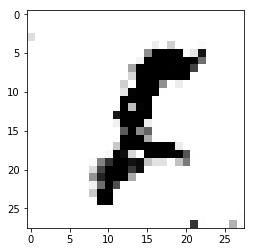

Estimate: [[-64.2070694]]
Iteration: 67300 at 2017-10-12 19:57:17.947551


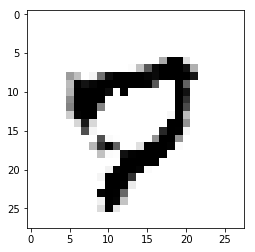

Estimate: [[-13.89443493]]
Iteration: 67400 at 2017-10-12 19:59:48.565093


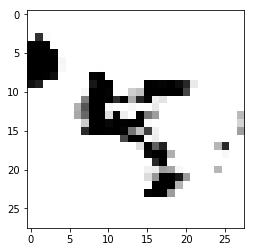

Estimate: [[-222.41824341]]
Iteration: 67500 at 2017-10-12 20:02:18.628907


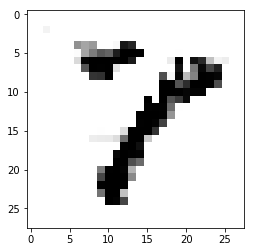

Estimate: [[-98.34753418]]
Iteration: 67600 at 2017-10-12 20:04:48.799739


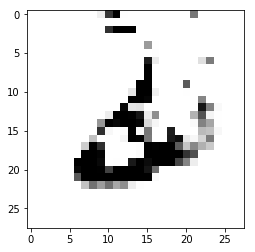

Estimate: [[-227.6473999]]
Iteration: 67700 at 2017-10-12 20:07:19.078786


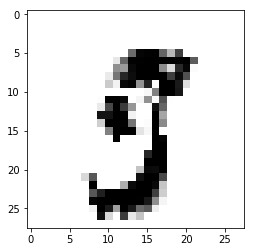

Estimate: [[-92.00952911]]
Iteration: 67800 at 2017-10-12 20:09:49.364786


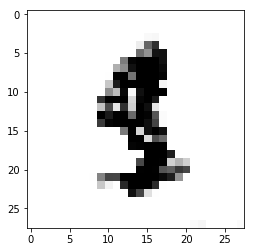

Estimate: [[-154.8129425]]
Iteration: 67900 at 2017-10-12 20:12:19.923332


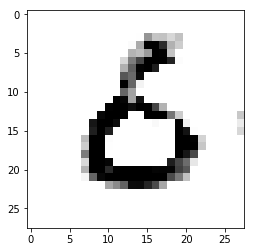

Estimate: [[-51.7831192]]
Iteration: 68000 at 2017-10-12 20:14:51.108320


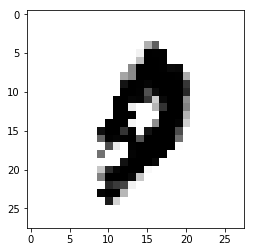

Estimate: [[-32.63461685]]
Iteration: 68100 at 2017-10-12 20:17:22.068271


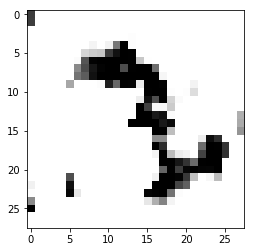

Estimate: [[-79.27232361]]
Iteration: 68200 at 2017-10-12 20:19:53.080576


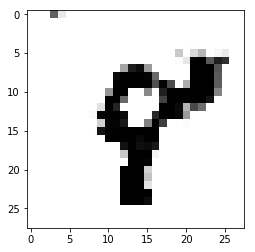

Estimate: [[-72.3710022]]
Iteration: 68300 at 2017-10-12 20:22:24.202302


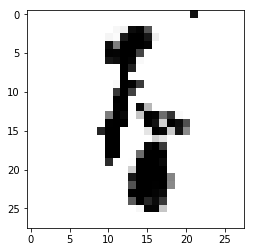

Estimate: [[-54.29183197]]
Iteration: 68400 at 2017-10-12 20:24:55.462075


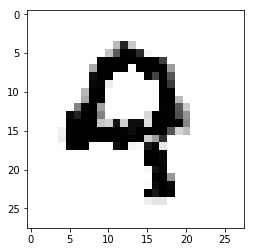

Estimate: [[-87.97537231]]
Iteration: 68500 at 2017-10-12 20:27:26.825851


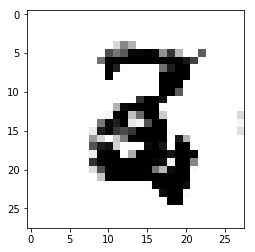

Estimate: [[ 5.7869215]]
Iteration: 68600 at 2017-10-12 20:29:57.510003


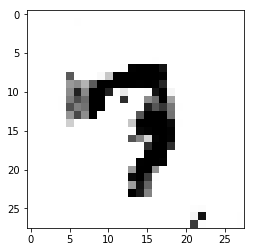

Estimate: [[-26.20479202]]
Iteration: 68700 at 2017-10-12 20:32:28.663152


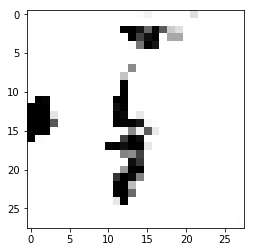

Estimate: [[-10.54107475]]
Iteration: 68800 at 2017-10-12 20:34:59.556291


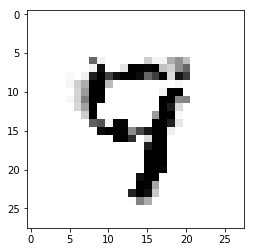

Estimate: [[-8.52113819]]
Iteration: 68900 at 2017-10-12 20:37:30.620824


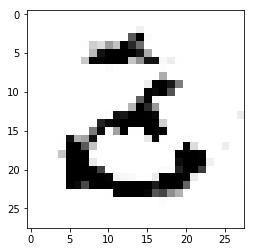

Estimate: [[-21.5585022]]
Iteration: 69000 at 2017-10-12 20:40:01.334016


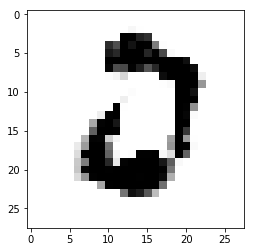

Estimate: [[-71.92681122]]
Iteration: 69100 at 2017-10-12 20:42:32.413688


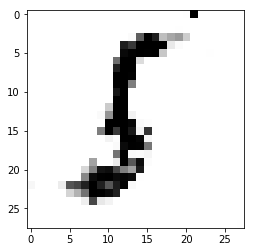

Estimate: [[-55.2981987]]
Iteration: 69200 at 2017-10-12 20:45:03.038200


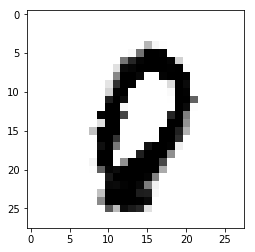

Estimate: [[-60.50282669]]
Iteration: 69300 at 2017-10-12 20:47:33.764008


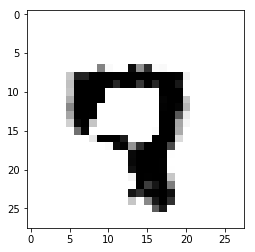

Estimate: [[ 17.28322792]]
Iteration: 69400 at 2017-10-12 20:50:04.795509


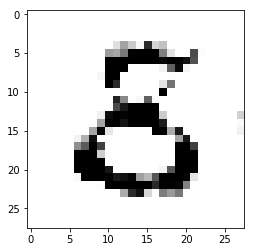

Estimate: [[-36.23853683]]
Iteration: 69500 at 2017-10-12 20:52:35.295007


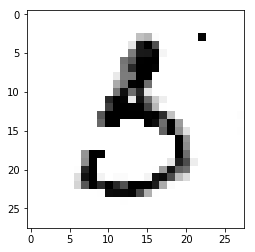

Estimate: [[-7.12661648]]
Iteration: 69600 at 2017-10-12 20:55:05.512572


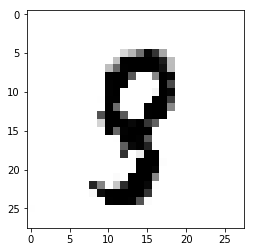

Estimate: [[-99.36799622]]
Iteration: 69700 at 2017-10-12 20:57:35.848523


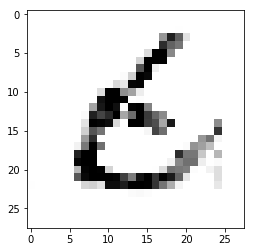

Estimate: [[-27.59876633]]
Iteration: 69800 at 2017-10-12 21:00:06.342969


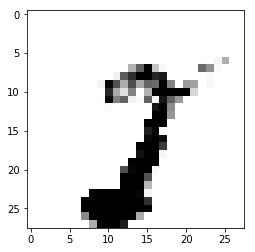

Estimate: [[-26.60790634]]
Iteration: 69900 at 2017-10-12 21:02:37.206930


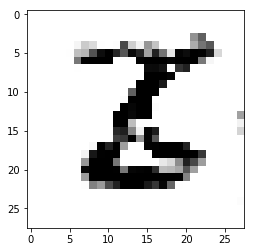

Estimate: [[-36.44898605]]
Iteration: 70000 at 2017-10-12 21:05:07.764510


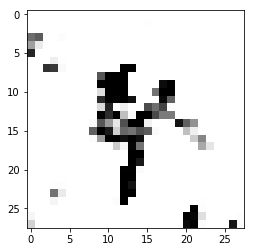

Estimate: [[-417.74905396]]
Iteration: 70100 at 2017-10-12 21:07:38.186802


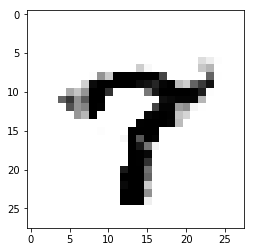

Estimate: [[-71.75572205]]
Iteration: 70200 at 2017-10-12 21:10:08.555082


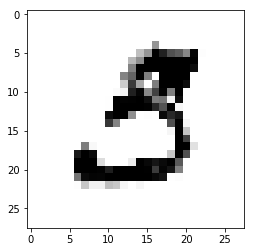

Estimate: [[-14.96827507]]
Iteration: 70300 at 2017-10-12 21:12:39.078934


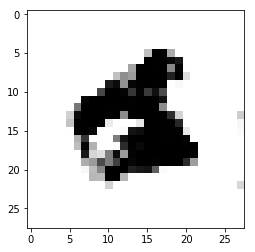

Estimate: [[-58.37248611]]
Iteration: 70400 at 2017-10-12 21:15:09.680578


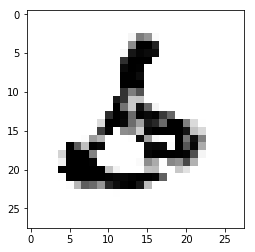

Estimate: [[-79.08347321]]
Iteration: 70500 at 2017-10-12 21:17:39.925682


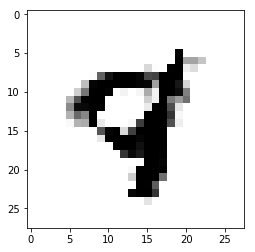

Estimate: [[-78.3802948]]
Iteration: 70600 at 2017-10-12 21:20:10.021802


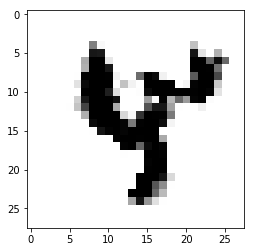

Estimate: [[-95.02960205]]
Iteration: 70700 at 2017-10-12 21:22:40.627076


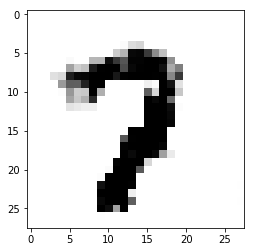

Estimate: [[-79.44455719]]
Iteration: 70800 at 2017-10-12 21:25:11.155750


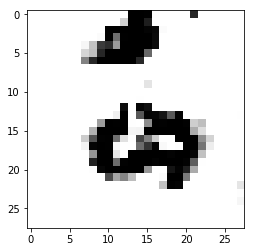

Estimate: [[-69.76037598]]
Iteration: 70900 at 2017-10-12 21:27:43.213846


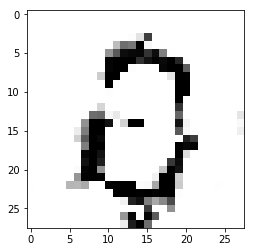

Estimate: [[-139.22325134]]
Iteration: 71000 at 2017-10-12 21:30:15.050543


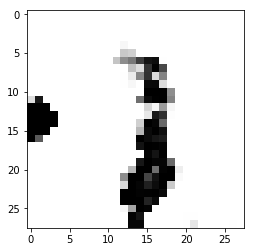

Estimate: [[-80.3105011]]
Iteration: 71100 at 2017-10-12 21:32:46.618501


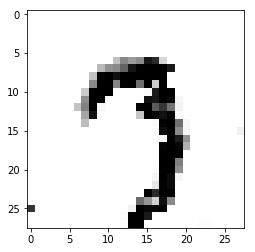

Estimate: [[-84.11459351]]
Iteration: 71200 at 2017-10-12 21:35:18.169063


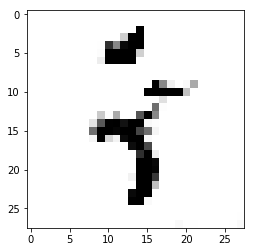

Estimate: [[-88.74950409]]
Iteration: 71300 at 2017-10-12 21:37:50.902318


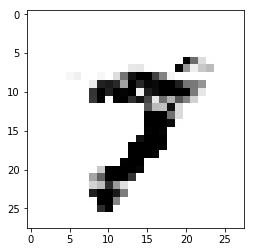

Estimate: [[-98.73718262]]
Iteration: 71400 at 2017-10-12 21:40:23.135222


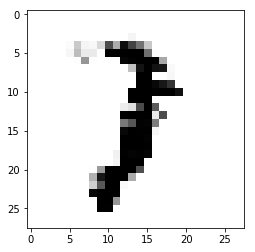

Estimate: [[-91.09619141]]
Iteration: 71500 at 2017-10-12 21:42:56.725409


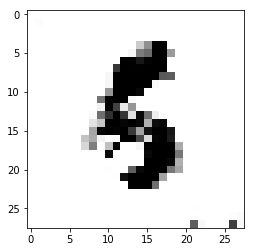

Estimate: [[-212.945755]]
Iteration: 71600 at 2017-10-12 21:45:28.164787


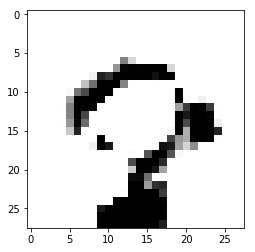

Estimate: [[-28.54828072]]
Iteration: 71700 at 2017-10-12 21:47:59.614627


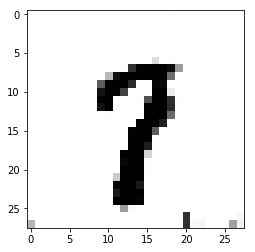

Estimate: [[-106.41149902]]
Iteration: 71800 at 2017-10-12 21:50:31.258297


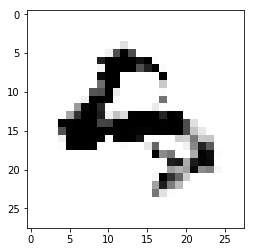

Estimate: [[-148.60375977]]
Iteration: 71900 at 2017-10-12 21:53:03.060742


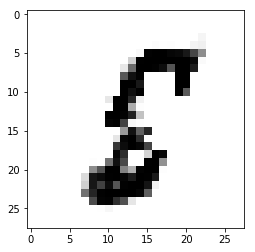

Estimate: [[-53.59645462]]
Iteration: 72000 at 2017-10-12 21:55:36.201240


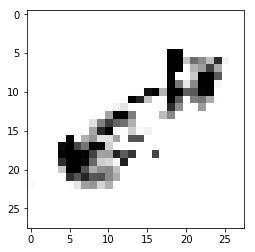

Estimate: [[ 54.34111023]]
Iteration: 72100 at 2017-10-12 21:58:08.240502


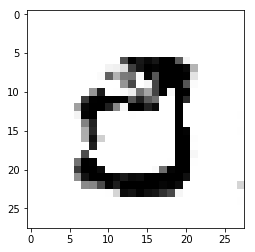

Estimate: [[-88.76893616]]
Iteration: 72200 at 2017-10-12 22:00:39.952054


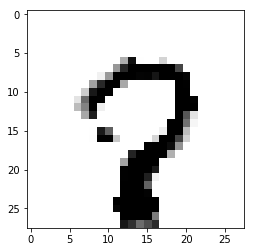

Estimate: [[-153.13685608]]
Iteration: 72300 at 2017-10-12 22:03:12.748255


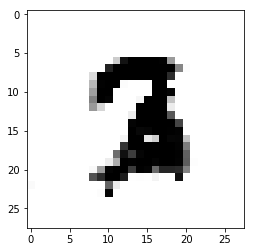

Estimate: [[-72.94327545]]
Iteration: 72400 at 2017-10-12 22:05:43.877979


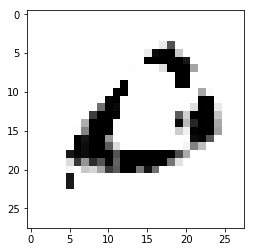

Estimate: [[ 35.30484009]]
Iteration: 72500 at 2017-10-12 22:08:14.988143


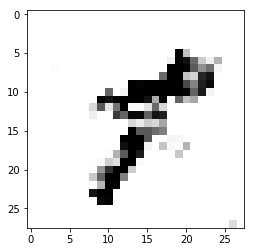

Estimate: [[-119.62808228]]
Iteration: 72600 at 2017-10-12 22:10:46.251729


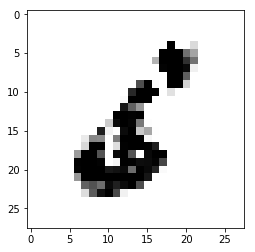

Estimate: [[-16.83468819]]
Iteration: 72700 at 2017-10-12 22:13:17.310852


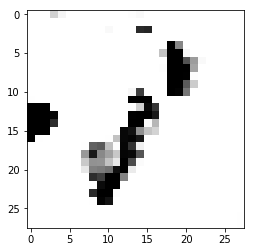

Estimate: [[-123.96975708]]
Iteration: 72800 at 2017-10-12 22:15:48.418512


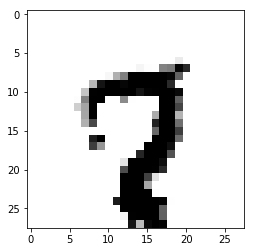

Estimate: [[ 29.55861282]]
Iteration: 72900 at 2017-10-12 22:18:19.591580


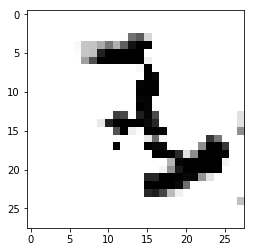

Estimate: [[-61.25001144]]
Iteration: 73000 at 2017-10-12 22:20:50.327125


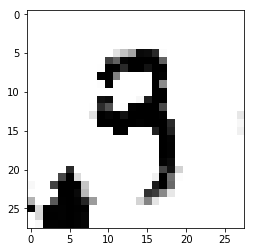

Estimate: [[ 25.86286545]]
Iteration: 73100 at 2017-10-12 22:23:20.632105


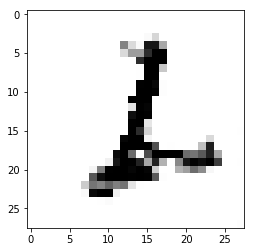

Estimate: [[-4.70815134]]
Iteration: 73200 at 2017-10-12 22:25:52.722762


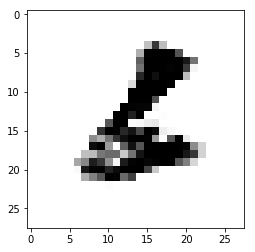

Estimate: [[-236.824646]]
Iteration: 73300 at 2017-10-12 22:28:23.142509


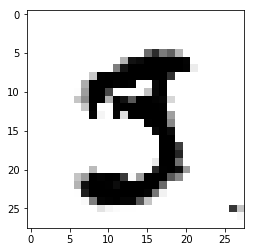

Estimate: [[-126.75090027]]
Iteration: 73400 at 2017-10-12 22:30:53.991265


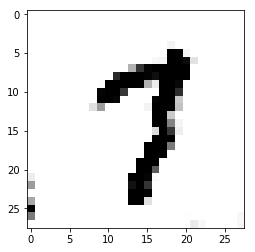

Estimate: [[-30.2496357]]
Iteration: 73500 at 2017-10-12 22:33:24.939681


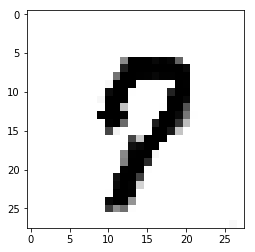

Estimate: [[-43.46271896]]
Iteration: 73600 at 2017-10-12 22:35:55.723078


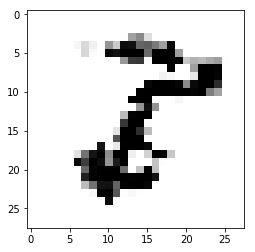

Estimate: [[-126.13496399]]
Iteration: 73700 at 2017-10-12 22:38:26.385826


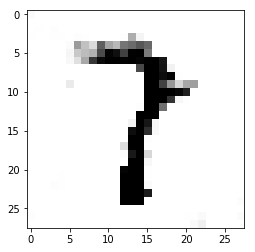

Estimate: [[-16.51324463]]
Iteration: 73800 at 2017-10-12 22:40:57.240402


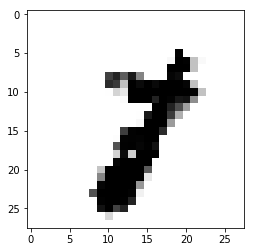

Estimate: [[-46.0740509]]
Iteration: 73900 at 2017-10-12 22:43:27.939417


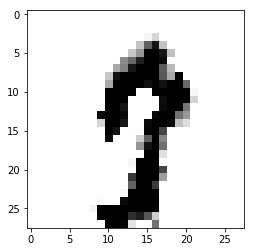

Estimate: [[-67.77711487]]
Iteration: 74000 at 2017-10-12 22:45:58.859895


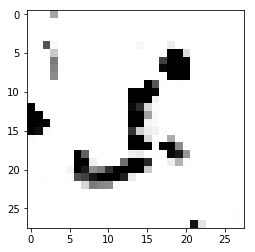

Estimate: [[-156.2315979]]
Iteration: 74100 at 2017-10-12 22:48:29.623480


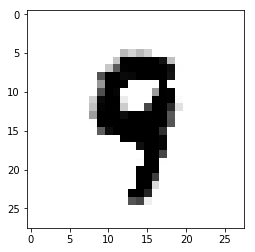

Estimate: [[ 103.40710449]]
Iteration: 74200 at 2017-10-12 22:51:00.192613


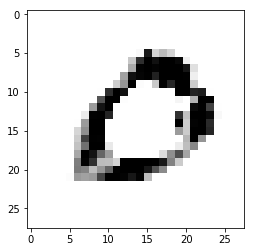

Estimate: [[ 90.68780518]]
Iteration: 74300 at 2017-10-12 22:53:30.698323


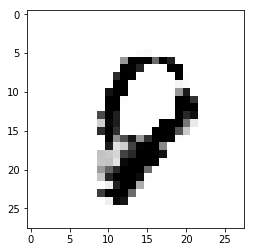

Estimate: [[-59.39427948]]
Iteration: 74400 at 2017-10-12 22:56:01.329177


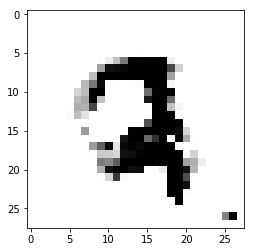

Estimate: [[-59.82257462]]
Iteration: 74500 at 2017-10-12 22:58:31.822805


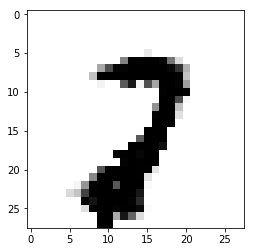

Estimate: [[ 23.43296242]]
Iteration: 74600 at 2017-10-12 23:01:02.684685


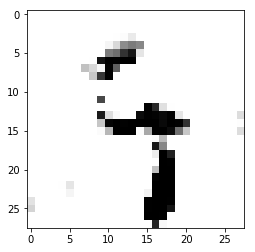

Estimate: [[-123.3970108]]
Iteration: 74700 at 2017-10-12 23:03:33.409114


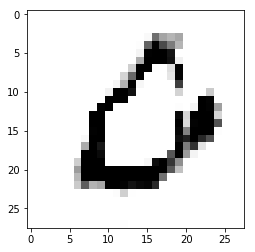

Estimate: [[ 61.47798157]]
Iteration: 74800 at 2017-10-12 23:06:04.113169


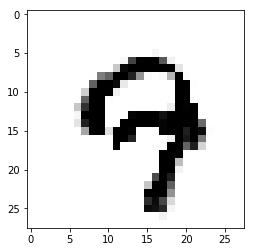

Estimate: [[-14.9379406]]
Iteration: 74900 at 2017-10-12 23:08:34.995035


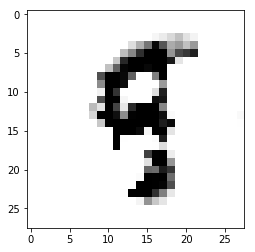

Estimate: [[-54.62447739]]
Iteration: 75000 at 2017-10-12 23:11:05.798689


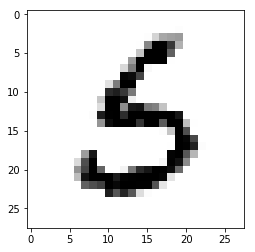

Estimate: [[-14.27860069]]
Iteration: 75100 at 2017-10-12 23:13:36.548362


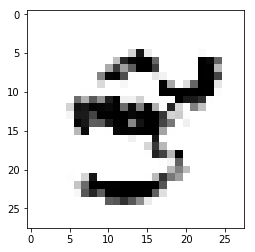

Estimate: [[-38.28779602]]
Iteration: 75200 at 2017-10-12 23:16:07.372771


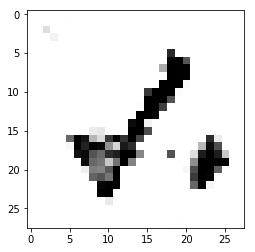

Estimate: [[-52.30977249]]
Iteration: 75300 at 2017-10-12 23:18:38.494911


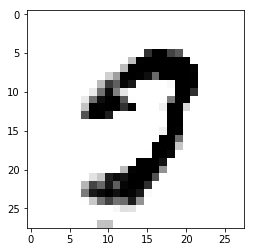

Estimate: [[-136.66090393]]
Iteration: 75400 at 2017-10-12 23:21:09.150798


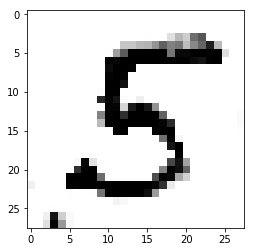

Estimate: [[-106.14164734]]
Iteration: 75500 at 2017-10-12 23:23:39.792158


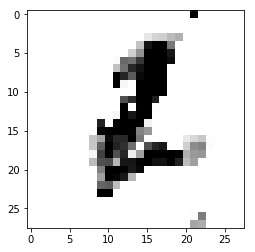

Estimate: [[-64.28894043]]
Iteration: 75600 at 2017-10-12 23:26:10.977681


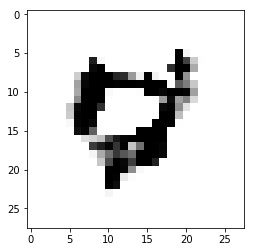

Estimate: [[-65.39083862]]
Iteration: 75700 at 2017-10-12 23:28:42.099959


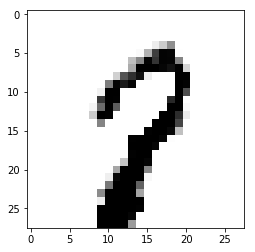

Estimate: [[-31.26088333]]
Iteration: 75800 at 2017-10-12 23:31:13.266167


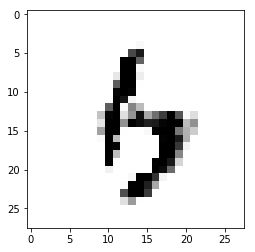

Estimate: [[-37.06186676]]
Iteration: 75900 at 2017-10-12 23:33:44.370227


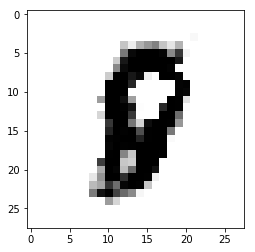

Estimate: [[-73.0228653]]
Iteration: 76000 at 2017-10-12 23:36:15.240988


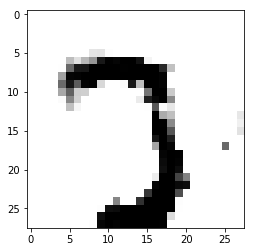

Estimate: [[ 33.83632278]]
Iteration: 76100 at 2017-10-12 23:38:46.114947


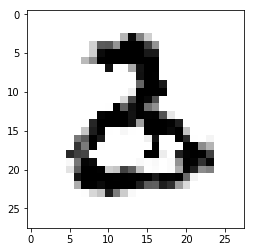

Estimate: [[-86.81056213]]
Iteration: 76200 at 2017-10-12 23:41:16.956581


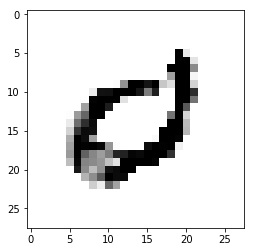

Estimate: [[-65.83957672]]
Iteration: 76300 at 2017-10-12 23:43:48.093835


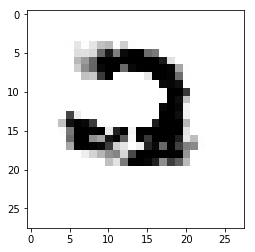

Estimate: [[-5.20700121]]
Iteration: 76400 at 2017-10-12 23:46:19.116621


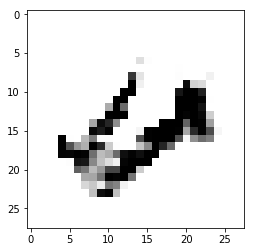

Estimate: [[-78.97822571]]
Iteration: 76500 at 2017-10-12 23:48:50.026592


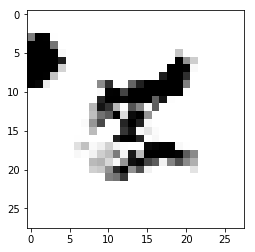

Estimate: [[-114.89300537]]
Iteration: 76600 at 2017-10-12 23:51:20.636757


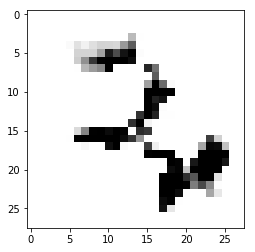

Estimate: [[-130.84980774]]
Iteration: 76700 at 2017-10-12 23:53:51.258505


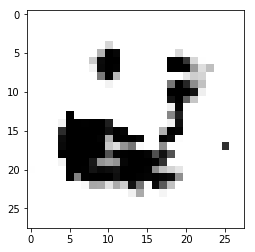

Estimate: [[-133.96722412]]
Iteration: 76800 at 2017-10-12 23:56:21.552168


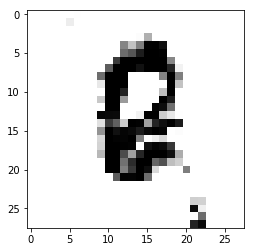

Estimate: [[-62.99081421]]
Iteration: 76900 at 2017-10-12 23:58:52.136618


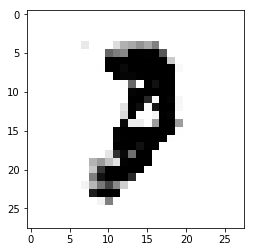

Estimate: [[-44.11156845]]
Iteration: 77000 at 2017-10-13 00:01:22.907004


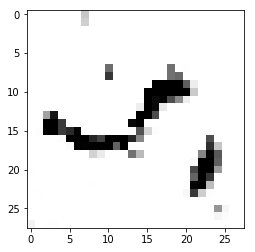

Estimate: [[-3.37987661]]
Iteration: 77100 at 2017-10-13 00:03:53.736611


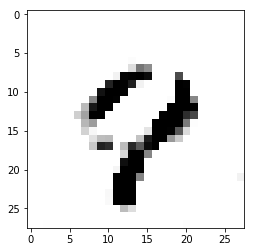

Estimate: [[-49.1326828]]
Iteration: 77200 at 2017-10-13 00:06:24.696352


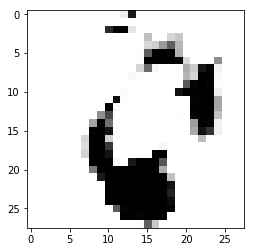

Estimate: [[-156.06517029]]
Iteration: 77300 at 2017-10-13 00:08:55.167482


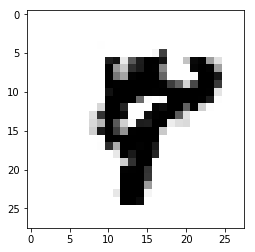

Estimate: [[-129.47540283]]
Iteration: 77400 at 2017-10-13 00:11:25.889826


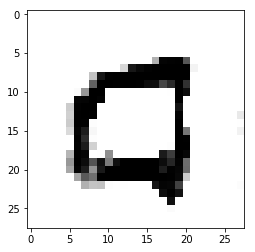

Estimate: [[-66.56594849]]
Iteration: 77500 at 2017-10-13 00:13:56.489736


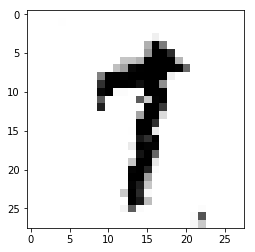

Estimate: [[-41.31648254]]
Iteration: 77600 at 2017-10-13 00:16:27.095879


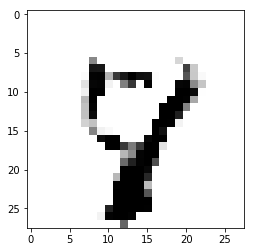

Estimate: [[ 26.14310646]]
Iteration: 77700 at 2017-10-13 00:18:58.141824


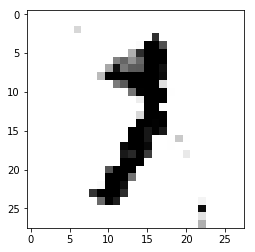

Estimate: [[-137.88621521]]
Iteration: 77800 at 2017-10-13 00:21:29.071770


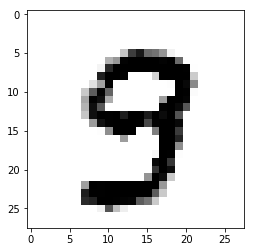

Estimate: [[-172.65393066]]
Iteration: 77900 at 2017-10-13 00:23:59.643968


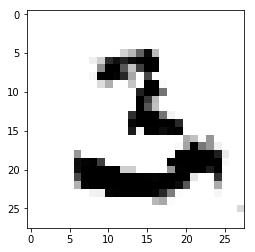

Estimate: [[-183.71446228]]
Iteration: 78000 at 2017-10-13 00:26:30.173667


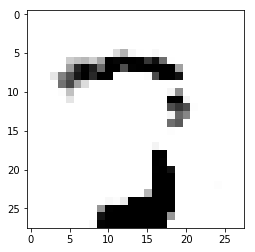

Estimate: [[ 97.44210052]]
Iteration: 78100 at 2017-10-13 00:29:00.728368


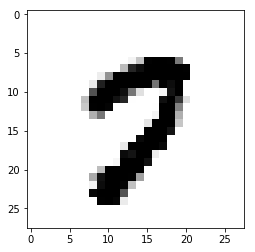

Estimate: [[-17.9733448]]
Iteration: 78200 at 2017-10-13 00:31:31.431534


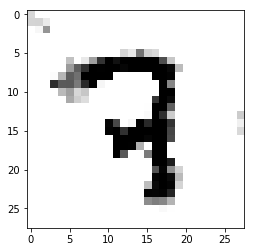

Estimate: [[-33.88988113]]
Iteration: 78300 at 2017-10-13 00:34:02.078736


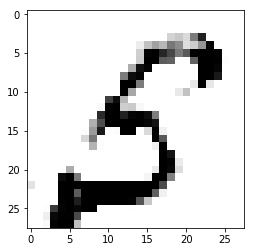

Estimate: [[-26.9138298]]
Iteration: 78400 at 2017-10-13 00:36:32.975302


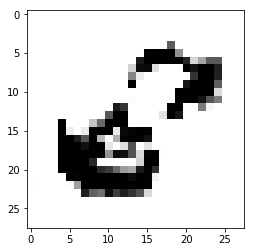

Estimate: [[-140.18861389]]
Iteration: 78500 at 2017-10-13 00:39:03.825066


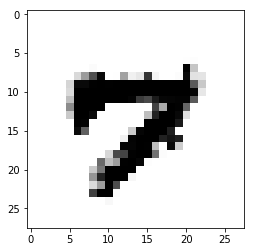

Estimate: [[-113.51867676]]
Iteration: 78600 at 2017-10-13 00:41:34.325351


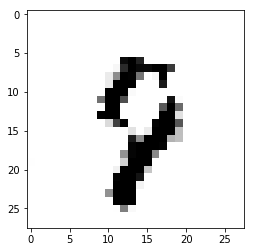

Estimate: [[-73.23162079]]
Iteration: 78700 at 2017-10-13 00:44:04.697721


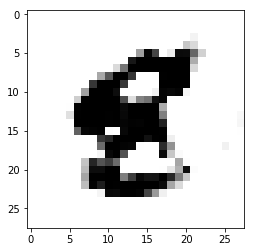

Estimate: [[-95.07775879]]
Iteration: 78800 at 2017-10-13 00:46:35.037194


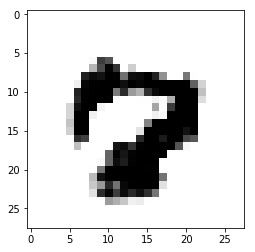

Estimate: [[ 15.95610619]]
Iteration: 78900 at 2017-10-13 00:49:05.972183


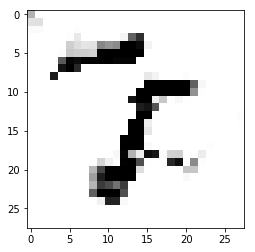

Estimate: [[-74.70644379]]
Iteration: 79000 at 2017-10-13 00:51:36.488332


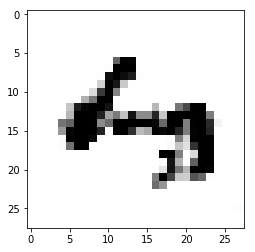

Estimate: [[ 119.70263672]]
Iteration: 79100 at 2017-10-13 00:54:07.494517


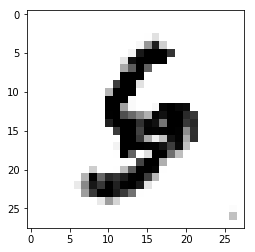

Estimate: [[-196.03889465]]
Iteration: 79200 at 2017-10-13 00:56:38.422982


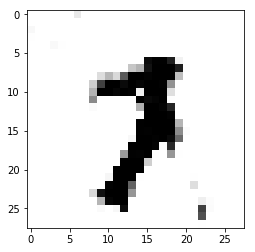

Estimate: [[-139.27507019]]
Iteration: 79300 at 2017-10-13 00:59:09.157001


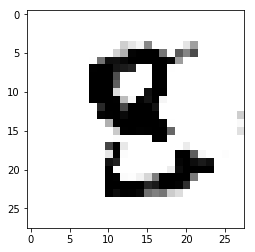

Estimate: [[-84.81806946]]
Iteration: 79400 at 2017-10-13 01:01:40.019561


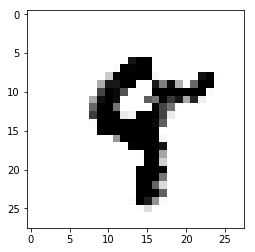

Estimate: [[-4.52797365]]
Iteration: 79500 at 2017-10-13 01:04:10.688621


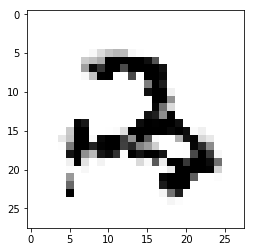

Estimate: [[-27.52522087]]
Iteration: 79600 at 2017-10-13 01:06:41.516452


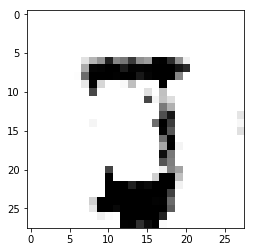

Estimate: [[-115.54081726]]
Iteration: 79700 at 2017-10-13 01:09:12.096747


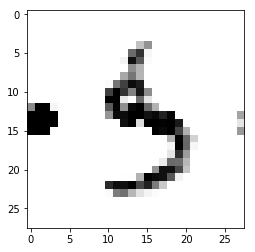

Estimate: [[-10.31409836]]
Iteration: 79800 at 2017-10-13 01:11:42.586946


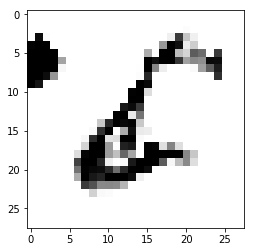

Estimate: [[-82.58097076]]
Iteration: 79900 at 2017-10-13 01:14:13.280037


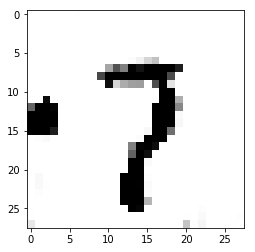

Estimate: [[-87.81784058]]
Iteration: 80000 at 2017-10-13 01:16:43.926241


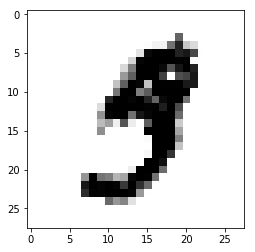

Estimate: [[ 7.74008989]]
Iteration: 80100 at 2017-10-13 01:19:14.439213


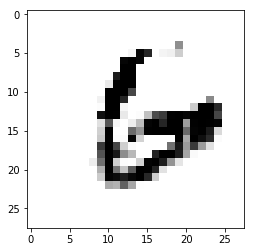

Estimate: [[-51.77601624]]
Iteration: 80200 at 2017-10-13 01:21:44.898330


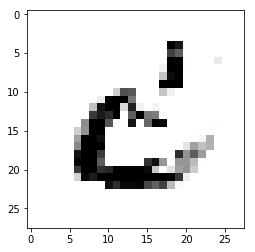

Estimate: [[-64.60290527]]
Iteration: 80300 at 2017-10-13 01:24:15.846022


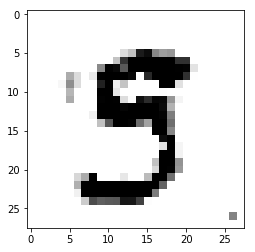

Estimate: [[-175.0934906]]
Iteration: 80400 at 2017-10-13 01:26:46.745578


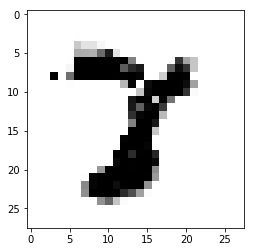

Estimate: [[-51.67400742]]
Iteration: 80500 at 2017-10-13 01:29:17.130461


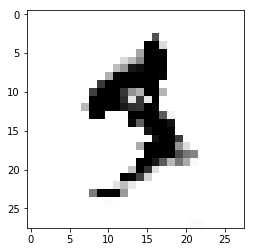

Estimate: [[-18.90247536]]
Iteration: 80600 at 2017-10-13 01:31:47.767372


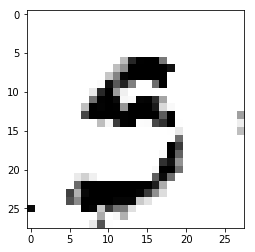

Estimate: [[-114.12374115]]
Iteration: 80700 at 2017-10-13 01:34:18.326056


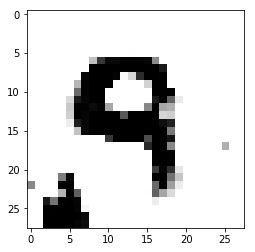

Estimate: [[ 16.81848526]]
Iteration: 80800 at 2017-10-13 01:36:49.454968


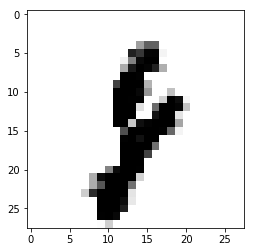

Estimate: [[-72.7583313]]
Iteration: 80900 at 2017-10-13 01:39:20.304823


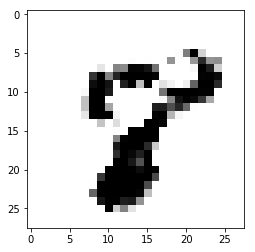

Estimate: [[ 33.07696152]]
Iteration: 81000 at 2017-10-13 01:41:51.086074


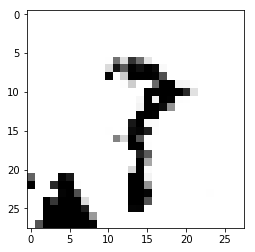

Estimate: [[ 29.17228508]]
Iteration: 81100 at 2017-10-13 01:44:22.068405


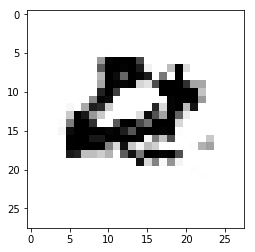

Estimate: [[-85.57579803]]
Iteration: 81200 at 2017-10-13 01:46:53.281289


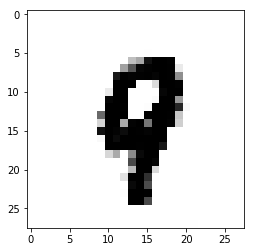

Estimate: [[-36.78274536]]
Iteration: 81300 at 2017-10-13 01:49:23.571126


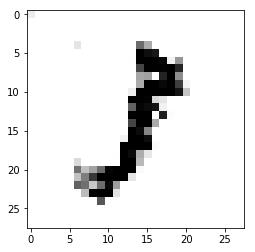

Estimate: [[-83.5286026]]
Iteration: 81400 at 2017-10-13 01:51:54.105753


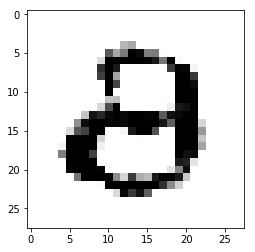

Estimate: [[-57.54219818]]
Iteration: 81500 at 2017-10-13 01:54:24.442689


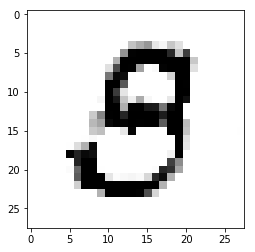

Estimate: [[-0.47960937]]
Iteration: 81600 at 2017-10-13 01:56:54.870513


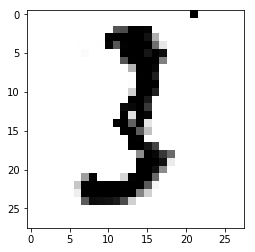

Estimate: [[-127.22389984]]
Iteration: 81700 at 2017-10-13 01:59:25.378776


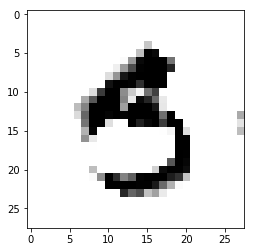

Estimate: [[-41.49910736]]
Iteration: 81800 at 2017-10-13 02:01:56.229165


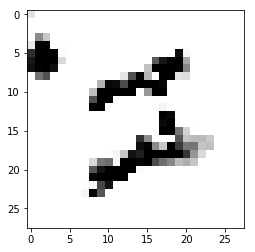

Estimate: [[-117.81956482]]
Iteration: 81900 at 2017-10-13 02:04:26.785747


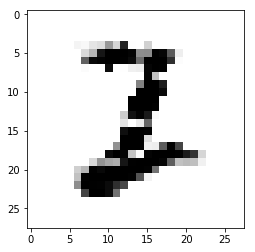

Estimate: [[ 32.45222855]]
Iteration: 82000 at 2017-10-13 02:06:57.333905


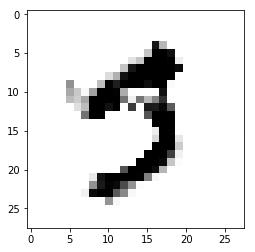

Estimate: [[ 14.48999596]]
Iteration: 82100 at 2017-10-13 02:09:28.265579


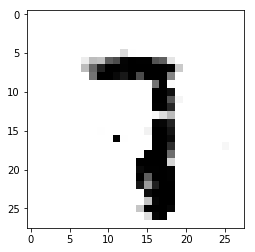

Estimate: [[-19.38839722]]
Iteration: 82200 at 2017-10-13 02:11:58.782301


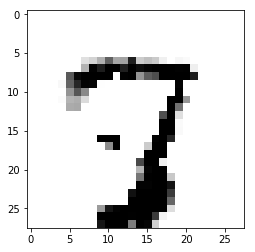

Estimate: [[-83.72211456]]
Iteration: 82300 at 2017-10-13 02:14:29.314995


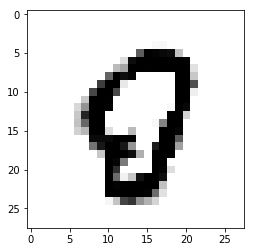

Estimate: [[-83.96099091]]
Iteration: 82400 at 2017-10-13 02:16:59.899314


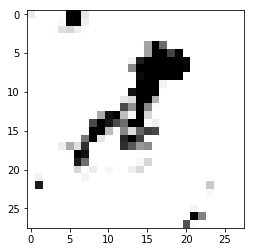

Estimate: [[-428.41226196]]
Iteration: 82500 at 2017-10-13 02:19:30.181664


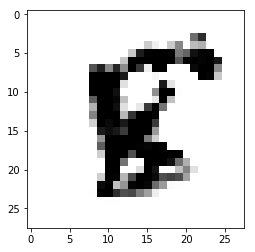

Estimate: [[ 46.69343948]]
Iteration: 82600 at 2017-10-13 02:22:00.491641


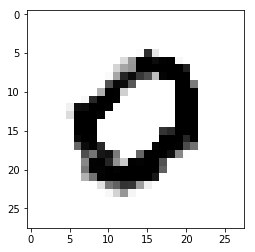

Estimate: [[-56.60027313]]
Iteration: 82700 at 2017-10-13 02:24:31.175547


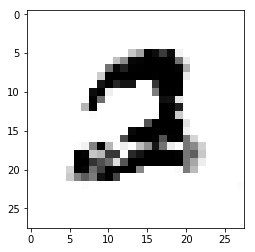

Estimate: [[-74.15419006]]
Iteration: 82800 at 2017-10-13 02:27:02.016607


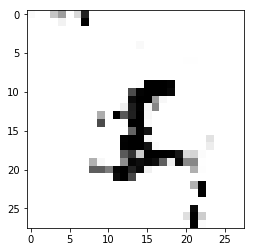

Estimate: [[-403.36541748]]
Iteration: 82900 at 2017-10-13 02:29:32.465533


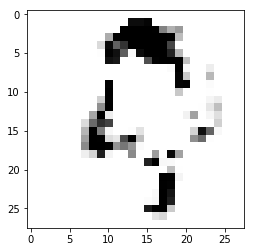

Estimate: [[ 24.74550629]]
Iteration: 83000 at 2017-10-13 02:32:02.727559


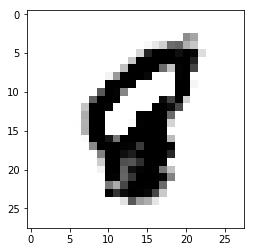

Estimate: [[ 20.80425072]]
Iteration: 83100 at 2017-10-13 02:34:33.401772


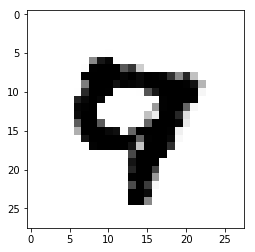

Estimate: [[ 52.67180252]]
Iteration: 83200 at 2017-10-13 02:37:04.211057


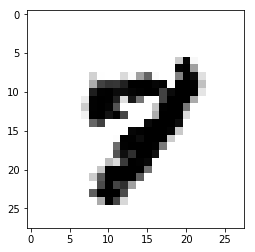

Estimate: [[-4.30656624]]
Iteration: 83300 at 2017-10-13 02:39:35.013337


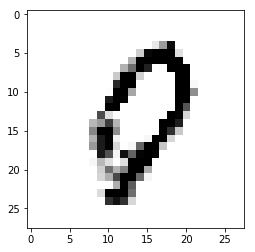

Estimate: [[-0.77963483]]
Iteration: 83400 at 2017-10-13 02:42:05.648501


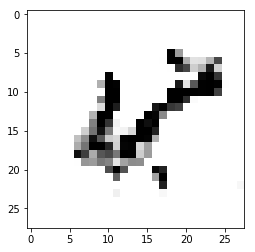

Estimate: [[-35.64277649]]
Iteration: 83500 at 2017-10-13 02:44:36.243577


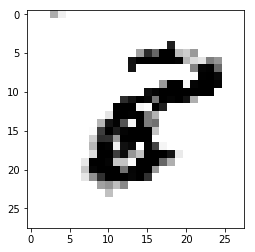

Estimate: [[-214.58270264]]
Iteration: 83600 at 2017-10-13 02:47:06.964838


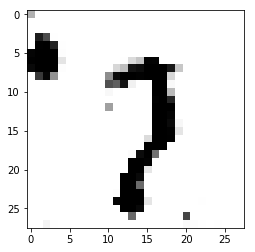

Estimate: [[-37.73298645]]
Iteration: 83700 at 2017-10-13 02:49:37.561099


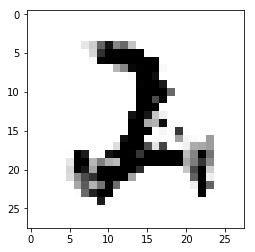

Estimate: [[-46.79311371]]
Iteration: 83800 at 2017-10-13 02:52:08.380986


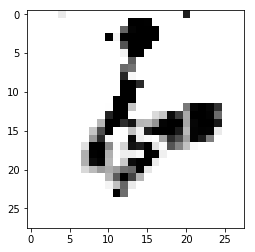

Estimate: [[-95.30508423]]
Iteration: 83900 at 2017-10-13 02:54:39.323471


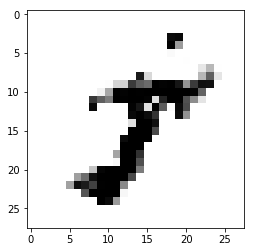

Estimate: [[-84.68179321]]
Iteration: 84000 at 2017-10-13 02:57:09.995011


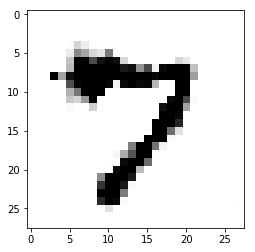

Estimate: [[-43.40722275]]
Iteration: 84100 at 2017-10-13 02:59:40.496871


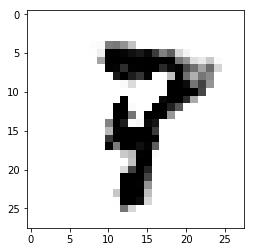

Estimate: [[-70.21791077]]
Iteration: 84200 at 2017-10-13 03:02:11.064221


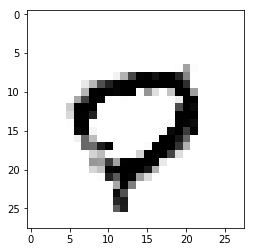

Estimate: [[-86.85753632]]
Iteration: 84300 at 2017-10-13 03:04:41.753315


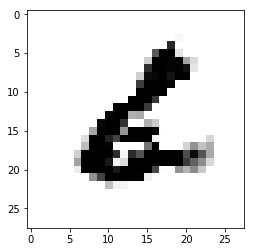

Estimate: [[-22.37952423]]
Iteration: 84400 at 2017-10-13 03:07:12.502422


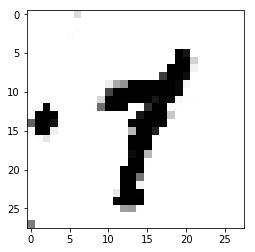

Estimate: [[ 16.51836777]]
Iteration: 84500 at 2017-10-13 03:09:43.082889


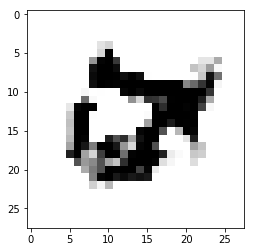

Estimate: [[-104.99215698]]
Iteration: 84600 at 2017-10-13 03:12:13.702174


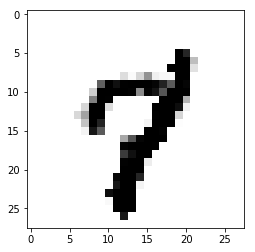

Estimate: [[-156.18016052]]
Iteration: 84700 at 2017-10-13 03:14:44.222729


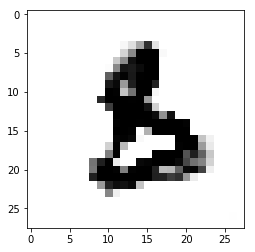

Estimate: [[-24.44888878]]
Iteration: 84800 at 2017-10-13 03:17:14.988423


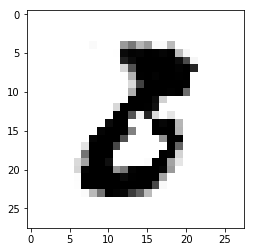

Estimate: [[-4.40992498]]
Iteration: 84900 at 2017-10-13 03:19:45.978807


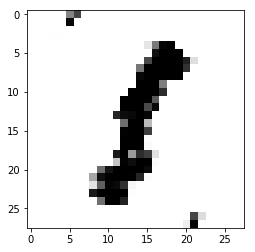

Estimate: [[-183.91490173]]
Iteration: 85000 at 2017-10-13 03:22:16.988496


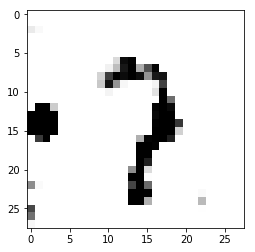

Estimate: [[-75.38388824]]
Iteration: 85100 at 2017-10-13 03:24:48.139448


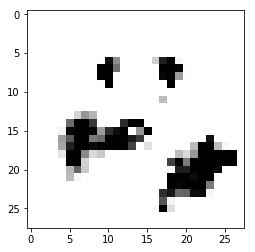

Estimate: [[-97.53400421]]
Iteration: 85200 at 2017-10-13 03:27:19.331763


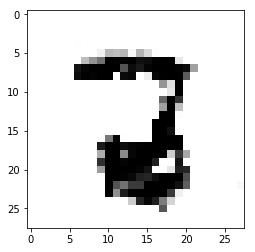

Estimate: [[-41.84205246]]
Iteration: 85300 at 2017-10-13 03:29:50.511483


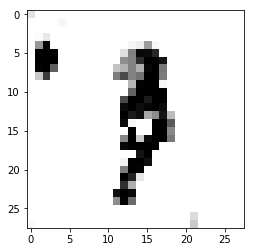

Estimate: [[-85.81784058]]
Iteration: 85400 at 2017-10-13 03:32:21.632981


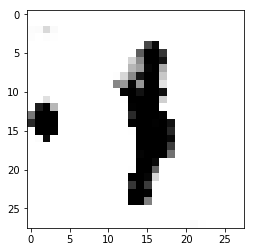

Estimate: [[-85.76004028]]
Iteration: 85500 at 2017-10-13 03:34:55.150107


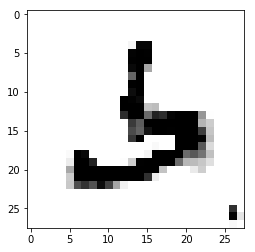

Estimate: [[-14.94556427]]
Iteration: 85600 at 2017-10-13 03:37:27.111480


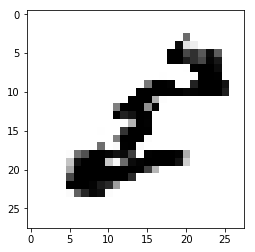

Estimate: [[-57.91534805]]
Iteration: 85700 at 2017-10-13 03:39:59.264022


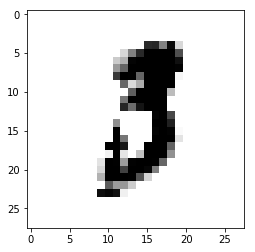

Estimate: [[ 45.8923912]]
Iteration: 85800 at 2017-10-13 03:42:31.110783


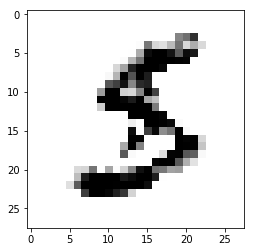

Estimate: [[-58.2918129]]
Iteration: 85900 at 2017-10-13 03:45:03.254059


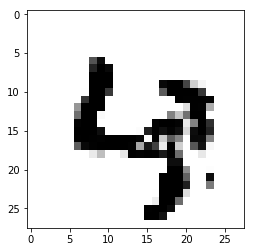

Estimate: [[ 87.02759552]]
Iteration: 86000 at 2017-10-13 03:47:35.435014


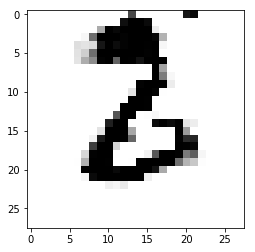

Estimate: [[ 38.07640457]]
Iteration: 86100 at 2017-10-13 03:50:07.327436


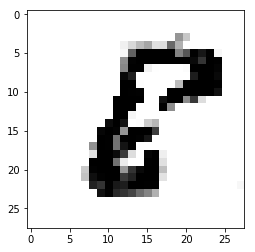

Estimate: [[ 31.39879799]]
Iteration: 86200 at 2017-10-13 03:52:39.398811


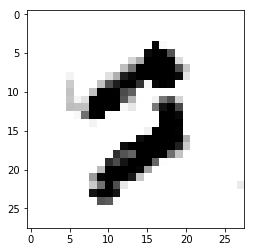

Estimate: [[ 25.98632812]]
Iteration: 86300 at 2017-10-13 03:55:11.347480


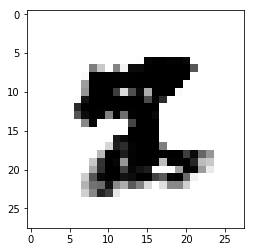

Estimate: [[ 43.68736267]]
Iteration: 86400 at 2017-10-13 03:57:43.260628


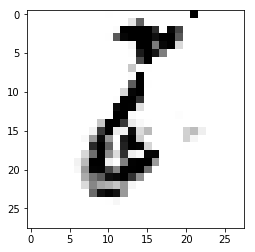

Estimate: [[-118.92597198]]
Iteration: 86500 at 2017-10-13 04:00:15.128668


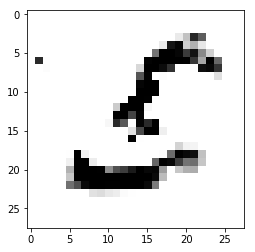

Estimate: [[-99.73670959]]
Iteration: 86600 at 2017-10-13 04:02:47.033516


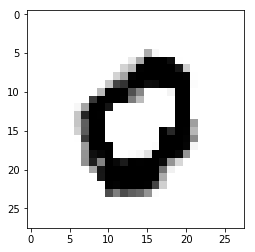

Estimate: [[-67.35707092]]
Iteration: 86700 at 2017-10-13 04:05:18.524876


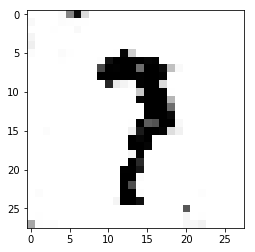

Estimate: [[-162.00743103]]
Iteration: 86800 at 2017-10-13 04:07:50.425578


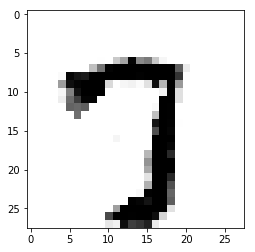

Estimate: [[-10.79393482]]
Iteration: 86900 at 2017-10-13 04:10:22.472032


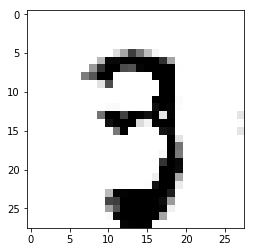

Estimate: [[-9.88998985]]
Iteration: 87000 at 2017-10-13 04:12:54.255489


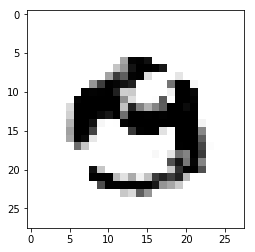

Estimate: [[-206.456604]]
Iteration: 87100 at 2017-10-13 04:15:26.223384


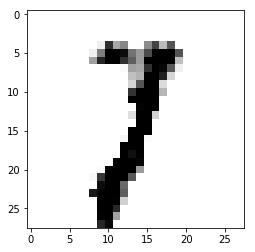

Estimate: [[-25.46709824]]
Iteration: 87200 at 2017-10-13 04:17:58.181092


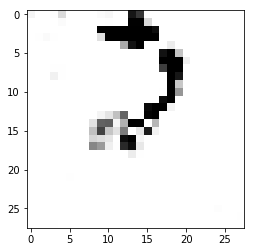

Estimate: [[ 46.02231216]]
Iteration: 87300 at 2017-10-13 04:20:29.980743


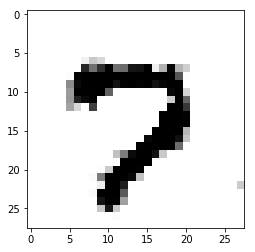

Estimate: [[-105.52246857]]
Iteration: 87400 at 2017-10-13 04:23:02.028231


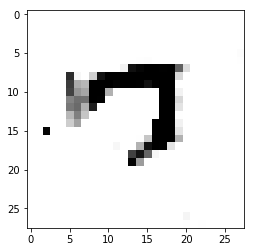

Estimate: [[-83.8451004]]
Iteration: 87500 at 2017-10-13 04:25:35.238566


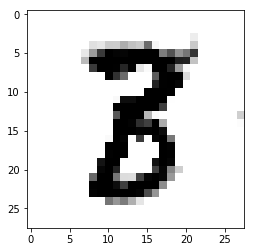

Estimate: [[ 33.47887802]]
Iteration: 87600 at 2017-10-13 04:28:07.745535


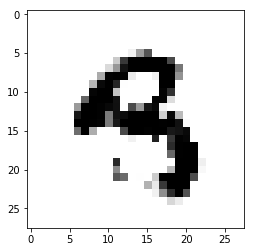

Estimate: [[-56.9068222]]
Iteration: 87700 at 2017-10-13 04:30:39.765051


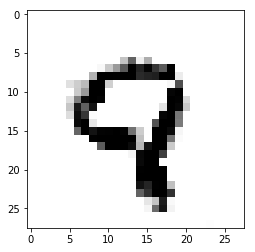

Estimate: [[-70.70469666]]
Iteration: 87800 at 2017-10-13 04:33:11.852544


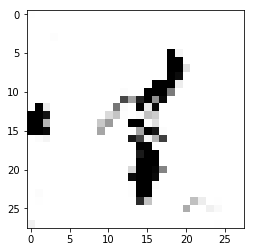

Estimate: [[-115.53922272]]
Iteration: 87900 at 2017-10-13 04:35:44.086278


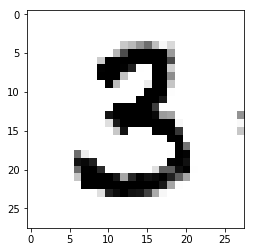

Estimate: [[-105.90579987]]
Iteration: 88000 at 2017-10-13 04:38:16.577011


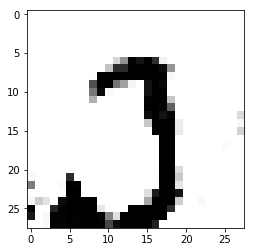

Estimate: [[-56.33804321]]
Iteration: 88100 at 2017-10-13 04:40:49.218256


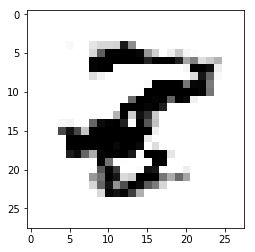

Estimate: [[-90.98244476]]
Iteration: 88200 at 2017-10-13 04:43:21.232509


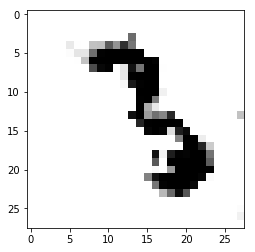

Estimate: [[-154.65663147]]
Iteration: 88300 at 2017-10-13 04:45:53.373779


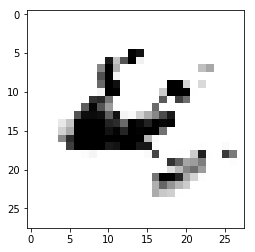

Estimate: [[-30.72573662]]
Iteration: 88400 at 2017-10-13 04:48:25.398874


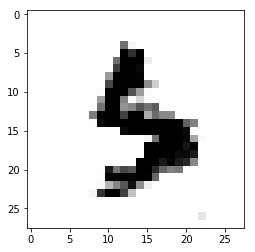

Estimate: [[-198.05276489]]
Iteration: 88500 at 2017-10-13 04:50:57.142549


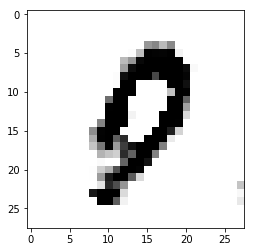

Estimate: [[-56.43335342]]
Iteration: 88600 at 2017-10-13 04:53:29.112951


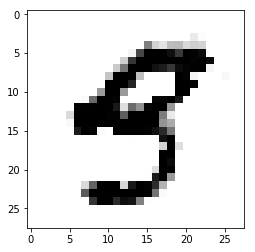

Estimate: [[ 58.02805328]]
Iteration: 88700 at 2017-10-13 04:56:00.832956


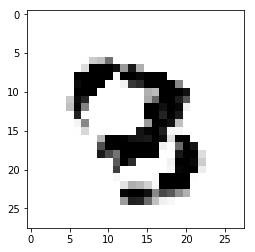

Estimate: [[-56.16251755]]
Iteration: 88800 at 2017-10-13 04:58:33.082260


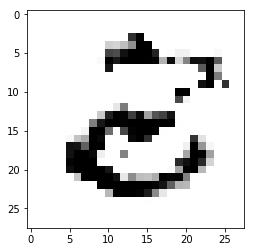

Estimate: [[ 3.74345231]]
Iteration: 88900 at 2017-10-13 05:01:05.108198


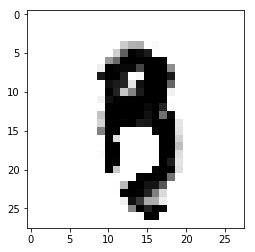

Estimate: [[-196.31286621]]
Iteration: 89000 at 2017-10-13 05:03:37.071631


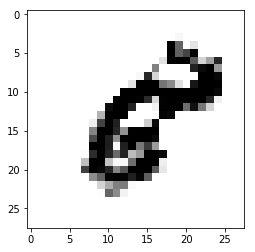

Estimate: [[-0.920578]]
Iteration: 89100 at 2017-10-13 05:06:08.758304


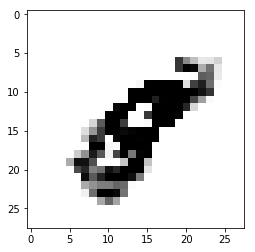

Estimate: [[-18.40192032]]
Iteration: 89200 at 2017-10-13 05:08:40.537893


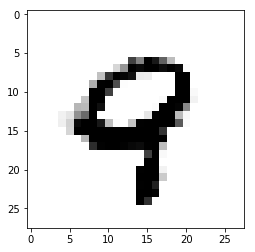

Estimate: [[-20.06947708]]
Iteration: 89300 at 2017-10-13 05:11:12.332881


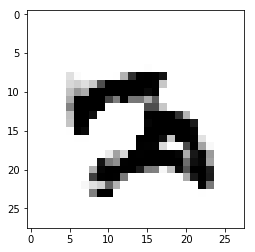

Estimate: [[-240.6723938]]
Iteration: 89400 at 2017-10-13 05:13:43.876153


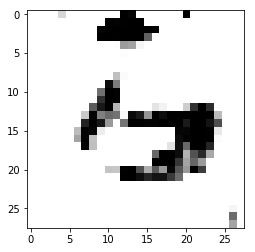

Estimate: [[-125.23719025]]
Iteration: 89500 at 2017-10-13 05:16:15.032973


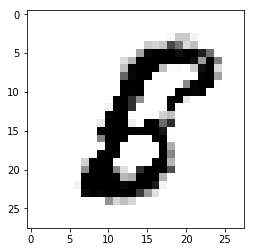

Estimate: [[ 13.87270355]]
Iteration: 89600 at 2017-10-13 05:18:46.685743


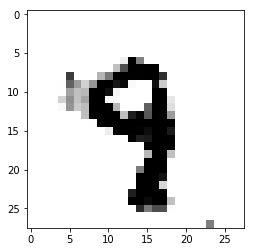

Estimate: [[-81.87624359]]
Iteration: 89700 at 2017-10-13 05:21:17.955524


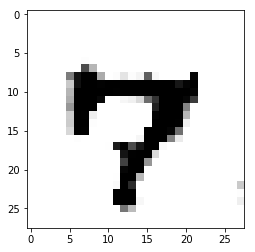

Estimate: [[-34.44038391]]
Iteration: 89800 at 2017-10-13 05:23:49.792651


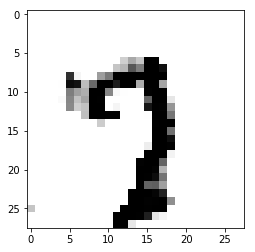

Estimate: [[-93.51013184]]
Iteration: 89900 at 2017-10-13 05:26:21.256104


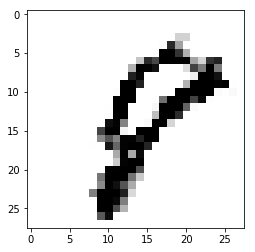

Estimate: [[-31.92757416]]
Iteration: 90000 at 2017-10-13 05:28:52.667681


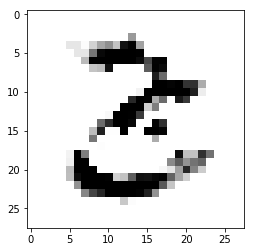

Estimate: [[-168.42713928]]
Iteration: 90100 at 2017-10-13 05:31:24.249496


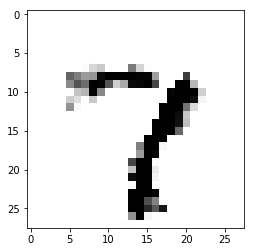

Estimate: [[-90.97559357]]
Iteration: 90200 at 2017-10-13 05:33:56.158292


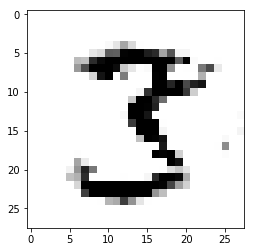

Estimate: [[-170.91717529]]
Iteration: 90300 at 2017-10-13 05:36:27.810951


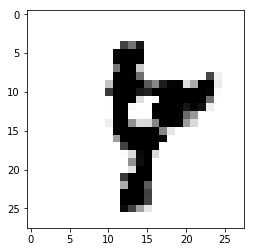

Estimate: [[ 48.10617828]]
Iteration: 90400 at 2017-10-13 05:38:59.856068


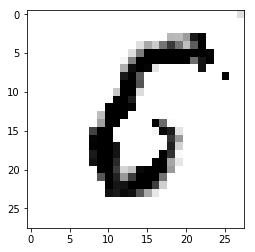

Estimate: [[-78.14716339]]
Iteration: 90500 at 2017-10-13 05:41:31.709892


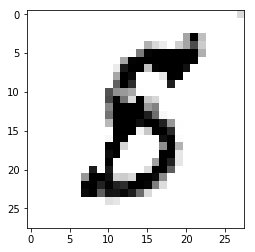

Estimate: [[-70.68630219]]
Iteration: 90600 at 2017-10-13 05:44:03.687807


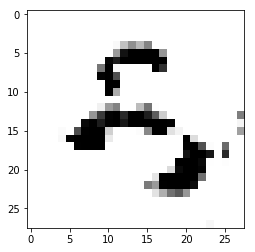

Estimate: [[-2.78534794]]
Iteration: 90700 at 2017-10-13 05:46:36.144806


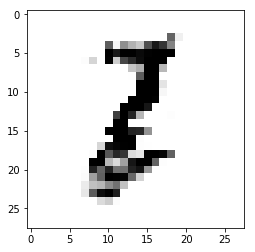

Estimate: [[-54.20757294]]
Iteration: 90800 at 2017-10-13 05:49:08.427545


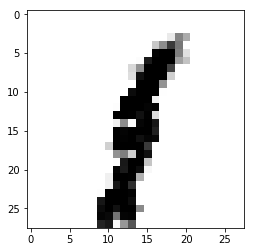

Estimate: [[-79.11725616]]
Iteration: 90900 at 2017-10-13 05:51:40.298240


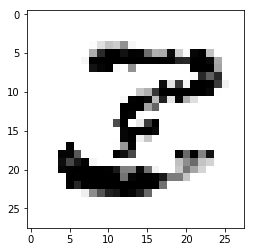

Estimate: [[-182.48880005]]
Iteration: 91000 at 2017-10-13 05:54:11.972168


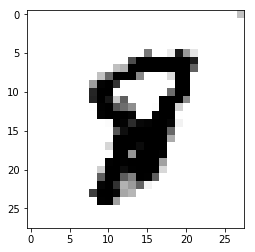

Estimate: [[-186.02462769]]
Iteration: 91100 at 2017-10-13 05:56:43.861686


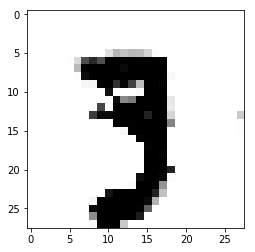

Estimate: [[-16.55805588]]
Iteration: 91200 at 2017-10-13 05:59:15.345148


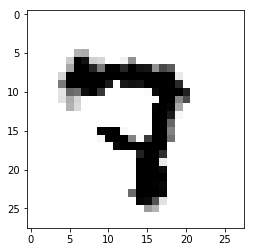

Estimate: [[-27.09741974]]
Iteration: 91300 at 2017-10-13 06:01:46.692939


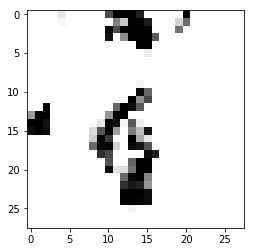

Estimate: [[-85.80789948]]
Iteration: 91400 at 2017-10-13 06:04:20.624781


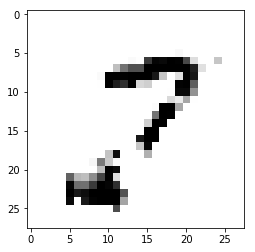

Estimate: [[-236.85853577]]
Iteration: 91500 at 2017-10-13 06:06:51.844154


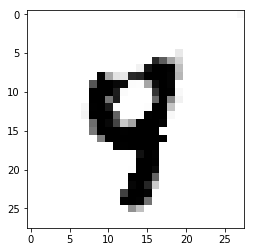

Estimate: [[-101.19398499]]
Iteration: 91600 at 2017-10-13 06:09:23.514723


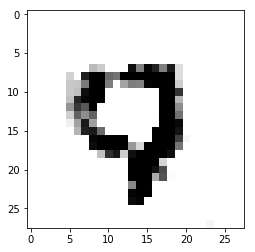

Estimate: [[-129.78903198]]
Iteration: 91700 at 2017-10-13 06:11:54.888972


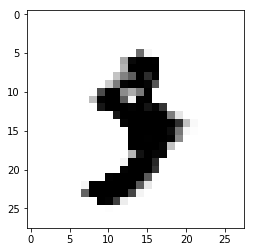

Estimate: [[-84.3967514]]
Iteration: 91800 at 2017-10-13 06:14:25.998712


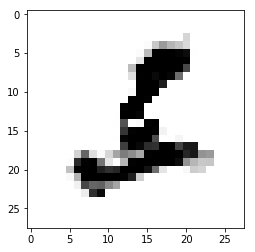

Estimate: [[-22.22796822]]
Iteration: 91900 at 2017-10-13 06:16:58.257173


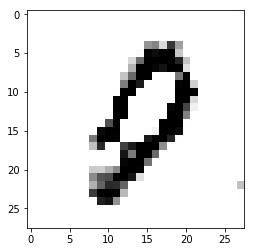

Estimate: [[-34.5138855]]
Iteration: 92000 at 2017-10-13 06:19:29.950537


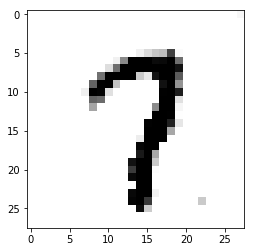

Estimate: [[-117.6880188]]
Iteration: 92100 at 2017-10-13 06:22:02.313038


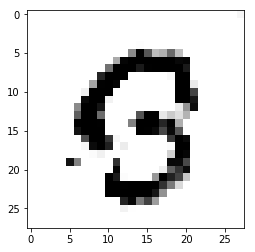

Estimate: [[-135.108078]]
Iteration: 92200 at 2017-10-13 06:24:34.266600


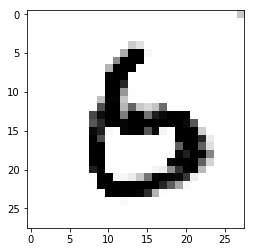

Estimate: [[-93.41043854]]
Iteration: 92300 at 2017-10-13 06:27:06.026608


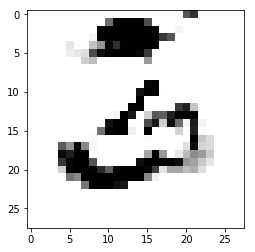

Estimate: [[-66.57243347]]
Iteration: 92400 at 2017-10-13 06:29:39.108985


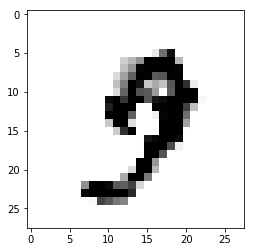

Estimate: [[-211.80751038]]
Iteration: 92500 at 2017-10-13 06:32:12.663672


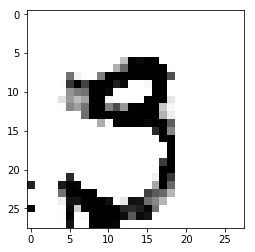

Estimate: [[-136.56826782]]
Iteration: 92600 at 2017-10-13 06:34:44.933317


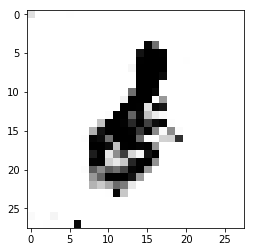

Estimate: [[-239.50970459]]
Iteration: 92700 at 2017-10-13 06:37:16.323311


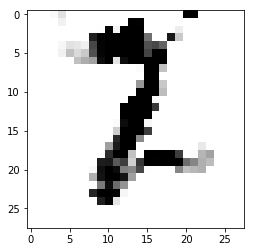

Estimate: [[-63.39743805]]
Iteration: 92800 at 2017-10-13 06:39:47.632384


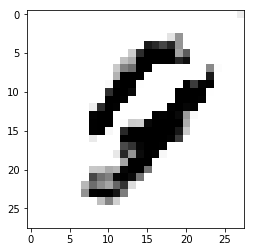

Estimate: [[ 0.85417634]]
Iteration: 92900 at 2017-10-13 06:42:19.738485


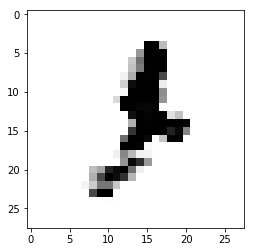

Estimate: [[-30.72555733]]
Iteration: 93000 at 2017-10-13 06:44:51.526277


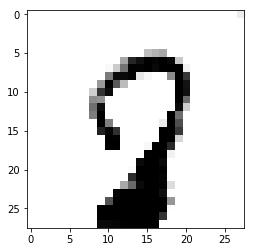

Estimate: [[-63.20196152]]
Iteration: 93100 at 2017-10-13 06:47:22.916817


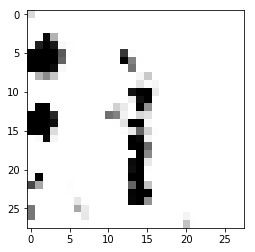

Estimate: [[-396.15264893]]
Iteration: 93200 at 2017-10-13 06:49:54.211141


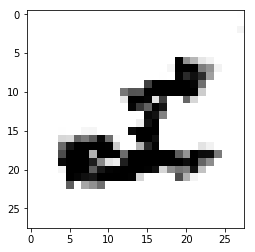

Estimate: [[-75.11465454]]
Iteration: 93300 at 2017-10-13 06:52:25.901934


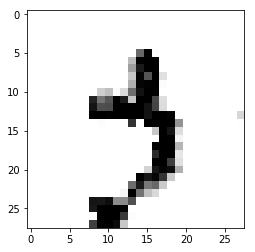

Estimate: [[-91.49660492]]
Iteration: 93400 at 2017-10-13 06:54:57.939779


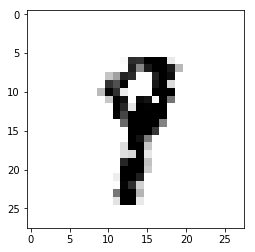

Estimate: [[ 9.49671841]]
Iteration: 93500 at 2017-10-13 06:57:29.523876


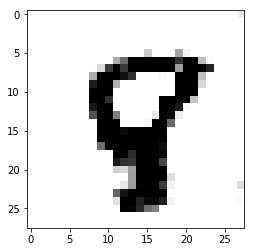

Estimate: [[-161.90472412]]
Iteration: 93600 at 2017-10-13 07:00:01.385906


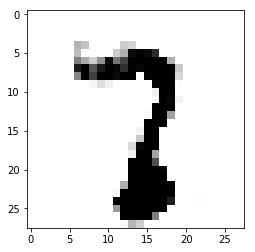

Estimate: [[-110.73947144]]
Iteration: 93700 at 2017-10-13 07:02:33.192724


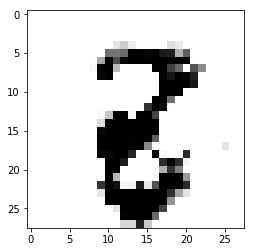

Estimate: [[-47.66905594]]
Iteration: 93800 at 2017-10-13 07:05:04.951898


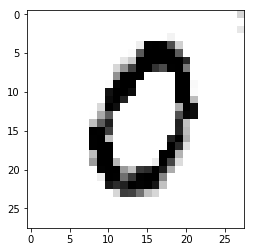

Estimate: [[ 11.69027328]]
Iteration: 93900 at 2017-10-13 07:07:36.492222


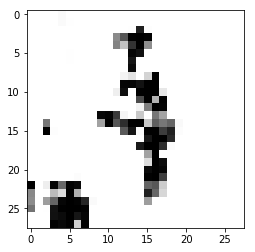

Estimate: [[-147.1050415]]
Iteration: 94000 at 2017-10-13 07:10:07.827118


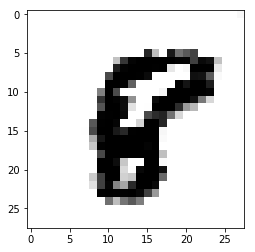

Estimate: [[-118.59975433]]
Iteration: 94100 at 2017-10-13 07:12:39.180766


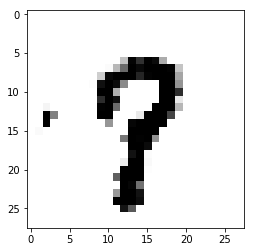

Estimate: [[-89.17982483]]
Iteration: 94200 at 2017-10-13 07:15:11.106686


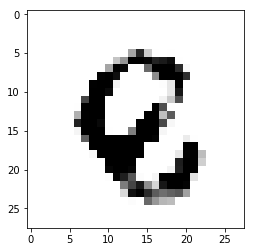

Estimate: [[ 23.03983116]]
Iteration: 94300 at 2017-10-13 07:17:42.968743


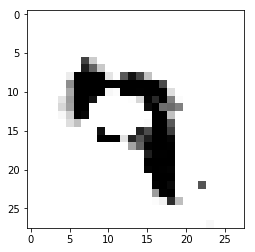

Estimate: [[ 59.18671417]]
Iteration: 94400 at 2017-10-13 07:20:14.571861


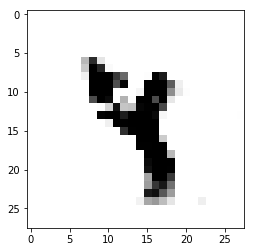

Estimate: [[-49.26104355]]
Iteration: 94500 at 2017-10-13 07:22:45.888130


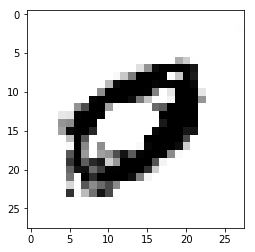

Estimate: [[-286.85449219]]
Iteration: 94600 at 2017-10-13 07:25:17.477732


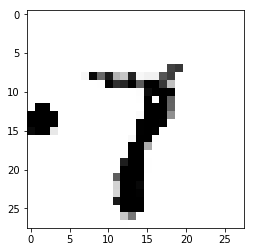

Estimate: [[-59.70882416]]
Iteration: 94700 at 2017-10-13 07:27:48.783504


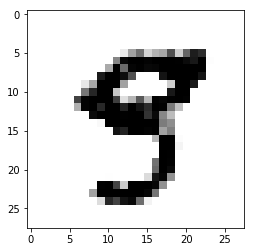

Estimate: [[ 59.29888153]]
Iteration: 94800 at 2017-10-13 07:30:20.719525


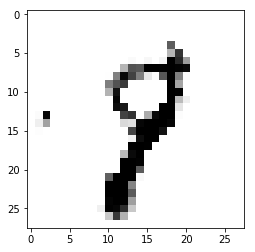

Estimate: [[-37.37657166]]
Iteration: 94900 at 2017-10-13 07:32:52.676359


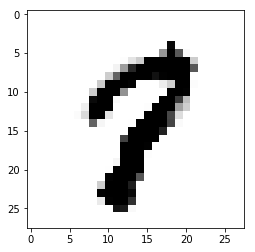

Estimate: [[-204.71846008]]
Iteration: 95000 at 2017-10-13 07:35:24.002732


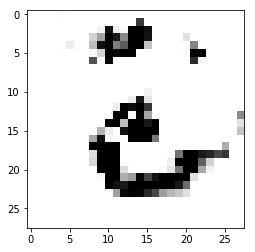

Estimate: [[-97.76966858]]
Iteration: 95100 at 2017-10-13 07:37:55.251062


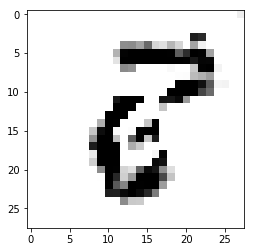

Estimate: [[ 61.05098343]]
Iteration: 95200 at 2017-10-13 07:40:26.958725


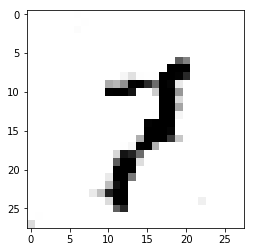

Estimate: [[-83.77690125]]
Iteration: 95300 at 2017-10-13 07:42:58.516484


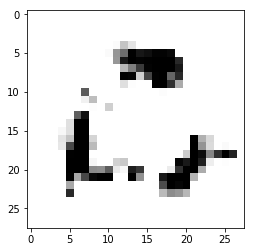

Estimate: [[-81.36873627]]
Iteration: 95400 at 2017-10-13 07:45:30.469971


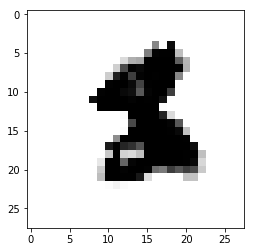

Estimate: [[-86.11175537]]
Iteration: 95500 at 2017-10-13 07:48:02.239138


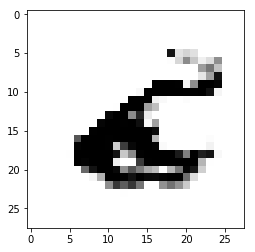

Estimate: [[-38.45236969]]
Iteration: 95600 at 2017-10-13 07:50:33.594436


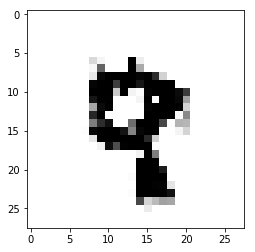

Estimate: [[-53.65973282]]
Iteration: 95700 at 2017-10-13 07:53:05.266716


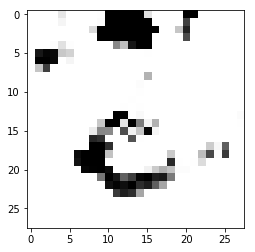

Estimate: [[-184.08222961]]
Iteration: 95800 at 2017-10-13 07:55:37.176741


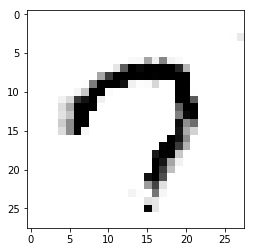

Estimate: [[-7.20835829]]
Iteration: 95900 at 2017-10-13 07:58:08.711790


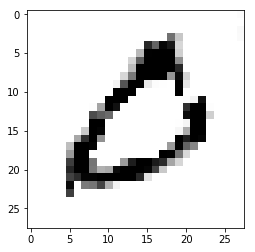

Estimate: [[ 26.04328918]]
Iteration: 96000 at 2017-10-13 08:00:40.480126


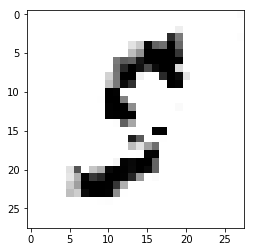

Estimate: [[-138.97824097]]
Iteration: 96100 at 2017-10-13 08:03:12.254701


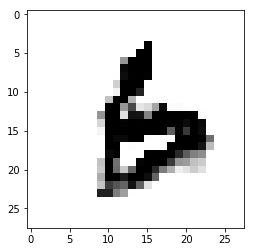

Estimate: [[-169.96107483]]
Iteration: 96200 at 2017-10-13 08:05:44.479638


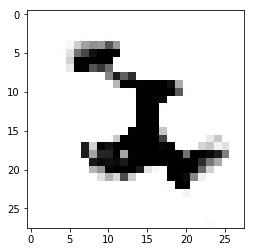

Estimate: [[-86.53098297]]
Iteration: 96300 at 2017-10-13 08:08:16.660005


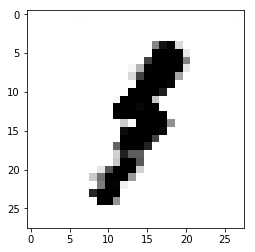

Estimate: [[ 34.8543129]]
Iteration: 96400 at 2017-10-13 08:10:48.627207


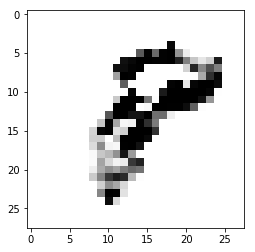

Estimate: [[-30.34928894]]
Iteration: 96500 at 2017-10-13 08:13:21.012081


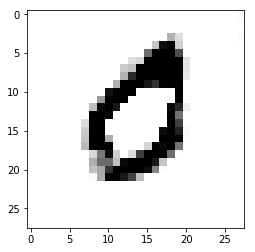

Estimate: [[-108.47993469]]
Iteration: 96600 at 2017-10-13 08:15:52.579613


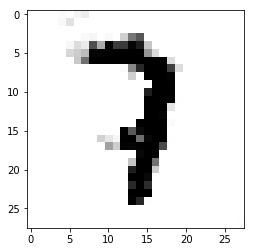

Estimate: [[-146.90408325]]
Iteration: 96700 at 2017-10-13 08:18:24.517774


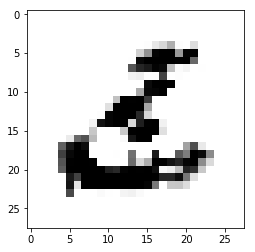

Estimate: [[-174.89231873]]
Iteration: 96800 at 2017-10-13 08:20:56.609320


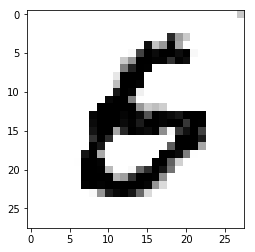

Estimate: [[-56.99892807]]
Iteration: 96900 at 2017-10-13 08:23:28.706270


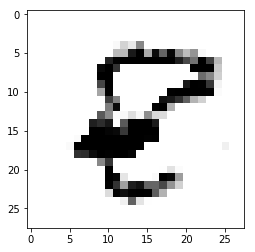

Estimate: [[-43.25698471]]
Iteration: 97000 at 2017-10-13 08:26:00.538624


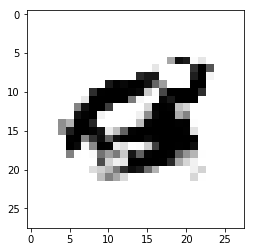

Estimate: [[-21.82624626]]
Iteration: 97100 at 2017-10-13 08:28:32.211934


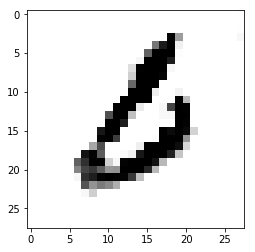

Estimate: [[-11.44738483]]
Iteration: 97200 at 2017-10-13 08:31:04.480962


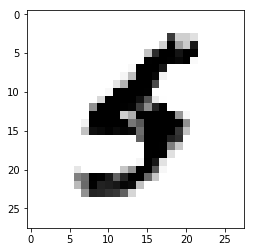

Estimate: [[-134.27929688]]
Iteration: 97300 at 2017-10-13 08:33:36.965785


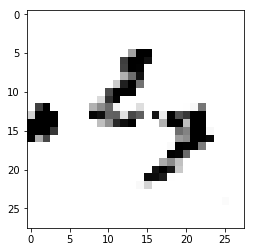

Estimate: [[-143.43710327]]
Iteration: 97400 at 2017-10-13 08:36:09.519688


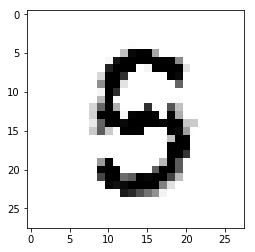

Estimate: [[-84.16754913]]
Iteration: 97500 at 2017-10-13 08:38:41.892636


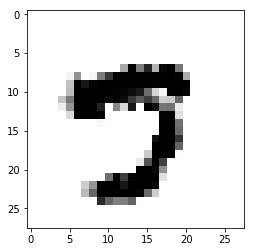

Estimate: [[-96.3297348]]
Iteration: 97600 at 2017-10-13 08:41:14.342834


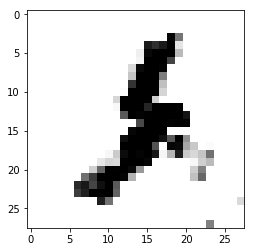

Estimate: [[-28.69832993]]
Iteration: 97700 at 2017-10-13 08:43:46.702085


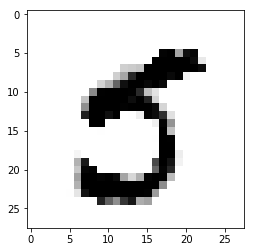

Estimate: [[-70.23239899]]
Iteration: 97800 at 2017-10-13 08:46:19.064639


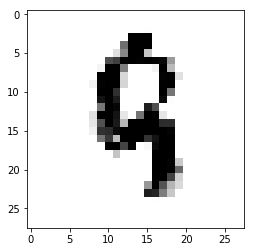

Estimate: [[-68.72998047]]
Iteration: 97900 at 2017-10-13 08:48:51.094383


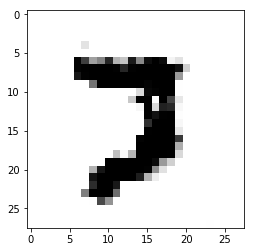

Estimate: [[ 18.56070328]]
Iteration: 98000 at 2017-10-13 08:51:23.513957


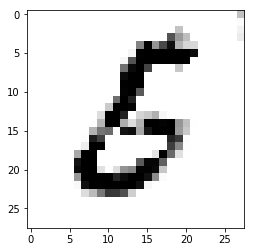

Estimate: [[ 1.68477595]]
Iteration: 98100 at 2017-10-13 08:53:56.009742


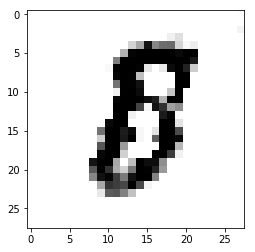

Estimate: [[-0.84575689]]
Iteration: 98200 at 2017-10-13 08:56:28.127280


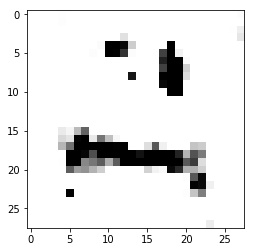

Estimate: [[-73.49856567]]
Iteration: 98300 at 2017-10-13 08:59:00.094899


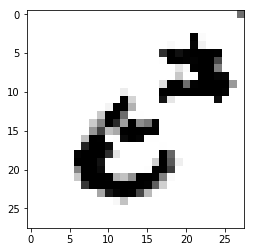

Estimate: [[-65.20748901]]
Iteration: 98400 at 2017-10-13 09:01:32.329775


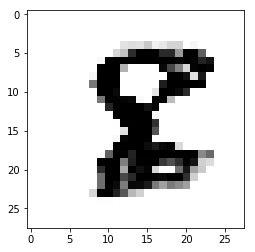

Estimate: [[-37.82736588]]
Iteration: 98500 at 2017-10-13 09:04:04.404290


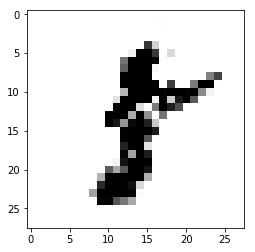

Estimate: [[-93.84453583]]
Iteration: 98600 at 2017-10-13 09:06:37.019290


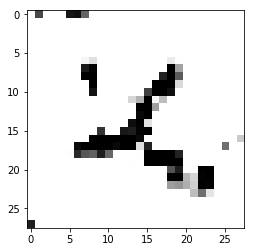

Estimate: [[-206.11198425]]
Iteration: 98700 at 2017-10-13 09:09:09.625929


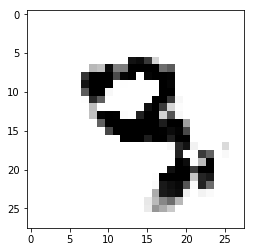

Estimate: [[-72.92606354]]
Iteration: 98800 at 2017-10-13 09:11:42.295942


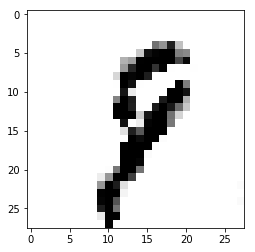

Estimate: [[ 15.37346363]]
Iteration: 98900 at 2017-10-13 09:14:14.390918


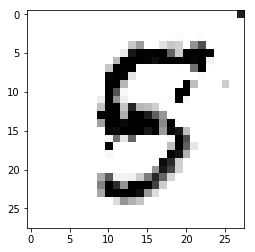

Estimate: [[-70.89613342]]
Iteration: 99000 at 2017-10-13 09:16:46.496344


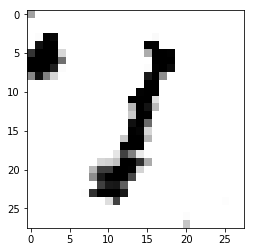

Estimate: [[-90.14372253]]
Iteration: 99100 at 2017-10-13 09:19:18.715123


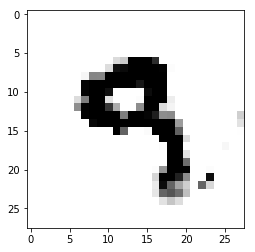

Estimate: [[-113.78125]]
Iteration: 99200 at 2017-10-13 09:21:50.842052


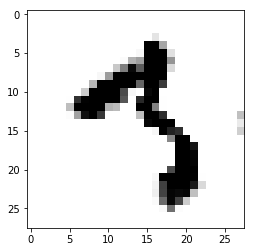

Estimate: [[-40.93533707]]
Iteration: 99300 at 2017-10-13 09:24:23.286402


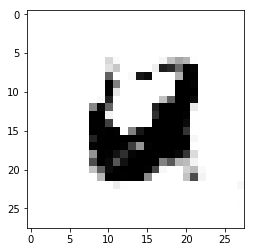

Estimate: [[ 55.73849869]]
Iteration: 99400 at 2017-10-13 09:26:55.797973


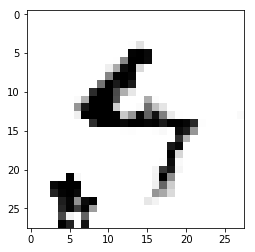

Estimate: [[ 82.0933075]]
Iteration: 99500 at 2017-10-13 09:29:28.454972


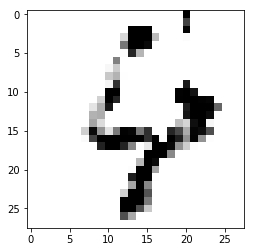

Estimate: [[-184.11964417]]
Iteration: 99600 at 2017-10-13 09:32:00.835660


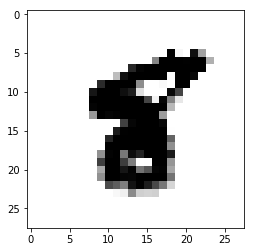

Estimate: [[-183.33732605]]
Iteration: 99700 at 2017-10-13 09:34:33.383313


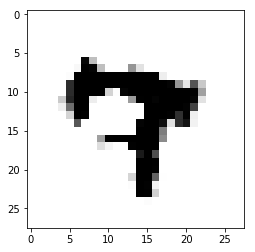

Estimate: [[-125.84505463]]
Iteration: 99800 at 2017-10-13 09:37:08.189262


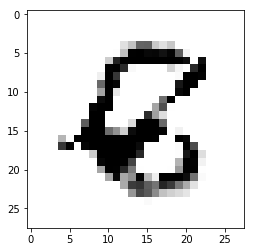

Estimate: [[-65.50286102]]
Iteration: 99900 at 2017-10-13 09:39:41.469730


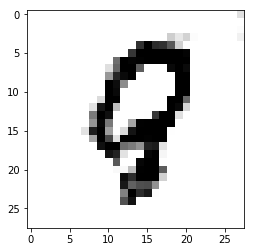

Estimate: [[-2.87767935]]


In [11]:

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt')
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, {z_placeholder: z_batch})
    for i in range(10):
        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')
        plt.show()

INFO:tensorflow:Restoring parameters from pretrained-model/pretrained_gan.ckpt
